<a href="https://colab.research.google.com/github/bjones117/Live-Stream-Facial-Expression-Classification/blob/main/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Install packages

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

!pip install yahoofinancials

from yahoofinancials import YahooFinancials
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *

!pip install pandas_ta
import pandas_ta as ta

np.random.seed(1)

from keras.models import Sequential, load_model
from keras.layers.core import Dense
from keras.layers.recurrent import LSTM
from keras import optimizers
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
import datetime as dt
import time
plt.style.use('ggplot')

  Created wheel for yahoofinancials: filename=yahoofinancials-1.6-py3-none-any.whl size=15192 sha256=768dbf33e83c87a75385b54ef5120ed7df144ead9222d9bf6c7c2e58dc045d52
  Stored in directory: /root/.cache/pip/wheels/4b/63/46/e7110bfee88685fe69e338d1b14d1748921862aa57b6705b60
Successfully built yahoofinancials
     |████████████████████████████████| 115 kB 9.8 MB/s 
  Created wheel for pandas-ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218923 sha256=0a2a53287d8b491995151d1fc6a197b595750b7ea9dd628559d8762ab8dc4d65
  Stored in directory: /root/.cache/pip/wheels/0b/81/f0/cca85757840e4616a2c6b9fe12569d97d324c27cac60724c58
Successfully built pandas-ta


#Apple

##Data Load, Preprocessing, and Modeling

###Information Load and Dataframe setup

In [ ]:
ticker = 'AAPL'

In [ ]:
!rm -rf '/content/drive/MyDrive/Final Project Files/LSTM_Weights_'+ticker.hdf5

In [ ]:
DAYS = 30

In [ ]:
start_date = '2014-12-08'
end_date = '2022-04-22'

# Import Ticker Data
yahoo_financials = YahooFinancials(ticker)
data = yahoo_financials.get_historical_price_data(start_date=start_date, 
                                                  end_date=end_date, 
                                                  time_interval='daily')
df = pd.DataFrame(data[ticker]['prices'])
df = df.drop('date', axis=1).set_index('formatted_date')
#df = df.reset_index()
#df = df.rename(columns={"formatted_date": "Date"})
df = df.dropna()

# Oscillator Calculation
k_period = 14
d_period = 3
# Adds a "n_high" column with max value of previous 14 periods
df['n_high'] = df['high'].rolling(k_period).max()
# Adds an "n_low" column with min value of previous 14 periods
df['n_low'] = df['low'].rolling(k_period).min()
# Uses the min/max values to calculate the %k (as a percentage)
df['%K'] = (df['adjclose'] - df['n_low']) * 100 / (df['n_high'] - df['n_low'])
# Uses the %k to calculates a SMA over the past 3 values of %k
df['%D'] = df['%K'].rolling(d_period).mean()

df.ta.stoch(high='high', low='low', k=14, d=3, append=True)

df = df.dropna()
df = df.drop(['n_high', 'n_low', '%K', '%D'], axis=1)
df = df.rename(columns={"STOCHk_14_3_3": "Fast Osc. Signal", "STOCHd_14_3_3": "Slow Osc. Signal"})


# Create lag variables
df['Volume_lag'] = df['volume'].shift(1)
df['High_lag'] = df['high'].shift(1)
df['Low_lag'] = df['low'].shift(1)
df['Open_lag'] = df['open'].shift(1)
df['Adj_Close_lag'] = df['adjclose'].shift(1)
df['Fast Osc. Lag'] = df['Fast Osc. Signal'].shift(1)
df['Slow Osc. Lag'] = df['Slow Osc. Signal'].shift(1)
df = df.drop(['volume'], axis=1)
df = df.drop(['close'], axis=1)
df = df.drop(['low'], axis=1)
df = df.drop(['high'], axis=1)
df = df.drop(['open'], axis=1)
df = df.drop(['Fast Osc. Signal'], axis=1)
df = df.drop(['Slow Osc. Signal'], axis=1)
print(df)

                  adjclose   Volume_lag    High_lag     Low_lag    Open_lag  \
formatted_date                                                                
2015-01-02       24.714502          NaN         NaN         NaN         NaN   
2015-01-05       24.018259  212818400.0   27.860001   26.837500   27.847500   
2015-01-06       24.020523  257142000.0   27.162500   26.352501   27.072500   
2015-01-07       24.357342  263188400.0   26.857500   26.157499   26.635000   
2015-01-08       25.293207  160423600.0   27.049999   26.674999   26.799999   
...                    ...          ...         ...         ...         ...   
2022-04-14      165.289993   70618900.0  171.039993  166.770004  167.389999   
2022-04-18      165.070007   75237500.0  171.270004  165.039993  170.619995   
2022-04-19      167.399994   69023900.0  166.600006  163.570007  163.919998   
2022-04-20      167.229996   67723800.0  167.820007  163.910004  165.020004   
2022-04-21      166.419998   67929800.0  168.880005 

In [ ]:
# Get 30 year Bond Yield
yahoo_financials = YahooFinancials('^TYX')
data = yahoo_financials.get_historical_price_data(start_date=start_date, 
                                                  end_date=end_date, 
                                                  time_interval='daily')
yield_30yr = pd.DataFrame(data['^TYX']['prices'])
yield_30yr = yield_30yr.drop('date', axis=1).set_index('formatted_date')
#yield_30yr = yield_30yr.reset_index()
#yield_df = yield_30yr.rename(columns={"formatted_date": "Date"})
yield_df = yield_30yr.filter(['close'], axis=1)
yield_df = yield_df.dropna()
yield_df = yield_df.rename(columns={"close": "Bond_Yield"})
yield_df['Bond_Yield_Lag'] = yield_df['Bond_Yield'].shift(1)
yield_df = yield_df.drop(['Bond_Yield'], axis=1)
print(yield_df)

# Get Market Sentiment index
yahoo_financials = YahooFinancials('^VIX')
data = yahoo_financials.get_historical_price_data(start_date=start_date, 
                                                  end_date=end_date, 
                                                  time_interval='daily')
vix_df = pd.DataFrame(data['^VIX']['prices'])
vix_df = vix_df.drop('date', axis=1).set_index('formatted_date')
#vix_df = vix_df.reset_index()
#vix_df = vix_df.rename(columns={"formatted_date": "Date"})
vix_df = vix_df.filter(['close'], axis=1)
vix_df = vix_df.dropna()
vix_df = vix_df.rename(columns={"close": "VIX"})
vix_df['VIX_Lag'] = vix_df['VIX'].shift(1)
vix_df = vix_df.drop(['VIX'], axis = 1)
print(vix_df)


# Get Wilshire 5000 index
yahoo_financials = YahooFinancials('^W5000')
data = yahoo_financials.get_historical_price_data(start_date=start_date, 
                                                 end_date=end_date, 
                                                  time_interval='daily')
w5000 = pd.DataFrame(data['^W5000']['prices'])
w5000 = w5000.drop('date', axis=1).set_index('formatted_date')
#w5000 = w5000.reset_index()
#w5000 = w5000.rename(columns={"formatted_date": "Date"})
w5000 = w5000.filter(['close'], axis=1)
w5000 = w5000.dropna()
w5000 = w5000.rename(columns={"close": "Wilshire"})
w5000['Wilshire_Lag'] = w5000['Wilshire'].shift(1)
w5000 = w5000.drop(['Wilshire'], axis = 1)
print(w5000)

                Bond_Yield_Lag
formatted_date                
2014-12-08                 NaN
2014-12-09               2.901
2014-12-10               2.875
2014-12-11               2.835
2014-12-12               2.825
...                        ...
2022-04-14               2.794
2022-04-18               2.919
2022-04-19               2.953
2022-04-20               2.990
2022-04-21               2.879

[1854 rows x 1 columns]
                  VIX_Lag
formatted_date           
2014-12-08            NaN
2014-12-09      14.210000
2014-12-10      15.350000
2014-12-11      18.530001
2014-12-12      20.080000
...                   ...
2022-04-14      21.820000
2022-04-18      22.700001
2022-04-19      22.170000
2022-04-20      21.370001
2022-04-21      20.320000

[1856 rows x 1 columns]
                Wilshire_Lag
formatted_date              
2014-12-08               NaN
2014-12-09      21581.910156
2014-12-10      21536.179688
2014-12-11      21244.730469
2014-12-12      21338.890625
...   

In [ ]:
economic_df = yield_df.join(vix_df, on ='formatted_date')
economic_df = economic_df.join(w5000, on="formatted_date")
print(economic_df)

                Bond_Yield_Lag    VIX_Lag  Wilshire_Lag
formatted_date                                         
2014-12-08                 NaN        NaN           NaN
2014-12-09               2.901  14.210000  21581.910156
2014-12-10               2.875  15.350000  21536.179688
2014-12-11               2.835  18.530001  21244.730469
2014-12-12               2.825  20.080000  21338.890625
...                        ...        ...           ...
2022-04-14               2.794  21.820000  44732.468750
2022-04-18               2.919  22.700001  44180.851562
2022-04-19               2.953  22.170000  44086.601562
2022-04-20               2.990  21.370001  44967.039062
2022-04-21               2.879  20.320000  44774.980469

[1854 rows x 3 columns]


In [ ]:
df = df.join(economic_df,how='left', on = "formatted_date")

In [ ]:
sentiment_df = pd.read_csv('/content/drive/MyDrive/Final Project Files/'+ticker+'_Output.csv')
sentiment_df['formatted_date'] = sentiment_df['Date']
sentiment_df = sentiment_df.drop('Date', axis=1)
sentiment_df = sentiment_df.set_index('formatted_date')

In [ ]:
df = df.join(sentiment_df,how='left', on = "formatted_date")
df['Score_lag'] = df['Score_lag'].fillna(0)
df = df.iloc[1: , :]
print(df)

                  adjclose   Volume_lag    High_lag     Low_lag    Open_lag  \
formatted_date                                                                
2015-01-05       24.018259  212818400.0   27.860001   26.837500   27.847500   
2015-01-06       24.020523  257142000.0   27.162500   26.352501   27.072500   
2015-01-07       24.357342  263188400.0   26.857500   26.157499   26.635000   
2015-01-08       25.293207  160423600.0   27.049999   26.674999   26.799999   
2015-01-09       25.320339  237458000.0   28.037500   27.174999   27.307501   
...                    ...          ...         ...         ...         ...   
2022-04-14      165.289993   70618900.0  171.039993  166.770004  167.389999   
2022-04-18      165.070007   75237500.0  171.270004  165.039993  170.619995   
2022-04-19      167.399994   69023900.0  166.600006  163.570007  163.919998   
2022-04-20      167.229996   67723800.0  167.820007  163.910004  165.020004   
2022-04-21      166.419998   67929800.0  168.880005 

In [ ]:
df

,adjclose,Volume_lag,High_lag,Low_lag,Open_lag,Adj_Close_lag,Fast Osc. Lag,Slow Osc. Lag,Bond_Yield_Lag,VIX_Lag,Wilshire_Lag,Score_lag
formatted_date,,,,,,,,,,,,
2015-01-05,24.018259,212818400.0,27.860001,26.837500,27.847500,24.714502,52.454745,68.847910,2.697,17.790001,21665.320312,0.0000
2015-01-06,24.020523,257142000.0,27.162500,26.352501,27.072500,24.018259,31.154386,51.241500,2.605,19.920000,21269.060547,0.0000
2015-01-07,24.357342,263188400.0,26.857500,26.157499,26.635000,24.020523,20.374851,34.661327,2.523,21.120001,21060.250000,0.0000
2015-01-08,25.293207,160423600.0,27.049999,26.674999,26.799999,24.357342,18.606195,23.378477,2.515,19.309999,21301.669922,0.0000
2015-01-09,25.320339,237458000.0,28.037500,27.174999,27.307501,25.293207,39.480639,26.153895,2.593,17.010000,21672.390625,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-14,165.289993,70618900.0,171.039993,166.770004,167.389999,170.399994,17.269070,21.792803,2.794,21.820000,44732.468750,-0.1027
2022-04-18,165.070007,75237500.0,171.270004,165.039993,170.619995,165.289993,17.250423,17.319627,2.919,22.700001,44180.851562,0.0000
2022-04-19,167.399994,69023900.0,166.600006,163.570007,163.919998,165.070007,15.264859,16.594784,2.953,22.170000,44086.601562,-0.3561


In [ ]:
df = df.dropna()
df.corr()['adjclose']

adjclose          1.000000
Volume_lag       -0.311214
High_lag          0.999267
Low_lag           0.999292
Open_lag          0.999037
Adj_Close_lag     0.999464
Fast Osc. Lag     0.045457
Slow Osc. Lag     0.048796
Bond_Yield_Lag   -0.620108
VIX_Lag           0.345641
Wilshire_Lag      0.964762
Score_lag         0.102661
Name: adjclose, dtype: float64

In [ ]:
df_pca = df

In [ ]:
df

,adjclose,Volume_lag,High_lag,Low_lag,Open_lag,Adj_Close_lag,Fast Osc. Lag,Slow Osc. Lag,Bond_Yield_Lag,VIX_Lag,Wilshire_Lag,Score_lag
formatted_date,,,,,,,,,,,,
2015-01-05,24.018259,212818400.0,27.860001,26.837500,27.847500,24.714502,52.454745,68.847910,2.697,17.790001,21665.320312,0.0000
2015-01-06,24.020523,257142000.0,27.162500,26.352501,27.072500,24.018259,31.154386,51.241500,2.605,19.920000,21269.060547,0.0000
2015-01-07,24.357342,263188400.0,26.857500,26.157499,26.635000,24.020523,20.374851,34.661327,2.523,21.120001,21060.250000,0.0000
2015-01-08,25.293207,160423600.0,27.049999,26.674999,26.799999,24.357342,18.606195,23.378477,2.515,19.309999,21301.669922,0.0000
2015-01-09,25.320339,237458000.0,28.037500,27.174999,27.307501,25.293207,39.480639,26.153895,2.593,17.010000,21672.390625,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-14,165.289993,70618900.0,171.039993,166.770004,167.389999,170.399994,17.269070,21.792803,2.794,21.820000,44732.468750,-0.1027
2022-04-18,165.070007,75237500.0,171.270004,165.039993,170.619995,165.289993,17.250423,17.319627,2.919,22.700001,44180.851562,0.0000
2022-04-19,167.399994,69023900.0,166.600006,163.570007,163.919998,165.070007,15.264859,16.594784,2.953,22.170000,44086.601562,-0.3561


In [ ]:
df_pca

,adjclose,Volume_lag,High_lag,Low_lag,Open_lag,Adj_Close_lag,Fast Osc. Lag,Slow Osc. Lag,Bond_Yield_Lag,VIX_Lag,Wilshire_Lag,Score_lag
formatted_date,,,,,,,,,,,,
2015-01-05,24.018259,212818400.0,27.860001,26.837500,27.847500,24.714502,52.454745,68.847910,2.697,17.790001,21665.320312,0.0000
2015-01-06,24.020523,257142000.0,27.162500,26.352501,27.072500,24.018259,31.154386,51.241500,2.605,19.920000,21269.060547,0.0000
2015-01-07,24.357342,263188400.0,26.857500,26.157499,26.635000,24.020523,20.374851,34.661327,2.523,21.120001,21060.250000,0.0000
2015-01-08,25.293207,160423600.0,27.049999,26.674999,26.799999,24.357342,18.606195,23.378477,2.515,19.309999,21301.669922,0.0000
2015-01-09,25.320339,237458000.0,28.037500,27.174999,27.307501,25.293207,39.480639,26.153895,2.593,17.010000,21672.390625,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-14,165.289993,70618900.0,171.039993,166.770004,167.389999,170.399994,17.269070,21.792803,2.794,21.820000,44732.468750,-0.1027
2022-04-18,165.070007,75237500.0,171.270004,165.039993,170.619995,165.289993,17.250423,17.319627,2.919,22.700001,44180.851562,0.0000
2022-04-19,167.399994,69023900.0,166.600006,163.570007,163.919998,165.070007,15.264859,16.594784,2.953,22.170000,44086.601562,-0.3561


###Running PCA to reduce variables

In [ ]:
from sklearn.preprocessing import StandardScaler
features = ['Volume_lag', 'High_lag', 'Low_lag', 'Open_lag', 'Adj_Close_lag',
            'Fast Osc. Lag', 'Slow Osc. Lag', 'Bond_Yield_Lag', 'VIX_Lag',
            'Wilshire_Lag', 'Score_lag']
# Separating out the features
x = df_pca.loc[:, features].values
# Separating out the target
y = df_pca.loc[:,['adjclose']].values
# Standardizing the features
x = StandardScaler().fit_transform(x)
x

array([[ 1.10918362, -0.85370268, -0.86625587, ..., -0.03987629,
        -1.02386581, -0.17902897],
       [ 1.75026172, -0.86907092, -0.87720803, ...,  0.2318808 ,
        -1.07289718, -0.17902897],
       [ 1.83771434, -0.87579109, -0.88161152, ...,  0.38498355,
        -1.09873444, -0.17902897],
       ...,
       [-0.97060019,  2.20319931,  2.22141423, ...,  0.51894827,
         1.75044113, -1.12837496],
       [-0.9894043 ,  2.23007998,  2.22909197, ...,  0.41687994,
         1.85938244,  0.25925377],
       [-0.9864248 ,  2.25343523,  2.27854623, ...,  0.28291497,
         1.83561799, -0.96815116]])

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=4)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['PC 1', 'PC 2', 'PC 3', 'PC 4'])
principalDf

,PC 1,PC 2,PC 3,PC 4
0,-2.124695,0.296418,0.776777,-0.130767
1,-2.218779,1.459470,0.927546,-0.011518
2,-2.218269,2.153678,0.831216,0.073283
3,-2.034109,1.893186,-0.215646,0.137147
4,-2.207078,1.615104,0.386762,0.102259
...,...,...,...,...
1825,4.506896,1.807703,-2.287428,-0.188679
1826,4.398339,1.928840,-2.283751,0.098490
1827,4.203127,2.017766,-2.544284,-0.809870
1828,4.323707,1.956016,-2.517486,0.584385


###Merging PCA to Adjust Close Price

In [ ]:
df_adjclose = df.reset_index()
df_adjclose = df_adjclose.rename(columns={"formatted_date": "Date"})
df_adjclose = df_adjclose[['adjclose']]
df_adjclose

,adjclose
0,24.018259
1,24.020523
2,24.357342
3,25.293207
4,25.320339
...,...
1825,165.289993
1826,165.070007
1827,167.399994
1828,167.229996


In [ ]:
finalDf = pd.merge(df_adjclose, principalDf, left_index=True, right_index=True)
finalDf

,adjclose,PC 1,PC 2,PC 3,PC 4
0,24.018259,-2.124695,0.296418,0.776777,-0.130767
1,24.020523,-2.218779,1.459470,0.927546,-0.011518
2,24.357342,-2.218269,2.153678,0.831216,0.073283
3,25.293207,-2.034109,1.893186,-0.215646,0.137147
4,25.320339,-2.207078,1.615104,0.386762,0.102259
...,...,...,...,...,...
1825,165.289993,4.506896,1.807703,-2.287428,-0.188679
1826,165.070007,4.398339,1.928840,-2.283751,0.098490
1827,167.399994,4.203127,2.017766,-2.544284,-0.809870
1828,167.229996,4.323707,1.956016,-2.517486,0.584385


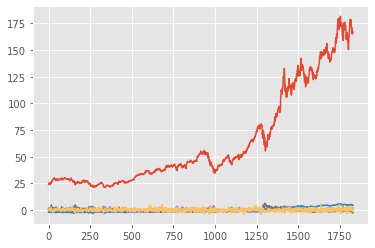

In [ ]:
plt.plot(finalDf)

###Split into Training and Test Set and scaling

In [ ]:
from sklearn.model_selection import train_test_split
sc = MinMaxScaler()

train, test = train_test_split(finalDf, test_size=0.3, shuffle = False)

In [ ]:
train = sc.fit_transform(train)

X_train = []
y_train = []
for i in range(DAYS, len(train)):
    X_train.append(train[i-DAYS:i])
    y_train.append(train[:, 0][i])
X_train, y_train = np.array(X_train), np.array(y_train)

print('Training set shape', X_train.shape, y_train.shape)

Training set shape (1251, 30, 5) (1251,)


In [ ]:
test = sc.fit_transform(test)

X_test, y_test = [], []
for i in range(DAYS, len(test)):
    X_test.append(test[i-DAYS:i])
    y_test.append(test[:, 0][i])    
X_test, y_test = np.array(X_test), np.array(y_test) 

print('Test set shape', X_test.shape, y_test.shape)

Test set shape (519, 30, 5) (519,)


###Definitions to train, evaluate, and plot

In [ ]:
#Build and train the model
def fit_model(train,val,timesteps,hl,lr,batch,epochs):
    X_train = []
    Y_train = []
    X_val = []
    Y_val = []
  
    for i in range(timesteps,train.shape[0]):
        X_train.append(train[i-timesteps:i])
        Y_train.append(train[i][0])
    X_train,Y_train = np.array(X_train),np.array(Y_train)
  
    for i in range(timesteps,val.shape[0]):
        X_val.append(val[i-timesteps:i])
        Y_val.append(val[i][0])
    X_val,Y_val = np.array(X_val),np.array(Y_val)
    
    # Adding Layers to the model
    model = Sequential()
    model.add(LSTM(X_train.shape[2],input_shape = (X_train.shape[1],X_train.shape[2]),return_sequences = True,
                   activation = 'relu'))
    for i in range(len(hl)-1):        
        model.add(LSTM(hl[i],activation = 'relu',return_sequences = True))
    model.add(LSTM(hl[-1],activation = 'relu'))
    model.add(Dense(1))
    model.compile(optimizer = 'adam', loss = 'mean_squared_error')
  
    # Training the data
    history = model.fit(X_train,Y_train,epochs = epochs,batch_size = batch,validation_data = (X_val, Y_val),verbose = 0,
                        shuffle = False, callbacks=[checkpointer])
    model.reset_states()
    return model, history.history['loss'], history.history['val_loss']

In [ ]:
# Evaluating the model
def evaluate_model(model,test,timesteps):
    X_test = []
    Y_test = []

    for i in range(timesteps,test.shape[0]):
        X_test.append(test[i-timesteps:i])
        Y_test.append(test[i][0])
    X_test,Y_test = np.array(X_test),np.array(Y_test)
  
    Y_hat = model.predict(X_test)
    mse = mean_squared_error(Y_test,Y_hat)
    rmse = sqrt(mse)
    r = r2_score(Y_test,Y_hat)
    return mse, rmse, r, Y_test, Y_hat

###Plot Functions

In [ ]:
# Plotting the predictions
def plot_data(Y_test,Y_hat):
    plt.plot(Y_test,c = 'g')
    plt.plot(Y_hat,c = 'c')
    plt.xlabel('Day')
    plt.ylabel('Price')
    plt.title(ticker + ' Stock Prediction Graph LSTM model')
    plt.legend(['Actual','Predicted'],loc = 'lower right')
    plt.show()

In [ ]:
# Plotting the training errors
def plot_error(train_loss,val_loss):
    plt.plot(train_loss,c = 'r')
    plt.plot(val_loss,c = 'b')
    plt.ylabel('Loss')
    plt.legend(['train','val'],loc = 'upper right')
    plt.show()

###Set up callback and Hyperparams

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint('/content/drive/MyDrive/Final Project Files/LSTM_Weights_'+ticker+'.hdf5', save_weights_only=True, save_best_only=True, verbose=1)

timesteps = DAYS
hl = [40,35]
lr = 1e-4
batch_size = 32
num_epochs = 30

###Train model

In [ ]:

model,train_error,test_error = fit_model(train,test,timesteps,hl,lr,batch_size,num_epochs)


Epoch 1: val_loss improved from inf to 0.03006, saving model to /content/drive/MyDrive/Final Project Files/LSTM_Weights_AAPL.hdf5

Epoch 2: val_loss did not improve from 0.03006

Epoch 3: val_loss did not improve from 0.03006

Epoch 4: val_loss did not improve from 0.03006

Epoch 5: val_loss did not improve from 0.03006

Epoch 6: val_loss improved from 0.03006 to 0.01533, saving model to /content/drive/MyDrive/Final Project Files/LSTM_Weights_AAPL.hdf5

Epoch 7: val_loss improved from 0.01533 to 0.01345, saving model to /content/drive/MyDrive/Final Project Files/LSTM_Weights_AAPL.hdf5

Epoch 8: val_loss improved from 0.01345 to 0.01188, saving model to /content/drive/MyDrive/Final Project Files/LSTM_Weights_AAPL.hdf5

Epoch 9: val_loss did not improve from 0.01188

Epoch 10: val_loss did not improve from 0.01188

Epoch 11: val_loss improved from 0.01188 to 0.00895, saving model to /content/drive/MyDrive/Final Project Files/LSTM_Weights_AAPL.hdf5

Epoch 12: val_loss did not improve fro

##Results

###Plot of Loss through each Epoch

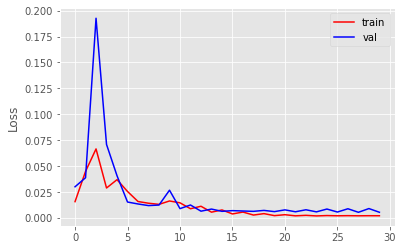

In [ ]:
plot_error(train_error,test_error)

###Prediction on Training set

MSE = 0.0038315756287187193
RMSE = 0.06189972236382583
R-Squared Score = 0.9176583705692496


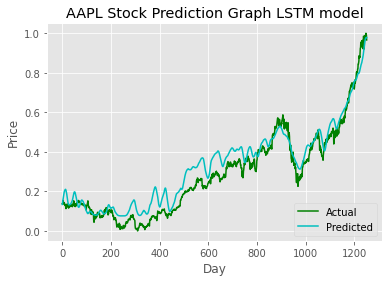

In [ ]:
mse, rmse, r2_value,true,predicted = evaluate_model(model,train,timesteps)
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))
plot_data(true,predicted)

###Prediction on Test Set

MSE = 0.005438510056075787
RMSE = 0.0737462545223538
R-Squared Score = 0.8952534885723706


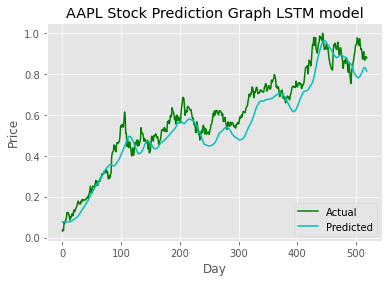

In [ ]:
mse, rmse, r2_value,true,predicted = evaluate_model(model,test,timesteps)
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))
plot_data(true,predicted)

#Google

##Data Load, Preprocessing, and Modeling

###Information Load and Dataframe setup

In [ ]:
ticker = 'GOOGL'

In [ ]:
!rm -rf '/content/drive/MyDrive/Final Project Files/LSTM_Weights_'+ticker.hdf5

In [ ]:
start_date = '2014-12-08'
end_date = '2022-04-22'

yahoo_financials = YahooFinancials(ticker)
data = yahoo_financials.get_historical_price_data(start_date=start_date, 
                                                  end_date=end_date, 
                                                  time_interval='daily')
df = pd.DataFrame(data[ticker]['prices'])
df = df.drop('date', axis=1).set_index('formatted_date')
#df = df.reset_index()
#df = df.rename(columns={"formatted_date": "Date"})
df = df.dropna()

# Define periods
k_period = 14
d_period = 3
# Adds a "n_high" column with max value of previous 14 periods
df['n_high'] = df['high'].rolling(k_period).max()
# Adds an "n_low" column with min value of previous 14 periods
df['n_low'] = df['low'].rolling(k_period).min()
# Uses the min/max values to calculate the %k (as a percentage)
df['%K'] = (df['adjclose'] - df['n_low']) * 100 / (df['n_high'] - df['n_low'])
# Uses the %k to calculates a SMA over the past 3 values of %k
df['%D'] = df['%K'].rolling(d_period).mean()


# Add some indicators
df.ta.stoch(high='high', low='low', k=14, d=3, append=True)

df = df.dropna()
df = df.drop(['n_high', 'n_low', '%K', '%D'], axis=1)
df = df.rename(columns={"STOCHk_14_3_3": "Fast Osc. Signal", "STOCHd_14_3_3": "Slow Osc. Signal"})

df['Volume_lag'] = df['volume'].shift(1)
df['High_lag'] = df['high'].shift(1)
df['Low_lag'] = df['low'].shift(1)
df['Open_lag'] = df['open'].shift(1)
df['Adj_Close_lag'] = df['adjclose'].shift(1)
df['Fast Osc. Lag'] = df['Fast Osc. Signal'].shift(1)
df['Slow Osc. Lag'] = df['Slow Osc. Signal'].shift(1)
df = df.drop(['volume'], axis=1)
df = df.drop(['close'], axis=1)
df = df.drop(['low'], axis=1)
df = df.drop(['high'], axis=1)
df = df.drop(['open'], axis=1)
df = df.drop(['Fast Osc. Signal'], axis=1)
df = df.drop(['Slow Osc. Signal'], axis=1)
print(df)

                   adjclose  Volume_lag     High_lag      Low_lag  \
formatted_date                                                      
2015-01-02       529.549988         NaN          NaN          NaN   
2015-01-05       519.460022   1324000.0   535.799988   527.880005   
2015-01-06       506.640015   2059100.0   527.989990   517.750000   
2015-01-07       505.149994   2722800.0   521.210022   505.549988   
2015-01-08       506.910004   2345900.0   511.489990   503.649994   
...                     ...         ...          ...          ...   
2022-04-14      2534.600098   1396400.0  2606.679932  2554.820068   
2022-04-18      2553.530029   1576500.0  2609.590088  2532.020020   
2022-04-19      2600.179932   1040400.0  2564.250000  2523.639893   
2022-04-20      2560.800049   1324500.0  2606.659912  2539.989990   
2022-04-21      2496.290039   1584800.0  2627.979980  2550.000000   

                   Open_lag  Adj_Close_lag  Fast Osc. Lag  Slow Osc. Lag  
formatted_date             

In [ ]:
# Get 30 year Bond Yield
yahoo_financials = YahooFinancials('^TYX')
data = yahoo_financials.get_historical_price_data(start_date=start_date, 
                                                  end_date=end_date, 
                                                  time_interval='daily')
yield_30yr = pd.DataFrame(data['^TYX']['prices'])
yield_30yr = yield_30yr.drop('date', axis=1).set_index('formatted_date')
#yield_30yr = yield_30yr.reset_index()
#yield_df = yield_30yr.rename(columns={"formatted_date": "Date"})
yield_df = yield_30yr.filter(['close'], axis=1)
yield_df = yield_df.dropna()
yield_df = yield_df.rename(columns={"close": "Bond_Yield"})
yield_df['Bond_Yield_Lag'] = yield_df['Bond_Yield'].shift(1)
yield_df = yield_df.drop(['Bond_Yield'], axis=1)
print(yield_df)

# Get Market Sentiment index
yahoo_financials = YahooFinancials('^VIX')
data = yahoo_financials.get_historical_price_data(start_date=start_date, 
                                                  end_date=end_date, 
                                                  time_interval='daily')
vix_df = pd.DataFrame(data['^VIX']['prices'])
vix_df = vix_df.drop('date', axis=1).set_index('formatted_date')
#vix_df = vix_df.reset_index()
#vix_df = vix_df.rename(columns={"formatted_date": "Date"})
vix_df = vix_df.filter(['close'], axis=1)
vix_df = vix_df.dropna()
vix_df = vix_df.rename(columns={"close": "VIX"})
vix_df['VIX_Lag'] = vix_df['VIX'].shift(1)
vix_df = vix_df.drop(['VIX'], axis = 1)
print(vix_df)


# Get Wilshire 5000 index
yahoo_financials = YahooFinancials('^W5000')
data = yahoo_financials.get_historical_price_data(start_date=start_date, 
                                                 end_date=end_date, 
                                                  time_interval='daily')
w5000 = pd.DataFrame(data['^W5000']['prices'])
w5000 = w5000.drop('date', axis=1).set_index('formatted_date')
#w5000 = w5000.reset_index()
#w5000 = w5000.rename(columns={"formatted_date": "Date"})
w5000 = w5000.filter(['close'], axis=1)
w5000 = w5000.dropna()
w5000 = w5000.rename(columns={"close": "Wilshire"})
w5000['Wilshire_Lag'] = w5000['Wilshire'].shift(1)
w5000 = w5000.drop(['Wilshire'], axis = 1)
print(w5000)

                Bond_Yield_Lag
formatted_date                
2014-12-08                 NaN
2014-12-09               2.901
2014-12-10               2.875
2014-12-11               2.835
2014-12-12               2.825
...                        ...
2022-04-14               2.794
2022-04-18               2.919
2022-04-19               2.953
2022-04-20               2.990
2022-04-21               2.879

[1854 rows x 1 columns]
                  VIX_Lag
formatted_date           
2014-12-08            NaN
2014-12-09      14.210000
2014-12-10      15.350000
2014-12-11      18.530001
2014-12-12      20.080000
...                   ...
2022-04-14      21.820000
2022-04-18      22.700001
2022-04-19      22.170000
2022-04-20      21.370001
2022-04-21      20.320000

[1856 rows x 1 columns]
                Wilshire_Lag
formatted_date              
2014-12-08               NaN
2014-12-09      21581.910156
2014-12-10      21536.179688
2014-12-11      21244.730469
2014-12-12      21338.890625
...   

In [ ]:
economic_df = yield_df.join(vix_df, on ='formatted_date')
economic_df = economic_df.join(w5000, on="formatted_date")
print(economic_df)

                Bond_Yield_Lag    VIX_Lag  Wilshire_Lag
formatted_date                                         
2014-12-08                 NaN        NaN           NaN
2014-12-09               2.901  14.210000  21581.910156
2014-12-10               2.875  15.350000  21536.179688
2014-12-11               2.835  18.530001  21244.730469
2014-12-12               2.825  20.080000  21338.890625
...                        ...        ...           ...
2022-04-14               2.794  21.820000  44732.468750
2022-04-18               2.919  22.700001  44180.851562
2022-04-19               2.953  22.170000  44086.601562
2022-04-20               2.990  21.370001  44967.039062
2022-04-21               2.879  20.320000  44774.980469

[1854 rows x 3 columns]


In [ ]:
df = df.join(economic_df,how='left', on = "formatted_date")

In [ ]:
sentiment_df = pd.read_csv('/content/drive/MyDrive/Final Project Files/'+ticker+'_Output.csv')
sentiment_df['formatted_date'] = sentiment_df['Date']
sentiment_df = sentiment_df.drop('Date', axis=1)
sentiment_df = sentiment_df.set_index('formatted_date')

In [ ]:
df = df.join(sentiment_df,how='left', on = "formatted_date")
df['Score_lag'] = df['Score_lag'].fillna(0)
df = df.iloc[1: , :]
print(df)

                   adjclose  Volume_lag     High_lag      Low_lag  \
formatted_date                                                      
2015-01-05       519.460022   1324000.0   535.799988   527.880005   
2015-01-06       506.640015   2059100.0   527.989990   517.750000   
2015-01-07       505.149994   2722800.0   521.210022   505.549988   
2015-01-08       506.910004   2345900.0   511.489990   503.649994   
2015-01-09       500.720001   3652700.0   507.500000   495.019989   
...                     ...         ...          ...          ...   
2022-04-14      2534.600098   1396400.0  2606.679932  2554.820068   
2022-04-18      2553.530029   1576500.0  2609.590088  2532.020020   
2022-04-19      2600.179932   1040400.0  2564.250000  2523.639893   
2022-04-20      2560.800049   1324500.0  2606.659912  2539.989990   
2022-04-21      2496.290039   1584800.0  2627.979980  2550.000000   

                   Open_lag  Adj_Close_lag  Fast Osc. Lag  Slow Osc. Lag  \
formatted_date            

In [ ]:
df

,adjclose,Volume_lag,High_lag,Low_lag,Open_lag,Adj_Close_lag,Fast Osc. Lag,Slow Osc. Lag,Bond_Yield_Lag,VIX_Lag,Wilshire_Lag,Score_lag
formatted_date,,,,,,,,,,,,
2015-01-05,519.460022,1324000.0,535.799988,527.880005,532.599976,529.549988,74.112113,80.538805,2.697,17.790001,21665.320312,0.0000
2015-01-06,506.640015,2059100.0,527.989990,517.750000,527.150024,519.460022,62.829835,72.196076,2.605,19.920000,21269.060547,0.0000
2015-01-07,505.149994,2722800.0,521.210022,505.549988,520.500000,506.640015,45.699637,60.880528,2.523,21.120001,21060.250000,0.0000
2015-01-08,506.910004,2345900.0,511.489990,503.649994,510.950012,505.149994,27.113670,45.214380,2.515,19.309999,21301.669922,0.2263
2015-01-09,500.720001,3652700.0,507.500000,495.019989,501.510010,506.910004,19.334796,30.716034,2.593,17.010000,21672.390625,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-14,2534.600098,1396400.0,2606.679932,2554.820068,2560.000000,2597.879883,8.242416,6.297824,2.794,21.820000,44732.468750,0.0000
2022-04-18,2553.530029,1576500.0,2609.590088,2532.020020,2609.590088,2534.600098,8.150951,6.513474,2.919,22.700001,44180.851562,0.1280
2022-04-19,2600.179932,1040400.0,2564.250000,2523.639893,2540.000000,2553.530029,9.165380,8.519582,2.953,22.170000,44086.601562,0.0000


In [ ]:
df = df.dropna()
df.corr()['adjclose']

adjclose          1.000000
Volume_lag       -0.166655
High_lag          0.999139
Low_lag           0.999156
Open_lag          0.998928
Adj_Close_lag     0.999297
Fast Osc. Lag     0.072436
Slow Osc. Lag     0.075140
Bond_Yield_Lag   -0.512799
VIX_Lag           0.248870
Wilshire_Lag      0.979971
Score_lag         0.087253
Name: adjclose, dtype: float64

In [ ]:
df_pca = df

In [ ]:
df_pca

,adjclose,Volume_lag,High_lag,Low_lag,Open_lag,Adj_Close_lag,Fast Osc. Lag,Slow Osc. Lag,Bond_Yield_Lag,VIX_Lag,Wilshire_Lag,Score_lag
formatted_date,,,,,,,,,,,,
2015-01-05,519.460022,1324000.0,535.799988,527.880005,532.599976,529.549988,74.112113,80.538805,2.697,17.790001,21665.320312,0.0000
2015-01-06,506.640015,2059100.0,527.989990,517.750000,527.150024,519.460022,62.829835,72.196076,2.605,19.920000,21269.060547,0.0000
2015-01-07,505.149994,2722800.0,521.210022,505.549988,520.500000,506.640015,45.699637,60.880528,2.523,21.120001,21060.250000,0.0000
2015-01-08,506.910004,2345900.0,511.489990,503.649994,510.950012,505.149994,27.113670,45.214380,2.515,19.309999,21301.669922,0.2263
2015-01-09,500.720001,3652700.0,507.500000,495.019989,501.510010,506.910004,19.334796,30.716034,2.593,17.010000,21672.390625,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-14,2534.600098,1396400.0,2606.679932,2554.820068,2560.000000,2597.879883,8.242416,6.297824,2.794,21.820000,44732.468750,0.0000
2022-04-18,2553.530029,1576500.0,2609.590088,2532.020020,2609.590088,2534.600098,8.150951,6.513474,2.919,22.700001,44180.851562,0.1280
2022-04-19,2600.179932,1040400.0,2564.250000,2523.639893,2540.000000,2553.530029,9.165380,8.519582,2.953,22.170000,44086.601562,0.0000


###Running PCA to reduce variables

In [ ]:
from sklearn.preprocessing import StandardScaler
features = ['Volume_lag', 'High_lag', 'Low_lag', 'Open_lag', 'Adj_Close_lag',
            'Fast Osc. Lag', 'Slow Osc. Lag', 'Bond_Yield_Lag', 'VIX_Lag',
            'Wilshire_Lag', 'Score_lag']
# Separating out the features
x = df_pca.loc[:, features].values
# Separating out the target
y = df_pca.loc[:,['adjclose']].values
# Standardizing the features
x = StandardScaler().fit_transform(x)
x

array([[-0.56730119, -1.15728319, -1.15523182, ..., -0.03987629,
        -1.02386581, -0.16384764],
       [ 0.24893606, -1.16905333, -1.17082326, ...,  0.2318808 ,
        -1.07289718, -0.16384764],
       [ 0.98589248, -1.17927116, -1.18960073, ...,  0.38498355,
        -1.09873444, -0.16384764],
       ...,
       [-0.88220377,  1.8997152 ,  1.91651222, ...,  0.51894827,
         1.75044113, -0.16384764],
       [-0.566746  ,  1.96362954,  1.94167723, ...,  0.41687994,
         1.85938244, -2.78736825],
       [-0.27771518,  1.99576019,  1.95708399, ...,  0.28291497,
         1.83561799, -2.44332227]])

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=4)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['PC 1', 'PC 2', 'PC 3', 'PC 4'])
principalDf

,PC 1,PC 2,PC 3,PC 4
0,-2.394124,-1.022556,0.446898,-0.184539
1,-2.450746,-0.231331,0.868102,-0.069047
2,-2.530497,0.701784,1.067324,0.035049
3,-2.550994,1.311287,0.265961,0.724434
4,-2.808692,2.085448,0.569588,0.206285
...,...,...,...,...
1825,3.888456,2.452804,-2.251437,-0.327446
1826,3.796483,2.507634,-2.195561,0.141596
1827,3.731135,2.266125,-2.492333,-0.377009
1828,3.684690,2.305059,-2.253010,-2.910149


###Merging PCA to Adjust Close Price

In [ ]:
df_adjclose = df.reset_index()
df_adjclose = df_adjclose.rename(columns={"formatted_date": "Date"})
df_adjclose = df_adjclose[['adjclose']]
df_adjclose

,adjclose
0,519.460022
1,506.640015
2,505.149994
3,506.910004
4,500.720001
...,...
1825,2534.600098
1826,2553.530029
1827,2600.179932
1828,2560.800049


In [ ]:
finalDf = pd.merge(df_adjclose, principalDf, left_index=True, right_index=True)
finalDf

,adjclose,PC 1,PC 2,PC 3,PC 4
0,519.460022,-2.394124,-1.022556,0.446898,-0.184539
1,506.640015,-2.450746,-0.231331,0.868102,-0.069047
2,505.149994,-2.530497,0.701784,1.067324,0.035049
3,506.910004,-2.550994,1.311287,0.265961,0.724434
4,500.720001,-2.808692,2.085448,0.569588,0.206285
...,...,...,...,...,...
1825,2534.600098,3.888456,2.452804,-2.251437,-0.327446
1826,2553.530029,3.796483,2.507634,-2.195561,0.141596
1827,2600.179932,3.731135,2.266125,-2.492333,-0.377009
1828,2560.800049,3.684690,2.305059,-2.253010,-2.910149


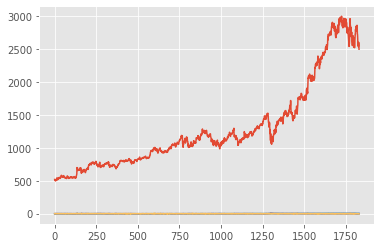

In [ ]:
plt.plot(finalDf)

###Split into Training and Test Set and scaling

In [ ]:
from sklearn.model_selection import train_test_split
sc = MinMaxScaler()

train, test = train_test_split(finalDf, test_size=0.3, shuffle = False)

In [ ]:
train = sc.fit_transform(train)

X_train = []
y_train = []
for i in range(DAYS, len(train)):
    X_train.append(train[i-DAYS:i]) # Chunks of training data with a length of 128 df-rows
    y_train.append(train[:, 0][i])
X_train, y_train = np.array(X_train), np.array(y_train)

print('Training set shape', X_train.shape, y_train.shape)

test = sc.fit_transform(test)

X_test, y_test = [], []
for i in range(DAYS, len(test)):
    X_test.append(test[i-DAYS:i])
    y_test.append(test[:, 0][i])    
X_test, y_test = np.array(X_test), np.array(y_test) 

print('Test set shape', X_test.shape, y_test.shape)

Training set shape (1251, 30, 5) (1251,)
Test set shape (519, 30, 5) (519,)


###Definitions to train, evaluate, and plot

In [ ]:
#Build and train the model
def fit_model(train,val,timesteps,hl,lr,batch,epochs):
    X_train = []
    Y_train = []
    X_val = []
    Y_val = []
  
    for i in range(timesteps,train.shape[0]):
        X_train.append(train[i-timesteps:i])
        Y_train.append(train[i][0])
    X_train,Y_train = np.array(X_train),np.array(Y_train)
  
    for i in range(timesteps,val.shape[0]):
        X_val.append(val[i-timesteps:i])
        Y_val.append(val[i][0])
    X_val,Y_val = np.array(X_val),np.array(Y_val)
    
    # Adding Layers to the model
    model = Sequential()
    model.add(LSTM(X_train.shape[2],input_shape = (X_train.shape[1],X_train.shape[2]),return_sequences = True,
                   activation = 'relu'))
    for i in range(len(hl)-1):        
        model.add(LSTM(hl[i],activation = 'relu',return_sequences = True))
    model.add(LSTM(hl[-1],activation = 'relu'))
    model.add(Dense(1))
    model.compile(optimizer = 'adam', loss = 'mean_squared_error')
  
    # Training the data
    history = model.fit(X_train,Y_train,epochs = epochs,batch_size = batch,validation_data = (X_val, Y_val),verbose = 0,
                        shuffle = False, callbacks=[checkpointer])
    model.reset_states()
    return model, history.history['loss'], history.history['val_loss']

In [ ]:
# Evaluating the model
def evaluate_model(model,test,timesteps):
    X_test = []
    Y_test = []

    for i in range(timesteps,test.shape[0]):
        X_test.append(test[i-timesteps:i])
        Y_test.append(test[i][0])
    X_test,Y_test = np.array(X_test),np.array(Y_test)
  
    Y_hat = model.predict(X_test)
    mse = mean_squared_error(Y_test,Y_hat)
    rmse = sqrt(mse)
    r = r2_score(Y_test,Y_hat)
    return mse, rmse, r, Y_test, Y_hat

In [ ]:
# Plotting the predictions
def plot_data(Y_test,Y_hat):
    plt.plot(Y_test,c = 'g')
    plt.plot(Y_hat,c = 'c')
    plt.xlabel('Day')
    plt.ylabel('Price')
    plt.title(ticker + ' Stock Prediction Graph LSTM model')
    plt.legend(['Actual','Predicted'],loc = 'lower right')
    plt.show()

In [ ]:
# Plotting the training errors
def plot_error(train_loss,val_loss):
    plt.plot(train_loss,c = 'r')
    plt.plot(val_loss,c = 'b')
    plt.ylabel('Loss')
    plt.legend(['train','val'],loc = 'upper right')
    plt.show()

###Set up callback

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint('/content/drive/MyDrive/Final Project Files/LSTM_Weights_'+ticker+'.hdf5', save_weights_only=True, save_best_only=True, verbose=1)

###Set hyper parameters and train model

In [ ]:
#timesteps = DAYS
#hl = [40,35]
#lr = 1e-4
#batch_size = 32
#num_epochs = 30

model,train_error,test_error = fit_model(train,test,timesteps,hl,lr,batch_size,num_epochs)


Epoch 1: val_loss improved from inf to 0.02487, saving model to /content/drive/MyDrive/Final Project Files/LSTM_Weights_GOOGL.hdf5

Epoch 2: val_loss did not improve from 0.02487

Epoch 3: val_loss improved from 0.02487 to 0.02071, saving model to /content/drive/MyDrive/Final Project Files/LSTM_Weights_GOOGL.hdf5

Epoch 4: val_loss improved from 0.02071 to 0.01714, saving model to /content/drive/MyDrive/Final Project Files/LSTM_Weights_GOOGL.hdf5

Epoch 5: val_loss improved from 0.01714 to 0.00610, saving model to /content/drive/MyDrive/Final Project Files/LSTM_Weights_GOOGL.hdf5

Epoch 6: val_loss improved from 0.00610 to 0.00555, saving model to /content/drive/MyDrive/Final Project Files/LSTM_Weights_GOOGL.hdf5

Epoch 7: val_loss improved from 0.00555 to 0.00543, saving model to /content/drive/MyDrive/Final Project Files/LSTM_Weights_GOOGL.hdf5

Epoch 8: val_loss improved from 0.00543 to 0.00528, saving model to /content/drive/MyDrive/Final Project Files/LSTM_Weights_GOOGL.hdf5

Epo

##Results

###Plot of Loss through each Epoch

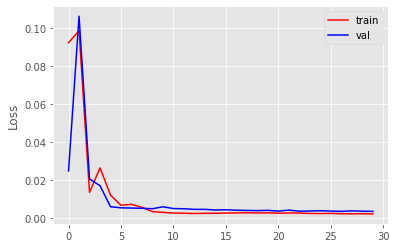

In [ ]:
plot_error(train_error,test_error)

###Prediction on Training set

MSE = 0.0019833680305533547
RMSE = 0.04453502027116811
R-Squared Score = 0.9613818452174809


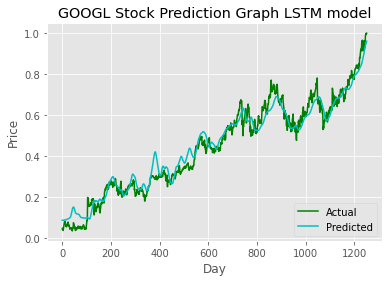

In [ ]:

mse, rmse, r2_value,true,predicted = evaluate_model(model,train,timesteps)
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))
plot_data(true,predicted)

###Prediction on Test Set

MSE = 0.003679998223526867
RMSE = 0.06066298891026445
R-Squared Score = 0.9568929538441899


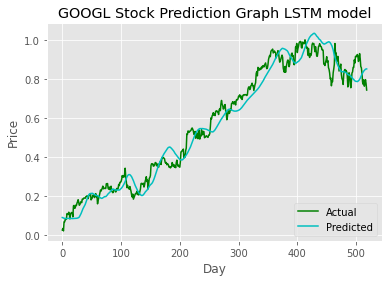

In [ ]:
mse, rmse, r2_value,true,predicted = evaluate_model(model,test,timesteps)
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))
plot_data(true,predicted)

#Nvidia

##Data Load, Preprocessing, and Modeling

###Information Load and Dataframe setup

In [ ]:
ticker = 'NVDA'

In [ ]:
!rm -rf '/content/drive/MyDrive/Final Project Files/LSTM_Weights_'+ticker.hdf5

In [ ]:
start_date = '2014-12-08'
end_date = '2022-04-22'

yahoo_financials = YahooFinancials(ticker)
data = yahoo_financials.get_historical_price_data(start_date=start_date, 
                                                  end_date=end_date, 
                                                  time_interval='daily')
df = pd.DataFrame(data[ticker]['prices'])
df = df.drop('date', axis=1).set_index('formatted_date')
#df = df.reset_index()
#df = df.rename(columns={"formatted_date": "Date"})
df = df.dropna()

# Define periods
k_period = 14
d_period = 3
# Adds a "n_high" column with max value of previous 14 periods
df['n_high'] = df['high'].rolling(k_period).max()
# Adds an "n_low" column with min value of previous 14 periods
df['n_low'] = df['low'].rolling(k_period).min()
# Uses the min/max values to calculate the %k (as a percentage)
df['%K'] = (df['adjclose'] - df['n_low']) * 100 / (df['n_high'] - df['n_low'])
# Uses the %k to calculates a SMA over the past 3 values of %k
df['%D'] = df['%K'].rolling(d_period).mean()


# Add some indicators
df.ta.stoch(high='high', low='low', k=14, d=3, append=True)

df = df.dropna()
df = df.drop(['n_high', 'n_low', '%K', '%D'], axis=1)
df = df.rename(columns={"STOCHk_14_3_3": "Fast Osc. Signal", "STOCHd_14_3_3": "Slow Osc. Signal"})

df['Volume_lag'] = df['volume'].shift(1)
df['High_lag'] = df['high'].shift(1)
df['Low_lag'] = df['low'].shift(1)
df['Open_lag'] = df['open'].shift(1)
df['Adj_Close_lag'] = df['adjclose'].shift(1)
df['Fast Osc. Lag'] = df['Fast Osc. Signal'].shift(1)
df['Slow Osc. Lag'] = df['Slow Osc. Signal'].shift(1)
df = df.drop(['volume'], axis=1)
df = df.drop(['close'], axis=1)
df = df.drop(['low'], axis=1)
df = df.drop(['high'], axis=1)
df = df.drop(['open'], axis=1)
df = df.drop(['Fast Osc. Signal'], axis=1)
df = df.drop(['Slow Osc. Signal'], axis=1)
print(df)

                  adjclose  Volume_lag    High_lag     Low_lag    Open_lag  \
formatted_date                                                               
2015-01-02        4.838646         NaN         NaN         NaN         NaN   
2015-01-05        4.756920  11368000.0    5.070000    4.952500    5.032500   
2015-01-06        4.612700  19795200.0    5.047500    4.925000    5.032500   
2015-01-07        4.600680  19776400.0    4.960000    4.792500    4.955000   
2015-01-08        4.773746  32180800.0    4.875000    4.770000    4.832500   
...                    ...         ...         ...         ...         ...   
2022-04-14      212.580002  51694300.0  225.000000  214.550003  217.279999   
2022-04-18      217.830002  56822500.0  227.770004  211.630005  225.050003   
2022-04-19      221.979996  52570100.0  220.880005  210.789993  212.000000   
2022-04-20      214.820007  51278100.0  223.729996  213.139999  217.199997   
2022-04-21      201.830002  46897400.0  226.699997  212.000000  

In [ ]:
# Get 30 year Bond Yield
yahoo_financials = YahooFinancials('^TYX')
data = yahoo_financials.get_historical_price_data(start_date=start_date, 
                                                  end_date=end_date, 
                                                  time_interval='daily')
yield_30yr = pd.DataFrame(data['^TYX']['prices'])
yield_30yr = yield_30yr.drop('date', axis=1).set_index('formatted_date')
#yield_30yr = yield_30yr.reset_index()
#yield_df = yield_30yr.rename(columns={"formatted_date": "Date"})
yield_df = yield_30yr.filter(['close'], axis=1)
yield_df = yield_df.dropna()
yield_df = yield_df.rename(columns={"close": "Bond_Yield"})
yield_df['Bond_Yield_Lag'] = yield_df['Bond_Yield'].shift(1)
yield_df = yield_df.drop(['Bond_Yield'], axis=1)
print(yield_df)

# Get Market Sentiment index
yahoo_financials = YahooFinancials('^VIX')
data = yahoo_financials.get_historical_price_data(start_date=start_date, 
                                                  end_date=end_date, 
                                                  time_interval='daily')
vix_df = pd.DataFrame(data['^VIX']['prices'])
vix_df = vix_df.drop('date', axis=1).set_index('formatted_date')
#vix_df = vix_df.reset_index()
#vix_df = vix_df.rename(columns={"formatted_date": "Date"})
vix_df = vix_df.filter(['close'], axis=1)
vix_df = vix_df.dropna()
vix_df = vix_df.rename(columns={"close": "VIX"})
vix_df['VIX_Lag'] = vix_df['VIX'].shift(1)
vix_df = vix_df.drop(['VIX'], axis = 1)
print(vix_df)


# Get Wilshire 5000 index
yahoo_financials = YahooFinancials('^W5000')
data = yahoo_financials.get_historical_price_data(start_date=start_date, 
                                                 end_date=end_date, 
                                                  time_interval='daily')
w5000 = pd.DataFrame(data['^W5000']['prices'])
w5000 = w5000.drop('date', axis=1).set_index('formatted_date')
#w5000 = w5000.reset_index()
#w5000 = w5000.rename(columns={"formatted_date": "Date"})
w5000 = w5000.filter(['close'], axis=1)
w5000 = w5000.dropna()
w5000 = w5000.rename(columns={"close": "Wilshire"})
w5000['Wilshire_Lag'] = w5000['Wilshire'].shift(1)
w5000 = w5000.drop(['Wilshire'], axis = 1)
print(w5000)

                Bond_Yield_Lag
formatted_date                
2014-12-08                 NaN
2014-12-09               2.901
2014-12-10               2.875
2014-12-11               2.835
2014-12-12               2.825
...                        ...
2022-04-14               2.794
2022-04-18               2.919
2022-04-19               2.953
2022-04-20               2.990
2022-04-21               2.879

[1854 rows x 1 columns]
                  VIX_Lag
formatted_date           
2014-12-08            NaN
2014-12-09      14.210000
2014-12-10      15.350000
2014-12-11      18.530001
2014-12-12      20.080000
...                   ...
2022-04-14      21.820000
2022-04-18      22.700001
2022-04-19      22.170000
2022-04-20      21.370001
2022-04-21      20.320000

[1856 rows x 1 columns]
                Wilshire_Lag
formatted_date              
2014-12-08               NaN
2014-12-09      21581.910156
2014-12-10      21536.179688
2014-12-11      21244.730469
2014-12-12      21338.890625
...   

In [ ]:
economic_df = yield_df.join(vix_df, on ='formatted_date')
economic_df = economic_df.join(w5000, on="formatted_date")
print(economic_df)

                Bond_Yield_Lag    VIX_Lag  Wilshire_Lag
formatted_date                                         
2014-12-08                 NaN        NaN           NaN
2014-12-09               2.901  14.210000  21581.910156
2014-12-10               2.875  15.350000  21536.179688
2014-12-11               2.835  18.530001  21244.730469
2014-12-12               2.825  20.080000  21338.890625
...                        ...        ...           ...
2022-04-14               2.794  21.820000  44732.468750
2022-04-18               2.919  22.700001  44180.851562
2022-04-19               2.953  22.170000  44086.601562
2022-04-20               2.990  21.370001  44967.039062
2022-04-21               2.879  20.320000  44774.980469

[1854 rows x 3 columns]


In [ ]:
df = df.join(economic_df,how='left', on = "formatted_date")

In [ ]:
sentiment_df = pd.read_csv('/content/drive/MyDrive/Final Project Files/'+ticker+'_Output.csv')
sentiment_df['formatted_date'] = sentiment_df['Date']
sentiment_df = sentiment_df.drop('Date', axis=1)
sentiment_df = sentiment_df.set_index('formatted_date')

In [ ]:
df = df.join(sentiment_df,how='left', on = "formatted_date")
df['Score_lag'] = df['Score_lag'].fillna(0)
df = df.iloc[1: , :]
print(df)

                  adjclose  Volume_lag    High_lag     Low_lag    Open_lag  \
formatted_date                                                               
2015-01-05        4.756920  11368000.0    5.070000    4.952500    5.032500   
2015-01-06        4.612700  19795200.0    5.047500    4.925000    5.032500   
2015-01-07        4.600680  19776400.0    4.960000    4.792500    4.955000   
2015-01-08        4.773746  32180800.0    4.875000    4.770000    4.832500   
2015-01-09        4.792975  28378000.0    4.995000    4.837500    4.840000   
...                    ...         ...         ...         ...         ...   
2022-04-14      212.580002  51694300.0  225.000000  214.550003  217.279999   
2022-04-18      217.830002  56822500.0  227.770004  211.630005  225.050003   
2022-04-19      221.979996  52570100.0  220.880005  210.789993  212.000000   
2022-04-20      214.820007  51278100.0  223.729996  213.139999  217.199997   
2022-04-21      201.830002  46897400.0  226.699997  212.000000  

In [ ]:
df

,adjclose,Volume_lag,High_lag,Low_lag,Open_lag,Adj_Close_lag,Fast Osc. Lag,Slow Osc. Lag,Bond_Yield_Lag,VIX_Lag,Wilshire_Lag,Score_lag
formatted_date,,,,,,,,,,,,
2015-01-05,4.756920,11368000.0,5.070000,4.952500,5.032500,4.838646,55.841876,63.026681,2.697,17.790001,21665.320312,0.0000
2015-01-06,4.612700,19795200.0,5.047500,4.925000,5.032500,4.756920,45.876245,54.982772,2.605,19.920000,21269.060547,0.0000
2015-01-07,4.600680,19776400.0,4.960000,4.792500,4.955000,4.612700,31.099639,44.272586,2.523,21.120001,21060.250000,0.0000
2015-01-08,4.773746,32180800.0,4.875000,4.770000,4.832500,4.600680,14.422469,30.466117,2.515,19.309999,21301.669922,0.0000
2015-01-09,4.792975,28378000.0,4.995000,4.837500,4.840000,4.773746,15.832104,20.451404,2.593,17.010000,21672.390625,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-14,212.580002,51694300.0,225.000000,214.550003,217.279999,222.029999,6.147053,4.853366,2.794,21.820000,44732.468750,0.4404
2022-04-18,217.830002,56822500.0,227.770004,211.630005,225.050003,212.580002,5.378154,4.663145,2.919,22.700001,44180.851562,0.4215
2022-04-19,221.979996,52570100.0,220.880005,210.789993,212.000000,217.830002,7.395535,6.306914,2.953,22.170000,44086.601562,0.0000


In [ ]:
df = df.dropna()
df.corr()['adjclose']

adjclose          1.000000
Volume_lag       -0.043643
High_lag          0.998636
Low_lag           0.998662
Open_lag          0.998184
Adj_Close_lag     0.998952
Fast Osc. Lag    -0.046163
Slow Osc. Lag    -0.044609
Bond_Yield_Lag   -0.516678
VIX_Lag           0.276356
Wilshire_Lag      0.949667
Score_lag         0.112345
Name: adjclose, dtype: float64

In [ ]:
df_pca = df

In [ ]:
df_pca

,adjclose,Volume_lag,High_lag,Low_lag,Open_lag,Adj_Close_lag,Fast Osc. Lag,Slow Osc. Lag,Bond_Yield_Lag,VIX_Lag,Wilshire_Lag,Score_lag
formatted_date,,,,,,,,,,,,
2015-01-05,4.756920,11368000.0,5.070000,4.952500,5.032500,4.838646,55.841876,63.026681,2.697,17.790001,21665.320312,0.0000
2015-01-06,4.612700,19795200.0,5.047500,4.925000,5.032500,4.756920,45.876245,54.982772,2.605,19.920000,21269.060547,0.0000
2015-01-07,4.600680,19776400.0,4.960000,4.792500,4.955000,4.612700,31.099639,44.272586,2.523,21.120001,21060.250000,0.0000
2015-01-08,4.773746,32180800.0,4.875000,4.770000,4.832500,4.600680,14.422469,30.466117,2.515,19.309999,21301.669922,0.0000
2015-01-09,4.792975,28378000.0,4.995000,4.837500,4.840000,4.773746,15.832104,20.451404,2.593,17.010000,21672.390625,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-14,212.580002,51694300.0,225.000000,214.550003,217.279999,222.029999,6.147053,4.853366,2.794,21.820000,44732.468750,0.4404
2022-04-18,217.830002,56822500.0,227.770004,211.630005,225.050003,212.580002,5.378154,4.663145,2.919,22.700001,44180.851562,0.4215
2022-04-19,221.979996,52570100.0,220.880005,210.789993,212.000000,217.830002,7.395535,6.306914,2.953,22.170000,44086.601562,0.0000


###Running PCA to reduce variables

In [ ]:
from sklearn.preprocessing import StandardScaler
features = ['Volume_lag', 'High_lag', 'Low_lag', 'Open_lag', 'Adj_Close_lag',
            'Fast Osc. Lag', 'Slow Osc. Lag', 'Bond_Yield_Lag', 'VIX_Lag',
            'Wilshire_Lag', 'Score_lag']
# Separating out the features
x = df_pca.loc[:, features].values
# Separating out the target
y = df_pca.loc[:,['adjclose']].values
# Standardizing the features
x = StandardScaler().fit_transform(x)
x

array([[-1.28683656, -0.90921326, -0.91479382, ..., -0.03987629,
        -1.02386581, -0.19796601],
       [-0.98418548, -0.9095112 , -0.91517441, ...,  0.2318808 ,
        -1.07289718, -0.19796601],
       [-0.98486065, -0.91066984, -0.91700817, ...,  0.38498355,
        -1.09873444, -0.19796601],
       ...,
       [ 0.19287915,  1.94845571,  1.93393454, ...,  0.51894827,
         1.75044113, -0.19796601],
       [ 0.14647878,  1.98619414,  1.96645792, ...,  0.41687994,
         1.85938244, -1.13605185],
       [-0.01084793,  2.0255217 ,  1.95068067, ...,  0.28291497,
         1.83561799, -0.19796601]])

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=4)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['PC 1', 'PC 2', 'PC 3', 'PC 4'])
principalDf

,PC 1,PC 2,PC 3,PC 4
0,-2.035966,0.166556,0.517493,-1.180043
1,-1.954223,0.704346,0.718293,-0.922140
2,-1.870687,1.374716,0.833219,-0.945865
3,-1.870880,2.125065,0.514938,-0.628371
4,-1.922173,2.270095,0.200780,-0.784983
...,...,...,...,...
1825,4.322780,2.512273,-1.483288,0.986223
1826,4.230064,2.607619,-1.565344,1.129474
1827,3.991572,2.735196,-1.831653,0.033320
1828,4.027737,2.772605,-2.090734,-0.476520


###Merging PCA to Adjust Close Price

In [ ]:
df_adjclose = df.reset_index()
df_adjclose = df_adjclose.rename(columns={"formatted_date": "Date"})
df_adjclose = df_adjclose[['adjclose']]
df_adjclose

,adjclose
0,4.756920
1,4.612700
2,4.600680
3,4.773746
4,4.792975
...,...
1825,212.580002
1826,217.830002
1827,221.979996
1828,214.820007


In [ ]:
finalDf = pd.merge(df_adjclose, principalDf, left_index=True, right_index=True)
finalDf

,adjclose,PC 1,PC 2,PC 3,PC 4
0,4.756920,-2.035966,0.166556,0.517493,-1.180043
1,4.612700,-1.954223,0.704346,0.718293,-0.922140
2,4.600680,-1.870687,1.374716,0.833219,-0.945865
3,4.773746,-1.870880,2.125065,0.514938,-0.628371
4,4.792975,-1.922173,2.270095,0.200780,-0.784983
...,...,...,...,...,...
1825,212.580002,4.322780,2.512273,-1.483288,0.986223
1826,217.830002,4.230064,2.607619,-1.565344,1.129474
1827,221.979996,3.991572,2.735196,-1.831653,0.033320
1828,214.820007,4.027737,2.772605,-2.090734,-0.476520


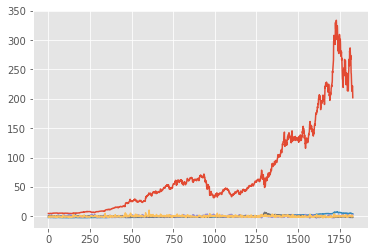

In [ ]:
plt.plot(finalDf)

###Split into Training and Test Set and scaling

In [ ]:
from sklearn.model_selection import train_test_split
sc = MinMaxScaler()

train, test = train_test_split(finalDf, test_size=0.3, shuffle = False)

In [ ]:
train = sc.fit_transform(train)

X_train = []
y_train = []
for i in range(DAYS, len(train)):
    X_train.append(train[i-DAYS:i]) # Chunks of training data with a length of 128 df-rows
    y_train.append(train[:, 0][i])
X_train, y_train = np.array(X_train), np.array(y_train)

print('Training set shape', X_train.shape, y_train.shape)

test = sc.fit_transform(test)

X_test, y_test = [], []
for i in range(DAYS, len(test)):
    X_test.append(test[i-DAYS:i])
    y_test.append(test[:, 0][i])    
X_test, y_test = np.array(X_test), np.array(y_test) 

print('Test set shape', X_test.shape, y_test.shape)

Training set shape (1251, 30, 5) (1251,)
Test set shape (519, 30, 5) (519,)


###Definitions to train, evaluate, and plot

In [ ]:
#Build and train the model
def fit_model(train,val,timesteps,hl,lr,batch,epochs):
    X_train = []
    Y_train = []
    X_val = []
    Y_val = []
  
    for i in range(timesteps,train.shape[0]):
        X_train.append(train[i-timesteps:i])
        Y_train.append(train[i][0])
    X_train,Y_train = np.array(X_train),np.array(Y_train)
  
    for i in range(timesteps,val.shape[0]):
        X_val.append(val[i-timesteps:i])
        Y_val.append(val[i][0])
    X_val,Y_val = np.array(X_val),np.array(Y_val)
    
    # Adding Layers to the model
    model = Sequential()
    model.add(LSTM(X_train.shape[2],input_shape = (X_train.shape[1],X_train.shape[2]),return_sequences = True,
                   activation = 'relu'))
    for i in range(len(hl)-1):        
        model.add(LSTM(hl[i],activation = 'relu',return_sequences = True))
    model.add(LSTM(hl[-1],activation = 'relu'))
    model.add(Dense(1))
    model.compile(optimizer = 'adam', loss = 'mean_squared_error')
  
    # Training the data
    history = model.fit(X_train,Y_train,epochs = epochs,batch_size = batch,validation_data = (X_val, Y_val),verbose = 0,
                        shuffle = False, callbacks=[checkpointer])
    model.reset_states()
    return model, history.history['loss'], history.history['val_loss']

In [ ]:
# Evaluating the model
def evaluate_model(model,test,timesteps):
    X_test = []
    Y_test = []

    for i in range(timesteps,test.shape[0]):
        X_test.append(test[i-timesteps:i])
        Y_test.append(test[i][0])
    X_test,Y_test = np.array(X_test),np.array(Y_test)
  
    Y_hat = model.predict(X_test)
    mse = mean_squared_error(Y_test,Y_hat)
    rmse = sqrt(mse)
    r = r2_score(Y_test,Y_hat)
    return mse, rmse, r, Y_test, Y_hat

In [ ]:
# Plotting the predictions
def plot_data(Y_test,Y_hat):
    plt.plot(Y_test,c = 'g')
    plt.plot(Y_hat,c = 'c')
    plt.xlabel('Day')
    plt.ylabel('Price')
    plt.title(ticker + ' Stock Prediction Graph LSTM model')
    plt.legend(['Actual','Predicted'],loc = 'lower right')
    plt.show()

In [ ]:
# Plotting the training errors
def plot_error(train_loss,val_loss):
    plt.plot(train_loss,c = 'r')
    plt.plot(val_loss,c = 'b')
    plt.ylabel('Loss')
    plt.legend(['train','val'],loc = 'upper right')
    plt.show()

###Set up callback

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint('/content/drive/MyDrive/Final Project Files/LSTM_Weights_'+ticker+'.hdf5', save_weights_only=True, save_best_only=True, verbose=1)

###Set hyper parameters and train model

In [ ]:
timesteps = DAYS
#hl = [40,35]
#lr = 1e-4
#batch_size = 32
#num_epochs = 30

model,train_error,test_error = fit_model(train,test,timesteps,hl,lr,batch_size,num_epochs)


Epoch 1: val_loss improved from inf to 0.06799, saving model to /content/drive/MyDrive/Final Project Files/LSTM_Weights_NVDA.hdf5

Epoch 2: val_loss improved from 0.06799 to 0.05443, saving model to /content/drive/MyDrive/Final Project Files/LSTM_Weights_NVDA.hdf5

Epoch 3: val_loss did not improve from 0.05443

Epoch 4: val_loss did not improve from 0.05443

Epoch 5: val_loss improved from 0.05443 to 0.03764, saving model to /content/drive/MyDrive/Final Project Files/LSTM_Weights_NVDA.hdf5

Epoch 6: val_loss did not improve from 0.03764

Epoch 7: val_loss improved from 0.03764 to 0.00523, saving model to /content/drive/MyDrive/Final Project Files/LSTM_Weights_NVDA.hdf5

Epoch 8: val_loss did not improve from 0.00523

Epoch 9: val_loss did not improve from 0.00523

Epoch 10: val_loss did not improve from 0.00523

Epoch 11: val_loss did not improve from 0.00523

Epoch 12: val_loss did not improve from 0.00523

Epoch 13: val_loss did not improve from 0.00523

Epoch 14: val_loss did not 

##Results

###Plot of Loss through each Epoch

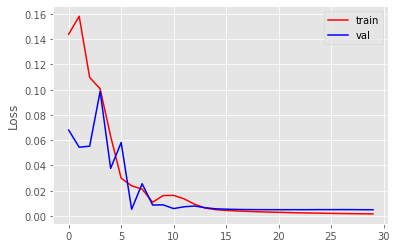

In [ ]:
plot_error(train_error,test_error)

###Prediction on Training set

MSE = 0.002513161329489385
RMSE = 0.05013144052876782
R-Squared Score = 0.9715074441417301


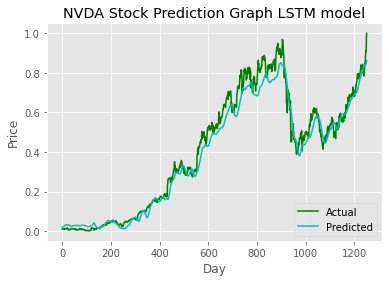

In [ ]:

mse, rmse, r2_value,true,predicted = evaluate_model(model,train,timesteps)
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))
plot_data(true,predicted)

###Prediction on Test Set

MSE = 0.004919072880911274
RMSE = 0.07013610255005102
R-Squared Score = 0.9102255344398007


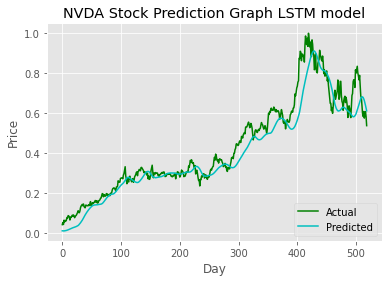

In [ ]:
mse, rmse, r2_value,true,predicted = evaluate_model(model,test,timesteps)
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))
plot_data(true,predicted)

#Costco

##Data Load, Preprocessing, and Modeling

###Information Load and Dataframe setup

In [ ]:
ticker = 'COST'

In [ ]:
!rm -rf '/content/drive/MyDrive/Final Project Files/LSTM_Weights_'+ticker.hdf5

In [ ]:
start_date = '2014-12-08'
end_date = '2022-04-22'

yahoo_financials = YahooFinancials(ticker)
data = yahoo_financials.get_historical_price_data(start_date=start_date, 
                                                  end_date=end_date, 
                                                  time_interval='daily')
df = pd.DataFrame(data[ticker]['prices'])
df = df.drop('date', axis=1).set_index('formatted_date')
#df = df.reset_index()
#df = df.rename(columns={"formatted_date": "Date"})
df = df.dropna()

# Define periods
k_period = 14
d_period = 3
# Adds a "n_high" column with max value of previous 14 periods
df['n_high'] = df['high'].rolling(k_period).max()
# Adds an "n_low" column with min value of previous 14 periods
df['n_low'] = df['low'].rolling(k_period).min()
# Uses the min/max values to calculate the %k (as a percentage)
df['%K'] = (df['adjclose'] - df['n_low']) * 100 / (df['n_high'] - df['n_low'])
# Uses the %k to calculates a SMA over the past 3 values of %k
df['%D'] = df['%K'].rolling(d_period).mean()


# Add some indicators
df.ta.stoch(high='high', low='low', k=14, d=3, append=True)

df = df.dropna()
df = df.drop(['n_high', 'n_low', '%K', '%D'], axis=1)
df = df.rename(columns={"STOCHk_14_3_3": "Fast Osc. Signal", "STOCHd_14_3_3": "Slow Osc. Signal"})

df['Volume_lag'] = df['volume'].shift(1)
df['High_lag'] = df['high'].shift(1)
df['Low_lag'] = df['low'].shift(1)
df['Open_lag'] = df['open'].shift(1)
df['Adj_Close_lag'] = df['adjclose'].shift(1)
df['Fast Osc. Lag'] = df['Fast Osc. Signal'].shift(1)
df['Slow Osc. Lag'] = df['Slow Osc. Signal'].shift(1)
df = df.drop(['volume'], axis=1)
df = df.drop(['close'], axis=1)
df = df.drop(['low'], axis=1)
df = df.drop(['high'], axis=1)
df = df.drop(['open'], axis=1)
df = df.drop(['Fast Osc. Signal'], axis=1)
df = df.drop(['Slow Osc. Signal'], axis=1)
print(df)

                  adjclose  Volume_lag    High_lag     Low_lag    Open_lag  \
formatted_date                                                               
2015-01-02      119.340004         NaN         NaN         NaN         NaN   
2015-01-05      117.983223   1471000.0  143.149994  140.809998  141.869995   
2015-01-06      119.542252   1748500.0  142.160004  139.800003  141.690002   
2015-01-07      121.623833   3185200.0  142.940002  139.850006  140.610001   
2015-01-08      122.668831   2171600.0  144.429993  142.360001  142.600006   
...                    ...         ...         ...         ...         ...   
2022-04-14      589.431030   2211800.0  593.489990  582.469971  582.469971   
2022-04-18      581.174438   2201700.0  596.280029  587.049988  591.780029   
2022-04-19      593.334656   2161900.0  592.109985  579.599976  585.380005   
2022-04-20      602.549744   2327800.0  594.830017  582.000000  583.349976   
2022-04-21      590.778809   1793300.0  605.280029  597.299988  

In [ ]:
# Get 30 year Bond Yield
yahoo_financials = YahooFinancials('^TYX')
data = yahoo_financials.get_historical_price_data(start_date=start_date, 
                                                  end_date=end_date, 
                                                  time_interval='daily')
yield_30yr = pd.DataFrame(data['^TYX']['prices'])
yield_30yr = yield_30yr.drop('date', axis=1).set_index('formatted_date')
#yield_30yr = yield_30yr.reset_index()
#yield_df = yield_30yr.rename(columns={"formatted_date": "Date"})
yield_df = yield_30yr.filter(['close'], axis=1)
yield_df = yield_df.dropna()
yield_df = yield_df.rename(columns={"close": "Bond_Yield"})
yield_df['Bond_Yield_Lag'] = yield_df['Bond_Yield'].shift(1)
yield_df = yield_df.drop(['Bond_Yield'], axis=1)
print(yield_df)

# Get Market Sentiment index
yahoo_financials = YahooFinancials('^VIX')
data = yahoo_financials.get_historical_price_data(start_date=start_date, 
                                                  end_date=end_date, 
                                                  time_interval='daily')
vix_df = pd.DataFrame(data['^VIX']['prices'])
vix_df = vix_df.drop('date', axis=1).set_index('formatted_date')
#vix_df = vix_df.reset_index()
#vix_df = vix_df.rename(columns={"formatted_date": "Date"})
vix_df = vix_df.filter(['close'], axis=1)
vix_df = vix_df.dropna()
vix_df = vix_df.rename(columns={"close": "VIX"})
vix_df['VIX_Lag'] = vix_df['VIX'].shift(1)
vix_df = vix_df.drop(['VIX'], axis = 1)
print(vix_df)


# Get Wilshire 5000 index
yahoo_financials = YahooFinancials('^W5000')
data = yahoo_financials.get_historical_price_data(start_date=start_date, 
                                                 end_date=end_date, 
                                                  time_interval='daily')
w5000 = pd.DataFrame(data['^W5000']['prices'])
w5000 = w5000.drop('date', axis=1).set_index('formatted_date')
#w5000 = w5000.reset_index()
#w5000 = w5000.rename(columns={"formatted_date": "Date"})
w5000 = w5000.filter(['close'], axis=1)
w5000 = w5000.dropna()
w5000 = w5000.rename(columns={"close": "Wilshire"})
w5000['Wilshire_Lag'] = w5000['Wilshire'].shift(1)
w5000 = w5000.drop(['Wilshire'], axis = 1)
print(w5000)

                Bond_Yield_Lag
formatted_date                
2014-12-08                 NaN
2014-12-09               2.901
2014-12-10               2.875
2014-12-11               2.835
2014-12-12               2.825
...                        ...
2022-04-14               2.794
2022-04-18               2.919
2022-04-19               2.953
2022-04-20               2.990
2022-04-21               2.879

[1854 rows x 1 columns]
                  VIX_Lag
formatted_date           
2014-12-08            NaN
2014-12-09      14.210000
2014-12-10      15.350000
2014-12-11      18.530001
2014-12-12      20.080000
...                   ...
2022-04-14      21.820000
2022-04-18      22.700001
2022-04-19      22.170000
2022-04-20      21.370001
2022-04-21      20.320000

[1856 rows x 1 columns]
                Wilshire_Lag
formatted_date              
2014-12-08               NaN
2014-12-09      21581.910156
2014-12-10      21536.179688
2014-12-11      21244.730469
2014-12-12      21338.890625
...   

In [ ]:
economic_df = yield_df.join(vix_df, on ='formatted_date')
economic_df = economic_df.join(w5000, on="formatted_date")
print(economic_df)

                Bond_Yield_Lag    VIX_Lag  Wilshire_Lag
formatted_date                                         
2014-12-08                 NaN        NaN           NaN
2014-12-09               2.901  14.210000  21581.910156
2014-12-10               2.875  15.350000  21536.179688
2014-12-11               2.835  18.530001  21244.730469
2014-12-12               2.825  20.080000  21338.890625
...                        ...        ...           ...
2022-04-14               2.794  21.820000  44732.468750
2022-04-18               2.919  22.700001  44180.851562
2022-04-19               2.953  22.170000  44086.601562
2022-04-20               2.990  21.370001  44967.039062
2022-04-21               2.879  20.320000  44774.980469

[1854 rows x 3 columns]


In [ ]:
df = df.join(economic_df,how='left', on = "formatted_date")

In [ ]:
sentiment_df = pd.read_csv('/content/drive/MyDrive/Final Project Files/'+ticker+'_Output.csv')
sentiment_df['formatted_date'] = sentiment_df['Date']
sentiment_df = sentiment_df.drop('Date', axis=1)
sentiment_df = sentiment_df.set_index('formatted_date')

In [ ]:
df = df.join(sentiment_df,how='left', on = "formatted_date")
df['Score_lag'] = df['Score_lag'].fillna(0)
df = df.iloc[1: , :]
print(df)

                  adjclose  Volume_lag    High_lag     Low_lag    Open_lag  \
formatted_date                                                               
2015-01-05      117.983223   1471000.0  143.149994  140.809998  141.869995   
2015-01-06      119.542252   1748500.0  142.160004  139.800003  141.690002   
2015-01-07      121.623833   3185200.0  142.940002  139.850006  140.610001   
2015-01-08      122.668831   2171600.0  144.429993  142.360001  142.600006   
2015-01-09      120.781090   2937700.0  146.100006  144.940002  145.559998   
...                    ...         ...         ...         ...         ...   
2022-04-14      589.431030   2211800.0  593.489990  582.469971  582.469971   
2022-04-18      581.174438   2201700.0  596.280029  587.049988  591.780029   
2022-04-19      593.334656   2161900.0  592.109985  579.599976  585.380005   
2022-04-20      602.549744   2327800.0  594.830017  582.000000  583.349976   
2022-04-21      590.778809   1793300.0  605.280029  597.299988  

In [ ]:
df

,adjclose,Volume_lag,High_lag,Low_lag,Open_lag,Adj_Close_lag,Fast Osc. Lag,Slow Osc. Lag,Bond_Yield_Lag,VIX_Lag,Wilshire_Lag,Score_lag
formatted_date,,,,,,,,,,,,
2015-01-05,117.983223,1471000.0,143.149994,140.809998,141.869995,119.340004,63.142717,65.072772,2.697,17.790001,21665.320312,0.0000
2015-01-06,119.542252,1748500.0,142.160004,139.800003,141.690002,117.983223,54.275512,60.855850,2.605,19.920000,21269.060547,0.0000
2015-01-07,121.623833,3185200.0,142.940002,139.850006,140.610001,119.542252,54.671419,57.363216,2.523,21.120001,21060.250000,0.0000
2015-01-08,122.668831,2171600.0,144.429993,142.360001,142.600006,121.623833,65.327610,58.091514,2.515,19.309999,21301.669922,0.0000
2015-01-09,120.781090,2937700.0,146.100006,144.940002,145.559998,122.668831,82.359787,67.452939,2.593,17.010000,21672.390625,0.4019
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-14,589.431030,2211800.0,593.489990,582.469971,582.469971,590.129944,57.687121,65.666588,2.794,21.820000,44732.468750,0.0000
2022-04-18,581.174438,2201700.0,596.280029,587.049988,591.780029,589.431030,59.868764,60.052322,2.919,22.700001,44180.851562,0.0000
2022-04-19,593.334656,2161900.0,592.109985,579.599976,585.380005,581.174438,55.158747,57.571544,2.953,22.170000,44086.601562,0.0000


In [ ]:
df = df.dropna()
df.corr()['adjclose']

adjclose          1.000000
Volume_lag       -0.049994
High_lag          0.998993
Low_lag           0.999007
Open_lag          0.998810
Adj_Close_lag     0.999517
Fast Osc. Lag     0.142483
Slow Osc. Lag     0.146505
Bond_Yield_Lag   -0.609987
VIX_Lag           0.365258
Wilshire_Lag      0.952975
Score_lag         0.069405
Name: adjclose, dtype: float64

In [ ]:
df_pca = df

In [ ]:
df_pca

,adjclose,Volume_lag,High_lag,Low_lag,Open_lag,Adj_Close_lag,Fast Osc. Lag,Slow Osc. Lag,Bond_Yield_Lag,VIX_Lag,Wilshire_Lag,Score_lag
formatted_date,,,,,,,,,,,,
2015-01-05,117.983223,1471000.0,143.149994,140.809998,141.869995,119.340004,63.142717,65.072772,2.697,17.790001,21665.320312,0.0000
2015-01-06,119.542252,1748500.0,142.160004,139.800003,141.690002,117.983223,54.275512,60.855850,2.605,19.920000,21269.060547,0.0000
2015-01-07,121.623833,3185200.0,142.940002,139.850006,140.610001,119.542252,54.671419,57.363216,2.523,21.120001,21060.250000,0.0000
2015-01-08,122.668831,2171600.0,144.429993,142.360001,142.600006,121.623833,65.327610,58.091514,2.515,19.309999,21301.669922,0.0000
2015-01-09,120.781090,2937700.0,146.100006,144.940002,145.559998,122.668831,82.359787,67.452939,2.593,17.010000,21672.390625,0.4019
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-14,589.431030,2211800.0,593.489990,582.469971,582.469971,590.129944,57.687121,65.666588,2.794,21.820000,44732.468750,0.0000
2022-04-18,581.174438,2201700.0,596.280029,587.049988,591.780029,589.431030,59.868764,60.052322,2.919,22.700001,44180.851562,0.0000
2022-04-19,593.334656,2161900.0,592.109985,579.599976,585.380005,581.174438,55.158747,57.571544,2.953,22.170000,44086.601562,0.0000


###Running PCA to reduce variables

In [ ]:
from sklearn.preprocessing import StandardScaler
features = ['Volume_lag', 'High_lag', 'Low_lag', 'Open_lag', 'Adj_Close_lag',
            'Fast Osc. Lag', 'Slow Osc. Lag', 'Bond_Yield_Lag', 'VIX_Lag',
            'Wilshire_Lag', 'Score_lag']
# Separating out the features
x = df_pca.loc[:, features].values
# Separating out the target
y = df_pca.loc[:,['adjclose']].values
# Standardizing the features
x = StandardScaler().fit_transform(x)
x

array([[-0.69092112, -0.97826393, -0.98278803, ..., -0.03987629,
        -1.02386581, -0.22113753],
       [-0.49031332, -0.98684098, -0.99173076, ...,  0.2318808 ,
        -1.07289718, -0.22113753],
       [ 0.54829292, -0.98008324, -0.99128802, ...,  0.38498355,
        -1.09873444, -0.22113753],
       ...,
       [-0.19146191,  2.91142374,  2.9023608 , ...,  0.51894827,
         1.75044113, -0.22113753],
       [-0.07153098,  2.93498947,  2.92361118, ...,  0.41687994,
         1.85938244, -0.22113753],
       [-0.45792691,  3.02552601,  3.05908084, ...,  0.28291497,
         1.83561799, -0.22113753]])

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=4)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['PC 1', 'PC 2', 'PC 3', 'PC 4'])
principalDf

,PC 1,PC 2,PC 3,PC 4
0,-2.154681,-0.444330,0.040770,-0.147110
1,-2.127103,0.024621,0.218596,-0.186086
2,-2.088051,0.453299,0.941460,-0.364958
3,-2.040622,-0.073615,0.491211,-0.250059
4,-1.937404,-0.679086,1.445871,1.732518
...,...,...,...,...
1825,5.567704,-0.093370,-1.367480,-0.220377
1826,5.542703,-0.016540,-1.418657,-0.217366
1827,5.392040,0.107063,-1.541761,-0.177748
1828,5.437516,0.182729,-1.612378,-0.161962


###Merging PCA to Adjust Close Price

In [ ]:
df_adjclose = df.reset_index()
df_adjclose = df_adjclose.rename(columns={"formatted_date": "Date"})
df_adjclose = df_adjclose[['adjclose']]
df_adjclose

,adjclose
0,117.983223
1,119.542252
2,121.623833
3,122.668831
4,120.781090
...,...
1825,589.431030
1826,581.174438
1827,593.334656
1828,602.549744


In [ ]:
finalDf = pd.merge(df_adjclose, principalDf, left_index=True, right_index=True)
finalDf

,adjclose,PC 1,PC 2,PC 3,PC 4
0,117.983223,-2.154681,-0.444330,0.040770,-0.147110
1,119.542252,-2.127103,0.024621,0.218596,-0.186086
2,121.623833,-2.088051,0.453299,0.941460,-0.364958
3,122.668831,-2.040622,-0.073615,0.491211,-0.250059
4,120.781090,-1.937404,-0.679086,1.445871,1.732518
...,...,...,...,...,...
1825,589.431030,5.567704,-0.093370,-1.367480,-0.220377
1826,581.174438,5.542703,-0.016540,-1.418657,-0.217366
1827,593.334656,5.392040,0.107063,-1.541761,-0.177748
1828,602.549744,5.437516,0.182729,-1.612378,-0.161962


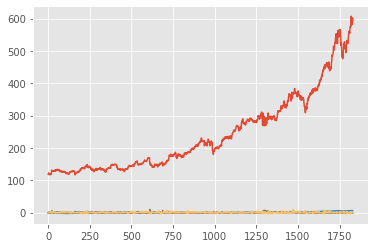

In [ ]:
plt.plot(finalDf)

###Split into Training and Test Set and scaling

In [ ]:
from sklearn.model_selection import train_test_split
sc = MinMaxScaler()

train, test = train_test_split(finalDf, test_size=0.3, shuffle = False)

In [ ]:
train = sc.fit_transform(train)

X_train = []
y_train = []
for i in range(DAYS, len(train)):
    X_train.append(train[i-DAYS:i]) # Chunks of training data with a length of 128 df-rows
    y_train.append(train[:, 0][i])
X_train, y_train = np.array(X_train), np.array(y_train)

print('Training set shape', X_train.shape, y_train.shape)

test = sc.fit_transform(test)

X_test, y_test = [], []
for i in range(DAYS, len(test)):
    X_test.append(test[i-DAYS:i])
    y_test.append(test[:, 0][i])    
X_test, y_test = np.array(X_test), np.array(y_test) 

print('Test set shape', X_test.shape, y_test.shape)

Training set shape (1251, 30, 5) (1251,)
Test set shape (519, 30, 5) (519,)


###Definitions to train, evaluate, and plot

In [ ]:
#Build and train the model
def fit_model(train,val,timesteps,hl,lr,batch,epochs):
    X_train = []
    Y_train = []
    X_val = []
    Y_val = []
  
    for i in range(timesteps,train.shape[0]):
        X_train.append(train[i-timesteps:i])
        Y_train.append(train[i][0])
    X_train,Y_train = np.array(X_train),np.array(Y_train)
  
    for i in range(timesteps,val.shape[0]):
        X_val.append(val[i-timesteps:i])
        Y_val.append(val[i][0])
    X_val,Y_val = np.array(X_val),np.array(Y_val)
    
    # Adding Layers to the model
    model = Sequential()
    model.add(LSTM(X_train.shape[2],input_shape = (X_train.shape[1],X_train.shape[2]),return_sequences = True,
                   activation = 'relu'))
    for i in range(len(hl)-1):        
        model.add(LSTM(hl[i],activation = 'relu',return_sequences = True))
    model.add(LSTM(hl[-1],activation = 'relu'))
    model.add(Dense(1))
    model.compile(optimizer = 'adam', loss = 'mean_squared_error')
  
    # Training the data
    history = model.fit(X_train,Y_train,epochs = epochs,batch_size = batch,validation_data = (X_val, Y_val),verbose = 0,
                        shuffle = False, callbacks=[checkpointer])
    model.reset_states()
    return model, history.history['loss'], history.history['val_loss']

In [ ]:
# Evaluating the model
def evaluate_model(model,test,timesteps):
    X_test = []
    Y_test = []

    for i in range(timesteps,test.shape[0]):
        X_test.append(test[i-timesteps:i])
        Y_test.append(test[i][0])
    X_test,Y_test = np.array(X_test),np.array(Y_test)
  
    Y_hat = model.predict(X_test)
    mse = mean_squared_error(Y_test,Y_hat)
    rmse = sqrt(mse)
    r = r2_score(Y_test,Y_hat)
    return mse, rmse, r, Y_test, Y_hat

In [ ]:
# Plotting the predictions
def plot_data(Y_test,Y_hat):
    plt.plot(Y_test,c = 'g')
    plt.plot(Y_hat,c = 'c')
    plt.xlabel('Day')
    plt.ylabel('Price')
    plt.title(ticker + ' Stock Prediction Graph LSTM model')
    plt.legend(['Actual','Predicted'],loc = 'lower right')
    plt.show()

In [ ]:
# Plotting the training errors
def plot_error(train_loss,val_loss):
    plt.plot(train_loss,c = 'r')
    plt.plot(val_loss,c = 'b')
    plt.ylabel('Loss')
    plt.legend(['train','val'],loc = 'upper right')
    plt.show()

###Set up callback

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint('/content/drive/MyDrive/Final Project Files/LSTM_Weights_'+ticker+'.hdf5', save_weights_only=True, save_best_only=True, verbose=1)

###Set hyper parameters and train model

In [ ]:
timesteps = DAYS
#hl = [40,35]
#lr = 1e-4
#batch_size = 32
#num_epochs = 30

model,train_error,test_error = fit_model(train,test,timesteps,hl,lr,batch_size,num_epochs)


Epoch 1: val_loss improved from inf to 0.01698, saving model to /content/drive/MyDrive/Final Project Files/LSTM_Weights_COST.hdf5

Epoch 2: val_loss did not improve from 0.01698

Epoch 3: val_loss did not improve from 0.01698

Epoch 4: val_loss improved from 0.01698 to 0.00571, saving model to /content/drive/MyDrive/Final Project Files/LSTM_Weights_COST.hdf5

Epoch 5: val_loss did not improve from 0.00571

Epoch 6: val_loss improved from 0.00571 to 0.00356, saving model to /content/drive/MyDrive/Final Project Files/LSTM_Weights_COST.hdf5

Epoch 7: val_loss did not improve from 0.00356

Epoch 8: val_loss did not improve from 0.00356

Epoch 9: val_loss did not improve from 0.00356

Epoch 10: val_loss did not improve from 0.00356

Epoch 11: val_loss did not improve from 0.00356

Epoch 12: val_loss did not improve from 0.00356

Epoch 13: val_loss did not improve from 0.00356

Epoch 14: val_loss did not improve from 0.00356

Epoch 15: val_loss did not improve from 0.00356

Epoch 16: val_lo

##Results

###Plot of Loss through each Epoch

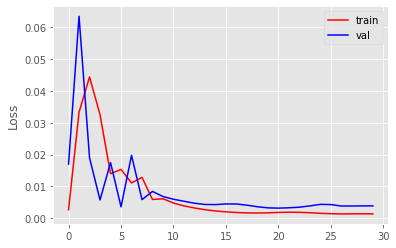

In [ ]:
plot_error(train_error,test_error)

###Prediction on Training set

MSE = 0.001494088675393016
RMSE = 0.038653443254036454
R-Squared Score = 0.9786762326727111


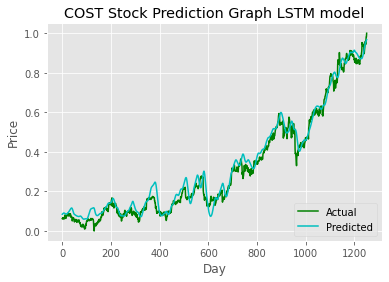

In [ ]:

mse, rmse, r2_value,true,predicted = evaluate_model(model,train,timesteps)
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))
plot_data(true,predicted)

###Prediction on Test Set

MSE = 0.003859956525781806
RMSE = 0.06212854839590094
R-Squared Score = 0.9415410365444666


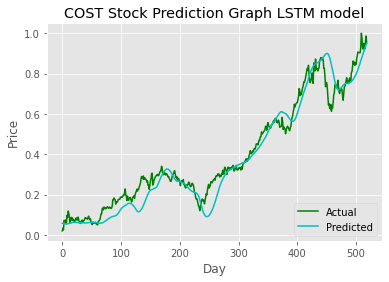

In [ ]:
mse, rmse, r2_value,true,predicted = evaluate_model(model,test,timesteps)
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))
plot_data(true,predicted)

#Home Depot

##Data Load, Preprocessing, and Modeling

###Information Load and Dataframe setup

In [ ]:
ticker = 'HD'

In [ ]:
!rm -rf '/content/drive/MyDrive/Final Project Files/LSTM_Weights_'+ticker.hdf5

In [ ]:
start_date = '2014-12-08'
end_date = '2022-04-22'

yahoo_financials = YahooFinancials(ticker)
data = yahoo_financials.get_historical_price_data(start_date=start_date, 
                                                  end_date=end_date, 
                                                  time_interval='daily')
df = pd.DataFrame(data[ticker]['prices'])
df = df.drop('date', axis=1).set_index('formatted_date')
#df = df.reset_index()
#df = df.rename(columns={"formatted_date": "Date"})
df = df.dropna()

# Define periods
k_period = 14
d_period = 3
# Adds a "n_high" column with max value of previous 14 periods
df['n_high'] = df['high'].rolling(k_period).max()
# Adds an "n_low" column with min value of previous 14 periods
df['n_low'] = df['low'].rolling(k_period).min()
# Uses the min/max values to calculate the %k (as a percentage)
df['%K'] = (df['adjclose'] - df['n_low']) * 100 / (df['n_high'] - df['n_low'])
# Uses the %k to calculates a SMA over the past 3 values of %k
df['%D'] = df['%K'].rolling(d_period).mean()


# Add some indicators
df.ta.stoch(high='high', low='low', k=14, d=3, append=True)

df = df.dropna()
df = df.drop(['n_high', 'n_low', '%K', '%D'], axis=1)
df = df.rename(columns={"STOCHk_14_3_3": "Fast Osc. Signal", "STOCHd_14_3_3": "Slow Osc. Signal"})

df['Volume_lag'] = df['volume'].shift(1)
df['High_lag'] = df['high'].shift(1)
df['Low_lag'] = df['low'].shift(1)
df['Open_lag'] = df['open'].shift(1)
df['Adj_Close_lag'] = df['adjclose'].shift(1)
df['Fast Osc. Lag'] = df['Fast Osc. Signal'].shift(1)
df['Slow Osc. Lag'] = df['Slow Osc. Signal'].shift(1)
df = df.drop(['volume'], axis=1)
df = df.drop(['close'], axis=1)
df = df.drop(['low'], axis=1)
df = df.drop(['high'], axis=1)
df = df.drop(['open'], axis=1)
df = df.drop(['Fast Osc. Signal'], axis=1)
df = df.drop(['Slow Osc. Signal'], axis=1)
print(df)

                  adjclose  Volume_lag    High_lag     Low_lag    Open_lag  \
formatted_date                                                               
2015-01-02       87.873749         NaN         NaN         NaN         NaN   
2015-01-05       86.030128   4323700.0  105.660004  102.669998  105.160004   
2015-01-06       85.766762   5878100.0  102.779999  100.790001  102.779999   
2015-01-07       88.706375   4910100.0  102.070000  100.339996  102.070000   
2015-01-08       90.668907   5091000.0  104.470001  102.000000  102.290001   
...                    ...         ...         ...         ...         ...   
2022-04-14      304.519989   3185300.0  311.700012  305.720001  306.109985   
2022-04-18      300.209991   4563800.0  312.250000  304.329987  310.829987   
2022-04-19      307.799988   3192400.0  306.290009  298.720001  303.000000   
2022-04-20      315.140015   3389700.0  308.130005  299.809998  300.609985   
2022-04-21      310.359985   4720800.0  316.100006  309.750000  

In [ ]:
# Get 30 year Bond Yield
yahoo_financials = YahooFinancials('^TYX')
data = yahoo_financials.get_historical_price_data(start_date=start_date, 
                                                  end_date=end_date, 
                                                  time_interval='daily')
yield_30yr = pd.DataFrame(data['^TYX']['prices'])
yield_30yr = yield_30yr.drop('date', axis=1).set_index('formatted_date')
#yield_30yr = yield_30yr.reset_index()
#yield_df = yield_30yr.rename(columns={"formatted_date": "Date"})
yield_df = yield_30yr.filter(['close'], axis=1)
yield_df = yield_df.dropna()
yield_df = yield_df.rename(columns={"close": "Bond_Yield"})
yield_df['Bond_Yield_Lag'] = yield_df['Bond_Yield'].shift(1)
yield_df = yield_df.drop(['Bond_Yield'], axis=1)
print(yield_df)

# Get Market Sentiment index
yahoo_financials = YahooFinancials('^VIX')
data = yahoo_financials.get_historical_price_data(start_date=start_date, 
                                                  end_date=end_date, 
                                                  time_interval='daily')
vix_df = pd.DataFrame(data['^VIX']['prices'])
vix_df = vix_df.drop('date', axis=1).set_index('formatted_date')
#vix_df = vix_df.reset_index()
#vix_df = vix_df.rename(columns={"formatted_date": "Date"})
vix_df = vix_df.filter(['close'], axis=1)
vix_df = vix_df.dropna()
vix_df = vix_df.rename(columns={"close": "VIX"})
vix_df['VIX_Lag'] = vix_df['VIX'].shift(1)
vix_df = vix_df.drop(['VIX'], axis = 1)
print(vix_df)


# Get Wilshire 5000 index
yahoo_financials = YahooFinancials('^W5000')
data = yahoo_financials.get_historical_price_data(start_date=start_date, 
                                                 end_date=end_date, 
                                                  time_interval='daily')
w5000 = pd.DataFrame(data['^W5000']['prices'])
w5000 = w5000.drop('date', axis=1).set_index('formatted_date')
#w5000 = w5000.reset_index()
#w5000 = w5000.rename(columns={"formatted_date": "Date"})
w5000 = w5000.filter(['close'], axis=1)
w5000 = w5000.dropna()
w5000 = w5000.rename(columns={"close": "Wilshire"})
w5000['Wilshire_Lag'] = w5000['Wilshire'].shift(1)
w5000 = w5000.drop(['Wilshire'], axis = 1)
print(w5000)

                Bond_Yield_Lag
formatted_date                
2014-12-08                 NaN
2014-12-09               2.901
2014-12-10               2.875
2014-12-11               2.835
2014-12-12               2.825
...                        ...
2022-04-14               2.794
2022-04-18               2.919
2022-04-19               2.953
2022-04-20               2.990
2022-04-21               2.879

[1854 rows x 1 columns]
                  VIX_Lag
formatted_date           
2014-12-08            NaN
2014-12-09      14.210000
2014-12-10      15.350000
2014-12-11      18.530001
2014-12-12      20.080000
...                   ...
2022-04-14      21.820000
2022-04-18      22.700001
2022-04-19      22.170000
2022-04-20      21.370001
2022-04-21      20.320000

[1856 rows x 1 columns]
                Wilshire_Lag
formatted_date              
2014-12-08               NaN
2014-12-09      21581.910156
2014-12-10      21536.179688
2014-12-11      21244.730469
2014-12-12      21338.890625
...   

In [ ]:
economic_df = yield_df.join(vix_df, on ='formatted_date')
economic_df = economic_df.join(w5000, on="formatted_date")
print(economic_df)

                Bond_Yield_Lag    VIX_Lag  Wilshire_Lag
formatted_date                                         
2014-12-08                 NaN        NaN           NaN
2014-12-09               2.901  14.210000  21581.910156
2014-12-10               2.875  15.350000  21536.179688
2014-12-11               2.835  18.530001  21244.730469
2014-12-12               2.825  20.080000  21338.890625
...                        ...        ...           ...
2022-04-14               2.794  21.820000  44732.468750
2022-04-18               2.919  22.700001  44180.851562
2022-04-19               2.953  22.170000  44086.601562
2022-04-20               2.990  21.370001  44967.039062
2022-04-21               2.879  20.320000  44774.980469

[1854 rows x 3 columns]


In [ ]:
df = df.join(economic_df,how='left', on = "formatted_date")

In [ ]:
sentiment_df = pd.read_csv('/content/drive/MyDrive/Final Project Files/'+ticker+'_Output.csv')
sentiment_df['formatted_date'] = sentiment_df['Date']
sentiment_df = sentiment_df.drop('Date', axis=1)
sentiment_df = sentiment_df.set_index('formatted_date')

In [ ]:
df = df.join(sentiment_df,how='left', on = "formatted_date")
df['Score_lag'] = df['Score_lag'].fillna(0)
df = df.iloc[1: , :]
print(df)

                  adjclose  Volume_lag    High_lag     Low_lag    Open_lag  \
formatted_date                                                               
2015-01-05       86.030128   4323700.0  105.660004  102.669998  105.160004   
2015-01-06       85.766762   5878100.0  102.779999  100.790001  102.779999   
2015-01-07       88.706375   4910100.0  102.070000  100.339996  102.070000   
2015-01-08       90.668907   5091000.0  104.470001  102.000000  102.290001   
2015-01-09       89.114151   6464600.0  106.989998  105.019997  105.370003   
...                    ...         ...         ...         ...         ...   
2022-04-14      304.519989   3185300.0  311.700012  305.720001  306.109985   
2022-04-18      300.209991   4563800.0  312.250000  304.329987  310.829987   
2022-04-19      307.799988   3192400.0  306.290009  298.720001  303.000000   
2022-04-20      315.140015   3389700.0  308.130005  299.809998  300.609985   
2022-04-21      310.359985   4720800.0  316.100006  309.750000  

In [ ]:
df

,adjclose,Volume_lag,High_lag,Low_lag,Open_lag,Adj_Close_lag,Fast Osc. Lag,Slow Osc. Lag,Bond_Yield_Lag,VIX_Lag,Wilshire_Lag,Score_lag
formatted_date,,,,,,,,,,,,
2015-01-05,86.030128,4323700.0,105.660004,102.669998,105.160004,87.873749,84.301253,90.251565,2.697,17.790001,21665.320312,0.0000
2015-01-06,85.766762,5878100.0,102.779999,100.790001,102.779999,86.030128,68.992295,82.001042,2.605,19.920000,21269.060547,0.0000
2015-01-07,88.706375,4910100.0,102.070000,100.339996,102.070000,85.766762,54.152853,69.148800,2.523,21.120001,21060.250000,0.0000
2015-01-08,90.668907,5091000.0,104.470001,102.000000,102.290001,88.706375,57.703885,60.283011,2.515,19.309999,21301.669922,0.0000
2015-01-09,89.114151,6464600.0,106.989998,105.019997,105.370003,90.668907,74.104589,61.987109,2.593,17.010000,21672.390625,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-14,304.519989,3185300.0,311.700012,305.720001,306.109985,310.420013,48.560827,42.253283,2.794,21.820000,44732.468750,0.1531
2022-04-18,300.209991,4563800.0,312.250000,304.329987,310.829987,304.519989,49.203474,47.114910,2.919,22.700001,44180.851562,0.0000
2022-04-19,307.799988,3192400.0,306.290009,298.720001,303.000000,300.209991,41.809559,46.524620,2.953,22.170000,44086.601562,0.1280


In [ ]:
df = df.dropna()
df.corr()['adjclose']

adjclose          1.000000
Volume_lag       -0.211030
High_lag          0.998648
Low_lag           0.998360
Open_lag          0.998192
Adj_Close_lag     0.999173
Fast Osc. Lag     0.026585
Slow Osc. Lag     0.026262
Bond_Yield_Lag   -0.603588
VIX_Lag           0.297038
Wilshire_Lag      0.976428
Score_lag         0.077222
Name: adjclose, dtype: float64

In [ ]:
df_pca = df

In [ ]:
df_pca

,adjclose,Volume_lag,High_lag,Low_lag,Open_lag,Adj_Close_lag,Fast Osc. Lag,Slow Osc. Lag,Bond_Yield_Lag,VIX_Lag,Wilshire_Lag,Score_lag
formatted_date,,,,,,,,,,,,
2015-01-05,86.030128,4323700.0,105.660004,102.669998,105.160004,87.873749,84.301253,90.251565,2.697,17.790001,21665.320312,0.0000
2015-01-06,85.766762,5878100.0,102.779999,100.790001,102.779999,86.030128,68.992295,82.001042,2.605,19.920000,21269.060547,0.0000
2015-01-07,88.706375,4910100.0,102.070000,100.339996,102.070000,85.766762,54.152853,69.148800,2.523,21.120001,21060.250000,0.0000
2015-01-08,90.668907,5091000.0,104.470001,102.000000,102.290001,88.706375,57.703885,60.283011,2.515,19.309999,21301.669922,0.0000
2015-01-09,89.114151,6464600.0,106.989998,105.019997,105.370003,90.668907,74.104589,61.987109,2.593,17.010000,21672.390625,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-14,304.519989,3185300.0,311.700012,305.720001,306.109985,310.420013,48.560827,42.253283,2.794,21.820000,44732.468750,0.1531
2022-04-18,300.209991,4563800.0,312.250000,304.329987,310.829987,304.519989,49.203474,47.114910,2.919,22.700001,44180.851562,0.0000
2022-04-19,307.799988,3192400.0,306.290009,298.720001,303.000000,300.209991,41.809559,46.524620,2.953,22.170000,44086.601562,0.1280


###Running PCA to reduce variables

In [ ]:
from sklearn.preprocessing import StandardScaler
features = ['Volume_lag', 'High_lag', 'Low_lag', 'Open_lag', 'Adj_Close_lag',
            'Fast Osc. Lag', 'Slow Osc. Lag', 'Bond_Yield_Lag', 'VIX_Lag',
            'Wilshire_Lag', 'Score_lag']
# Separating out the features
x = df_pca.loc[:, features].values
# Separating out the target
y = df_pca.loc[:,['adjclose']].values
# Standardizing the features
x = StandardScaler().fit_transform(x)
x

array([[-0.15845654, -1.28620302, -1.30475863, ..., -0.03987629,
        -1.02386581, -0.17802908],
       [ 0.58560371, -1.32383144, -1.3298452 , ...,  0.2318808 ,
        -1.07289718, -0.17802908],
       [ 0.12224144, -1.33310787, -1.33585004, ...,  0.38498355,
        -1.09873444, -0.17802908],
       ...,
       [-0.69998726,  1.33510863,  1.31132136, ...,  0.51894827,
         1.75044113,  0.63069652],
       [-0.60554369,  1.35914892,  1.32586621, ...,  0.41687994,
         1.85938244,  3.91993514],
       [ 0.03162731,  1.46328019,  1.45850503, ...,  0.28291497,
         1.83561799, -0.17802908]])

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=4)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['PC 1', 'PC 2', 'PC 3', 'PC 4'])
principalDf

,PC 1,PC 2,PC 3,PC 4
0,-2.656665,-1.354690,0.776965,-0.229473
1,-2.718071,-0.515602,1.176546,-0.317402
2,-2.643032,0.049131,0.825552,-0.261081
3,-2.634372,0.130418,0.669841,-0.219399
4,-2.698034,-0.198445,0.931246,-0.250721
...,...,...,...,...
1825,3.160090,0.474866,-0.991318,0.861901
1826,2.970905,0.537579,-0.811785,-0.154827
1827,2.900740,0.529028,-1.091424,0.726413
1828,3.087261,0.572753,-0.446941,3.949842


###Merging PCA to Adjust Close Price

In [ ]:
df_adjclose = df.reset_index()
df_adjclose = df_adjclose.rename(columns={"formatted_date": "Date"})
df_adjclose = df_adjclose[['adjclose']]
df_adjclose

,adjclose
0,86.030128
1,85.766762
2,88.706375
3,90.668907
4,89.114151
...,...
1825,304.519989
1826,300.209991
1827,307.799988
1828,315.140015


In [ ]:
finalDf = pd.merge(df_adjclose, principalDf, left_index=True, right_index=True)
finalDf

,adjclose,PC 1,PC 2,PC 3,PC 4
0,86.030128,-2.656665,-1.354690,0.776965,-0.229473
1,85.766762,-2.718071,-0.515602,1.176546,-0.317402
2,88.706375,-2.643032,0.049131,0.825552,-0.261081
3,90.668907,-2.634372,0.130418,0.669841,-0.219399
4,89.114151,-2.698034,-0.198445,0.931246,-0.250721
...,...,...,...,...,...
1825,304.519989,3.160090,0.474866,-0.991318,0.861901
1826,300.209991,2.970905,0.537579,-0.811785,-0.154827
1827,307.799988,2.900740,0.529028,-1.091424,0.726413
1828,315.140015,3.087261,0.572753,-0.446941,3.949842


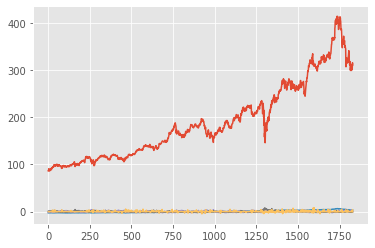

In [ ]:
plt.plot(finalDf)

###Split into Training and Test Set and scaling

In [ ]:
from sklearn.model_selection import train_test_split
sc = MinMaxScaler()

train, test = train_test_split(finalDf, test_size=0.3, shuffle = False)

In [ ]:
train = sc.fit_transform(train)

X_train = []
y_train = []
for i in range(DAYS, len(train)):
    X_train.append(train[i-DAYS:i]) # Chunks of training data with a length of 128 df-rows
    y_train.append(train[:, 0][i])
X_train, y_train = np.array(X_train), np.array(y_train)

print('Training set shape', X_train.shape, y_train.shape)

test = sc.fit_transform(test)

X_test, y_test = [], []
for i in range(DAYS, len(test)):
    X_test.append(test[i-DAYS:i])
    y_test.append(test[:, 0][i])    
X_test, y_test = np.array(X_test), np.array(y_test) 

print('Test set shape', X_test.shape, y_test.shape)

Training set shape (1251, 30, 5) (1251,)
Test set shape (519, 30, 5) (519,)


###Definitions to train, evaluate, and plot

In [ ]:
#Build and train the model
def fit_model(train,val,timesteps,hl,lr,batch,epochs):
    X_train = []
    Y_train = []
    X_val = []
    Y_val = []
  
    for i in range(timesteps,train.shape[0]):
        X_train.append(train[i-timesteps:i])
        Y_train.append(train[i][0])
    X_train,Y_train = np.array(X_train),np.array(Y_train)
  
    for i in range(timesteps,val.shape[0]):
        X_val.append(val[i-timesteps:i])
        Y_val.append(val[i][0])
    X_val,Y_val = np.array(X_val),np.array(Y_val)
    
    # Adding Layers to the model
    model = Sequential()
    model.add(LSTM(X_train.shape[2],input_shape = (X_train.shape[1],X_train.shape[2]),return_sequences = True,
                   activation = 'relu'))
    for i in range(len(hl)-1):        
        model.add(LSTM(hl[i],activation = 'relu',return_sequences = True))
    model.add(LSTM(hl[-1],activation = 'relu'))
    model.add(Dense(1))
    model.compile(optimizer = 'adam', loss = 'mean_squared_error')
  
    # Training the data
    history = model.fit(X_train,Y_train,epochs = epochs,batch_size = batch,validation_data = (X_val, Y_val),verbose = 0,
                        shuffle = False, callbacks=[checkpointer])
    model.reset_states()
    return model, history.history['loss'], history.history['val_loss']

In [ ]:
# Evaluating the model
def evaluate_model(model,test,timesteps):
    X_test = []
    Y_test = []

    for i in range(timesteps,test.shape[0]):
        X_test.append(test[i-timesteps:i])
        Y_test.append(test[i][0])
    X_test,Y_test = np.array(X_test),np.array(Y_test)
  
    Y_hat = model.predict(X_test)
    mse = mean_squared_error(Y_test,Y_hat)
    rmse = sqrt(mse)
    r = r2_score(Y_test,Y_hat)
    return mse, rmse, r, Y_test, Y_hat

In [ ]:
# Plotting the predictions
def plot_data(Y_test,Y_hat):
    plt.plot(Y_test,c = 'g')
    plt.plot(Y_hat,c = 'c')
    plt.xlabel('Day')
    plt.ylabel('Price')
    plt.title(ticker + ' Stock Prediction Graph LSTM model')
    plt.legend(['Actual','Predicted'],loc = 'lower right')
    plt.show()

In [ ]:
# Plotting the training errors
def plot_error(train_loss,val_loss):
    plt.plot(train_loss,c = 'r')
    plt.plot(val_loss,c = 'b')
    plt.ylabel('Loss')
    plt.legend(['train','val'],loc = 'upper right')
    plt.show()

###Set up callback

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint('/content/drive/MyDrive/Final Project Files/LSTM_Weights_'+ticker+'.hdf5', save_weights_only=True, save_best_only=True, verbose=1)

###Set hyper parameters and train model

In [ ]:
timesteps = DAYS
#hl = [40,35]
#lr = 1e-4
#batch_size = 32
#num_epochs = 30

model,train_error,test_error = fit_model(train,test,timesteps,hl,lr,batch_size,num_epochs)


Epoch 1: val_loss improved from inf to 0.08631, saving model to /content/drive/MyDrive/Final Project Files/LSTM_Weights_HD.hdf5

Epoch 2: val_loss improved from 0.08631 to 0.07347, saving model to /content/drive/MyDrive/Final Project Files/LSTM_Weights_HD.hdf5

Epoch 3: val_loss improved from 0.07347 to 0.03816, saving model to /content/drive/MyDrive/Final Project Files/LSTM_Weights_HD.hdf5

Epoch 4: val_loss improved from 0.03816 to 0.01326, saving model to /content/drive/MyDrive/Final Project Files/LSTM_Weights_HD.hdf5

Epoch 5: val_loss improved from 0.01326 to 0.00552, saving model to /content/drive/MyDrive/Final Project Files/LSTM_Weights_HD.hdf5

Epoch 6: val_loss did not improve from 0.00552

Epoch 7: val_loss did not improve from 0.00552

Epoch 8: val_loss did not improve from 0.00552

Epoch 9: val_loss did not improve from 0.00552

Epoch 10: val_loss improved from 0.00552 to 0.00507, saving model to /content/drive/MyDrive/Final Project Files/LSTM_Weights_HD.hdf5

Epoch 11: va

##Results

###Plot of Loss through each Epoch

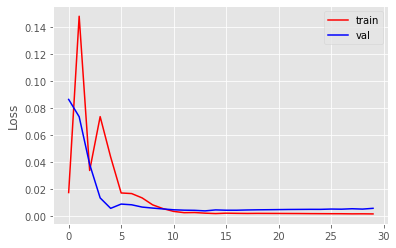

In [ ]:
plot_error(train_error,test_error)

###Prediction on Training set

MSE = 0.0021015043070672958
RMSE = 0.04584216734696665
R-Squared Score = 0.9687996013008626


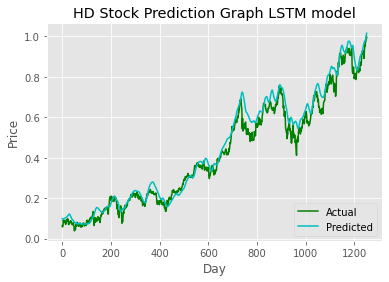

In [ ]:

mse, rmse, r2_value,true,predicted = evaluate_model(model,train,timesteps)
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))
plot_data(true,predicted)

###Prediction on Test Set

MSE = 0.005536408820396964
RMSE = 0.07440704819032243
R-Squared Score = 0.8459903977269089


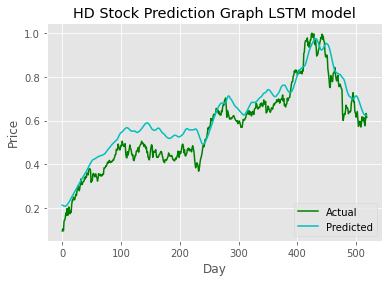

In [ ]:
mse, rmse, r2_value,true,predicted = evaluate_model(model,test,timesteps)
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))
plot_data(true,predicted)

#Ford

##Data Load, Preprocessing, and Modeling

###Information Load and Dataframe setup

In [ ]:
ticker = 'F'

In [ ]:
!rm -rf '/content/drive/MyDrive/Final Project Files/LSTM_Weights_'+ticker.hdf5

In [ ]:
start_date = '2014-12-08'
end_date = '2022-04-22'

yahoo_financials = YahooFinancials(ticker)
data = yahoo_financials.get_historical_price_data(start_date=start_date, 
                                                  end_date=end_date, 
                                                  time_interval='daily')
df = pd.DataFrame(data[ticker]['prices'])
df = df.drop('date', axis=1).set_index('formatted_date')
#df = df.reset_index()
#df = df.rename(columns={"formatted_date": "Date"})
df = df.dropna()

# Define periods
k_period = 14
d_period = 3
# Adds a "n_high" column with max value of previous 14 periods
df['n_high'] = df['high'].rolling(k_period).max()
# Adds an "n_low" column with min value of previous 14 periods
df['n_low'] = df['low'].rolling(k_period).min()
# Uses the min/max values to calculate the %k (as a percentage)
df['%K'] = (df['adjclose'] - df['n_low']) * 100 / (df['n_high'] - df['n_low'])
# Uses the %k to calculates a SMA over the past 3 values of %k
df['%D'] = df['%K'].rolling(d_period).mean()


# Add some indicators
df.ta.stoch(high='high', low='low', k=14, d=3, append=True)

df = df.dropna()
df = df.drop(['n_high', 'n_low', '%K', '%D'], axis=1)
df = df.rename(columns={"STOCHk_14_3_3": "Fast Osc. Signal", "STOCHd_14_3_3": "Slow Osc. Signal"})

df['Volume_lag'] = df['volume'].shift(1)
df['High_lag'] = df['high'].shift(1)
df['Low_lag'] = df['low'].shift(1)
df['Open_lag'] = df['open'].shift(1)
df['Adj_Close_lag'] = df['adjclose'].shift(1)
df['Fast Osc. Lag'] = df['Fast Osc. Signal'].shift(1)
df['Slow Osc. Lag'] = df['Slow Osc. Signal'].shift(1)
df = df.drop(['volume'], axis=1)
df = df.drop(['close'], axis=1)
df = df.drop(['low'], axis=1)
df = df.drop(['high'], axis=1)
df = df.drop(['open'], axis=1)
df = df.drop(['Fast Osc. Signal'], axis=1)
df = df.drop(['Slow Osc. Signal'], axis=1)
print(df)

                 adjclose  Volume_lag   High_lag  Low_lag  Open_lag  \
formatted_date                                                        
2015-01-02      11.052874         NaN        NaN      NaN       NaN   
2015-01-05      10.621119  24777900.0  15.650000    15.18     15.59   
2015-01-06      10.520379  44079700.0  15.130000    14.69     15.12   
2015-01-07      10.822605  32981600.0  14.900000    14.38     14.88   
2015-01-08      11.096046  26065300.0  15.090000    14.77     14.78   
...                   ...         ...        ...      ...       ...   
2022-04-14      15.377687  51871800.0  15.550000    15.22     15.31   
2022-04-18      15.566431  39228500.0  15.760000    15.46     15.50   
2022-04-19      16.043259  40205800.0  15.790000    15.37     15.37   
2022-04-20      15.943918  55398300.0  16.230000    15.74     15.74   
2022-04-21      15.596232  47351500.0  16.549999    16.01     16.23   

                Adj_Close_lag  Fast Osc. Lag  Slow Osc. Lag  
formatted_date

In [ ]:
# Get 30 year Bond Yield
yahoo_financials = YahooFinancials('^TYX')
data = yahoo_financials.get_historical_price_data(start_date=start_date, 
                                                  end_date=end_date, 
                                                  time_interval='daily')
yield_30yr = pd.DataFrame(data['^TYX']['prices'])
yield_30yr = yield_30yr.drop('date', axis=1).set_index('formatted_date')
#yield_30yr = yield_30yr.reset_index()
#yield_df = yield_30yr.rename(columns={"formatted_date": "Date"})
yield_df = yield_30yr.filter(['close'], axis=1)
yield_df = yield_df.dropna()
yield_df = yield_df.rename(columns={"close": "Bond_Yield"})
yield_df['Bond_Yield_Lag'] = yield_df['Bond_Yield'].shift(1)
yield_df = yield_df.drop(['Bond_Yield'], axis=1)
print(yield_df)

# Get Market Sentiment index
yahoo_financials = YahooFinancials('^VIX')
data = yahoo_financials.get_historical_price_data(start_date=start_date, 
                                                  end_date=end_date, 
                                                  time_interval='daily')
vix_df = pd.DataFrame(data['^VIX']['prices'])
vix_df = vix_df.drop('date', axis=1).set_index('formatted_date')
#vix_df = vix_df.reset_index()
#vix_df = vix_df.rename(columns={"formatted_date": "Date"})
vix_df = vix_df.filter(['close'], axis=1)
vix_df = vix_df.dropna()
vix_df = vix_df.rename(columns={"close": "VIX"})
vix_df['VIX_Lag'] = vix_df['VIX'].shift(1)
vix_df = vix_df.drop(['VIX'], axis = 1)
print(vix_df)


# Get Wilshire 5000 index
yahoo_financials = YahooFinancials('^W5000')
data = yahoo_financials.get_historical_price_data(start_date=start_date, 
                                                 end_date=end_date, 
                                                  time_interval='daily')
w5000 = pd.DataFrame(data['^W5000']['prices'])
w5000 = w5000.drop('date', axis=1).set_index('formatted_date')
#w5000 = w5000.reset_index()
#w5000 = w5000.rename(columns={"formatted_date": "Date"})
w5000 = w5000.filter(['close'], axis=1)
w5000 = w5000.dropna()
w5000 = w5000.rename(columns={"close": "Wilshire"})
w5000['Wilshire_Lag'] = w5000['Wilshire'].shift(1)
w5000 = w5000.drop(['Wilshire'], axis = 1)
print(w5000)

                Bond_Yield_Lag
formatted_date                
2014-12-08                 NaN
2014-12-09               2.901
2014-12-10               2.875
2014-12-11               2.835
2014-12-12               2.825
...                        ...
2022-04-14               2.794
2022-04-18               2.919
2022-04-19               2.953
2022-04-20               2.990
2022-04-21               2.879

[1854 rows x 1 columns]
                  VIX_Lag
formatted_date           
2014-12-08            NaN
2014-12-09      14.210000
2014-12-10      15.350000
2014-12-11      18.530001
2014-12-12      20.080000
...                   ...
2022-04-14      21.820000
2022-04-18      22.700001
2022-04-19      22.170000
2022-04-20      21.370001
2022-04-21      20.320000

[1856 rows x 1 columns]
                Wilshire_Lag
formatted_date              
2014-12-08               NaN
2014-12-09      21581.910156
2014-12-10      21536.179688
2014-12-11      21244.730469
2014-12-12      21338.890625
...   

In [ ]:
economic_df = yield_df.join(vix_df, on ='formatted_date')
economic_df = economic_df.join(w5000, on="formatted_date")
print(economic_df)

                Bond_Yield_Lag    VIX_Lag  Wilshire_Lag
formatted_date                                         
2014-12-08                 NaN        NaN           NaN
2014-12-09               2.901  14.210000  21581.910156
2014-12-10               2.875  15.350000  21536.179688
2014-12-11               2.835  18.530001  21244.730469
2014-12-12               2.825  20.080000  21338.890625
...                        ...        ...           ...
2022-04-14               2.794  21.820000  44732.468750
2022-04-18               2.919  22.700001  44180.851562
2022-04-19               2.953  22.170000  44086.601562
2022-04-20               2.990  21.370001  44967.039062
2022-04-21               2.879  20.320000  44774.980469

[1854 rows x 3 columns]


In [ ]:
df = df.join(economic_df,how='left', on = "formatted_date")

In [ ]:
sentiment_df = pd.read_csv('/content/drive/MyDrive/Final Project Files/'+ticker+'_Output.csv')
sentiment_df['formatted_date'] = sentiment_df['Date']
sentiment_df = sentiment_df.drop('Date', axis=1)
sentiment_df = sentiment_df.set_index('formatted_date')

In [ ]:
df = df.join(sentiment_df,how='left', on = "formatted_date")
df['Score_lag'] = df['Score_lag'].fillna(0)
df = df.iloc[1: , :]
print(df)

                 adjclose  Volume_lag   High_lag  Low_lag  Open_lag  \
formatted_date                                                        
2015-01-05      10.621119  24777900.0  15.650000    15.18     15.59   
2015-01-06      10.520379  44079700.0  15.130000    14.69     15.12   
2015-01-07      10.822605  32981600.0  14.900000    14.38     14.88   
2015-01-08      11.096046  26065300.0  15.090000    14.77     14.78   
2015-01-09      10.944936  33943400.0  15.480000    15.23     15.40   
...                   ...         ...        ...      ...       ...   
2022-04-14      15.377687  51871800.0  15.550000    15.22     15.31   
2022-04-18      15.566431  39228500.0  15.760000    15.46     15.50   
2022-04-19      16.043259  40205800.0  15.790000    15.37     15.37   
2022-04-20      15.943918  55398300.0  16.230000    15.74     15.74   
2022-04-21      15.596232  47351500.0  16.549999    16.01     16.23   

                Adj_Close_lag  Fast Osc. Lag  Slow Osc. Lag  Bond_Yield_Lag 

In [ ]:
df

,adjclose,Volume_lag,High_lag,Low_lag,Open_lag,Adj_Close_lag,Fast Osc. Lag,Slow Osc. Lag,Bond_Yield_Lag,VIX_Lag,Wilshire_Lag,Score_lag
formatted_date,,,,,,,,,,,,
2015-01-05,10.621119,24777900.0,15.650000,15.18,15.59,11.052874,87.047595,88.390707,2.697,17.790001,21665.320312,0.0000
2015-01-06,10.520379,44079700.0,15.130000,14.69,15.12,10.621119,72.952361,83.365062,2.605,19.920000,21269.060547,0.0000
2015-01-07,10.822605,32981600.0,14.900000,14.38,14.88,10.520379,56.190454,72.063470,2.523,21.120001,21060.250000,-0.2960
2015-01-08,11.096046,26065300.0,15.090000,14.77,14.78,10.822605,48.697593,59.280136,2.515,19.309999,21301.669922,0.2023
2015-01-09,10.944936,33943400.0,15.480000,15.23,15.40,11.096046,59.554732,54.814260,2.593,17.010000,21672.390625,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-14,15.377687,51871800.0,15.550000,15.22,15.31,15.407489,25.411515,20.884765,2.794,21.820000,44732.468750,0.0000
2022-04-18,15.566431,39228500.0,15.760000,15.46,15.50,15.377687,27.469127,24.519882,2.919,22.700001,44180.851562,0.0000
2022-04-19,16.043259,40205800.0,15.790000,15.37,15.37,15.566431,30.658433,27.846358,2.953,22.170000,44086.601562,0.0000


In [ ]:
df = df.dropna()
df.corr()['adjclose']

adjclose          1.000000
Volume_lag        0.245298
High_lag          0.911848
Low_lag           0.900423
Open_lag          0.904911
Adj_Close_lag     0.996731
Fast Osc. Lag     0.133574
Slow Osc. Lag     0.138270
Bond_Yield_Lag    0.010487
VIX_Lag          -0.170298
Wilshire_Lag      0.539564
Score_lag         0.081556
Name: adjclose, dtype: float64

In [ ]:
df_pca = df

In [ ]:
df_pca

,adjclose,Volume_lag,High_lag,Low_lag,Open_lag,Adj_Close_lag,Fast Osc. Lag,Slow Osc. Lag,Bond_Yield_Lag,VIX_Lag,Wilshire_Lag,Score_lag
formatted_date,,,,,,,,,,,,
2015-01-05,10.621119,24777900.0,15.650000,15.18,15.59,11.052874,87.047595,88.390707,2.697,17.790001,21665.320312,0.0000
2015-01-06,10.520379,44079700.0,15.130000,14.69,15.12,10.621119,72.952361,83.365062,2.605,19.920000,21269.060547,0.0000
2015-01-07,10.822605,32981600.0,14.900000,14.38,14.88,10.520379,56.190454,72.063470,2.523,21.120001,21060.250000,-0.2960
2015-01-08,11.096046,26065300.0,15.090000,14.77,14.78,10.822605,48.697593,59.280136,2.515,19.309999,21301.669922,0.2023
2015-01-09,10.944936,33943400.0,15.480000,15.23,15.40,11.096046,59.554732,54.814260,2.593,17.010000,21672.390625,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-14,15.377687,51871800.0,15.550000,15.22,15.31,15.407489,25.411515,20.884765,2.794,21.820000,44732.468750,0.0000
2022-04-18,15.566431,39228500.0,15.760000,15.46,15.50,15.377687,27.469127,24.519882,2.919,22.700001,44180.851562,0.0000
2022-04-19,16.043259,40205800.0,15.790000,15.37,15.37,15.566431,30.658433,27.846358,2.953,22.170000,44086.601562,0.0000


###Running PCA to reduce variables

In [ ]:
from sklearn.preprocessing import StandardScaler
features = ['Volume_lag', 'High_lag', 'Low_lag', 'Open_lag', 'Adj_Close_lag',
            'Fast Osc. Lag', 'Slow Osc. Lag', 'Bond_Yield_Lag', 'VIX_Lag',
            'Wilshire_Lag', 'Score_lag']
# Separating out the features
x = df_pca.loc[:, features].values
# Separating out the target
y = df_pca.loc[:,['adjclose']].values
# Standardizing the features
x = StandardScaler().fit_transform(x)
x

array([[-0.80128509,  1.13038516,  1.10910617, ..., -0.03987629,
        -1.02386581, -0.11257532],
       [-0.19951319,  0.9737075 ,  0.95680856, ...,  0.2318808 ,
        -1.07289718, -0.11257532],
       [-0.54551847,  0.90440755,  0.86045732, ...,  0.38498355,
        -1.09873444, -1.30015421],
       ...,
       [-0.32028971,  1.17256775,  1.16816013, ...,  0.51894827,
         1.75044113, -0.11257532],
       [ 0.15336662,  1.30514115,  1.28316016, ...,  0.41687994,
         1.85938244, -0.11257532],
       [-0.09750833,  1.40155817,  1.36707927, ...,  0.28291497,
         1.83561799, -0.11257532]])

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=4)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['PC 1', 'PC 2', 'PC 3', 'PC 4'])
principalDf

,PC 1,PC 2,PC 3,PC 4
0,1.970458,-0.830783,-1.731888,-0.098685
1,1.546285,-0.438525,-1.217930,-0.033083
2,1.167956,-0.672657,-0.506401,-1.182378
3,1.349068,-0.847159,-0.096138,0.780332
4,1.668831,-0.908440,-0.202823,-0.037336
...,...,...,...,...
1825,2.378855,0.727945,1.998032,-0.348294
1826,2.477425,0.438459,1.846671,-0.348079
1827,2.525513,0.431865,1.673659,-0.357196
1828,2.877321,0.716209,1.466726,-0.375950


###Merging PCA to Adjust Close Price

In [ ]:
df_adjclose = df.reset_index()
df_adjclose = df_adjclose.rename(columns={"formatted_date": "Date"})
df_adjclose = df_adjclose[['adjclose']]
df_adjclose

,adjclose
0,10.621119
1,10.520379
2,10.822605
3,11.096046
4,10.944936
...,...
1825,15.377687
1826,15.566431
1827,16.043259
1828,15.943918


In [ ]:
finalDf = pd.merge(df_adjclose, principalDf, left_index=True, right_index=True)
finalDf

,adjclose,PC 1,PC 2,PC 3,PC 4
0,10.621119,1.970458,-0.830783,-1.731888,-0.098685
1,10.520379,1.546285,-0.438525,-1.217930,-0.033083
2,10.822605,1.167956,-0.672657,-0.506401,-1.182378
3,11.096046,1.349068,-0.847159,-0.096138,0.780332
4,10.944936,1.668831,-0.908440,-0.202823,-0.037336
...,...,...,...,...,...
1825,15.377687,2.378855,0.727945,1.998032,-0.348294
1826,15.566431,2.477425,0.438459,1.846671,-0.348079
1827,16.043259,2.525513,0.431865,1.673659,-0.357196
1828,15.943918,2.877321,0.716209,1.466726,-0.375950


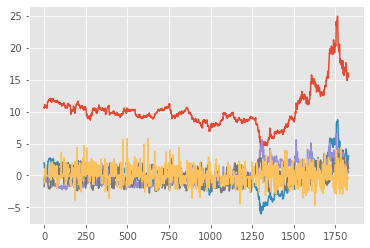

In [ ]:
plt.plot(finalDf)

###Split into Training and Test Set and scaling

In [ ]:
from sklearn.model_selection import train_test_split
sc = MinMaxScaler()

train, test = train_test_split(finalDf, test_size=0.3, shuffle = False)

In [ ]:
train = sc.fit_transform(train)

X_train = []
y_train = []
for i in range(DAYS, len(train)):
    X_train.append(train[i-DAYS:i]) # Chunks of training data with a length of 128 df-rows
    y_train.append(train[:, 0][i])
X_train, y_train = np.array(X_train), np.array(y_train)

print('Training set shape', X_train.shape, y_train.shape)

test = sc.fit_transform(test)

X_test, y_test = [], []
for i in range(DAYS, len(test)):
    X_test.append(test[i-DAYS:i])
    y_test.append(test[:, 0][i])    
X_test, y_test = np.array(X_test), np.array(y_test) 

print('Test set shape', X_test.shape, y_test.shape)

Training set shape (1251, 30, 5) (1251,)
Test set shape (519, 30, 5) (519,)


###Definitions to train, evaluate, and plot

In [ ]:
#Build and train the model
def fit_model(train,val,timesteps,hl,lr,batch,epochs):
    X_train = []
    Y_train = []
    X_val = []
    Y_val = []
  
    for i in range(timesteps,train.shape[0]):
        X_train.append(train[i-timesteps:i])
        Y_train.append(train[i][0])
    X_train,Y_train = np.array(X_train),np.array(Y_train)
  
    for i in range(timesteps,val.shape[0]):
        X_val.append(val[i-timesteps:i])
        Y_val.append(val[i][0])
    X_val,Y_val = np.array(X_val),np.array(Y_val)
    
    # Adding Layers to the model
    model = Sequential()
    model.add(LSTM(X_train.shape[2],input_shape = (X_train.shape[1],X_train.shape[2]),return_sequences = True,
                   activation = 'relu'))
    for i in range(len(hl)-1):        
        model.add(LSTM(hl[i],activation = 'relu',return_sequences = True))
    model.add(LSTM(hl[-1],activation = 'relu'))
    model.add(Dense(1))
    model.compile(optimizer = 'adam', loss = 'mean_squared_error')
  
    # Training the data
    history = model.fit(X_train,Y_train,epochs = epochs,batch_size = batch,validation_data = (X_val, Y_val),verbose = 0,
                        shuffle = False, callbacks=[checkpointer])
    model.reset_states()
    return model, history.history['loss'], history.history['val_loss']

In [ ]:
# Evaluating the model
def evaluate_model(model,test,timesteps):
    X_test = []
    Y_test = []

    for i in range(timesteps,test.shape[0]):
        X_test.append(test[i-timesteps:i])
        Y_test.append(test[i][0])
    X_test,Y_test = np.array(X_test),np.array(Y_test)
  
    Y_hat = model.predict(X_test)
    mse = mean_squared_error(Y_test,Y_hat)
    rmse = sqrt(mse)
    r = r2_score(Y_test,Y_hat)
    return mse, rmse, r, Y_test, Y_hat

In [ ]:
# Plotting the predictions
def plot_data(Y_test,Y_hat):
    plt.plot(Y_test,c = 'g')
    plt.plot(Y_hat,c = 'c')
    plt.xlabel('Day')
    plt.ylabel('Price')
    plt.title(ticker + ' Stock Prediction Graph LSTM model')
    plt.legend(['Actual','Predicted'],loc = 'lower right')
    plt.show()

In [ ]:
# Plotting the training errors
def plot_error(train_loss,val_loss):
    plt.plot(train_loss,c = 'r')
    plt.plot(val_loss,c = 'b')
    plt.ylabel('Loss')
    plt.legend(['train','val'],loc = 'upper right')
    plt.show()

###Set up callback

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint('/content/drive/MyDrive/Final Project Files/LSTM_Weights_'+ticker+'.hdf5', save_weights_only=True, save_best_only=True, verbose=1)

###Set hyper parameters and train model

In [ ]:
timesteps = DAYS
hl = [40,35]
lr = 1e-4
batch_size = 32
num_epochs = 30

model,train_error,test_error = fit_model(train,test,timesteps,hl,lr,batch_size,num_epochs)


Epoch 1: val_loss improved from inf to 0.01384, saving model to /content/drive/MyDrive/Final Project Files/LSTM_Weights_F.hdf5

Epoch 2: val_loss improved from 0.01384 to 0.00830, saving model to /content/drive/MyDrive/Final Project Files/LSTM_Weights_F.hdf5

Epoch 3: val_loss improved from 0.00830 to 0.00762, saving model to /content/drive/MyDrive/Final Project Files/LSTM_Weights_F.hdf5

Epoch 4: val_loss improved from 0.00762 to 0.00717, saving model to /content/drive/MyDrive/Final Project Files/LSTM_Weights_F.hdf5

Epoch 5: val_loss improved from 0.00717 to 0.00675, saving model to /content/drive/MyDrive/Final Project Files/LSTM_Weights_F.hdf5

Epoch 6: val_loss improved from 0.00675 to 0.00633, saving model to /content/drive/MyDrive/Final Project Files/LSTM_Weights_F.hdf5

Epoch 7: val_loss improved from 0.00633 to 0.00632, saving model to /content/drive/MyDrive/Final Project Files/LSTM_Weights_F.hdf5

Epoch 8: val_loss improved from 0.00632 to 0.00560, saving model to /content/dr

##Results

###Plot of Loss through each Epoch

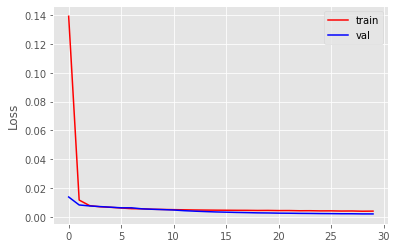

In [ ]:
plot_error(train_error,test_error)

###Prediction on Training set

MSE = 0.003517120416815017
RMSE = 0.05930531524926764
R-Squared Score = 0.9089167152463102


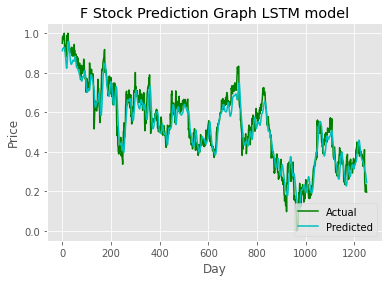

In [ ]:

mse, rmse, r2_value,true,predicted = evaluate_model(model,train,timesteps)
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))
plot_data(true,predicted)

###Prediction on Test Set

MSE = 0.0020912081804289654
RMSE = 0.04572972972180095
R-Squared Score = 0.9611619803713368


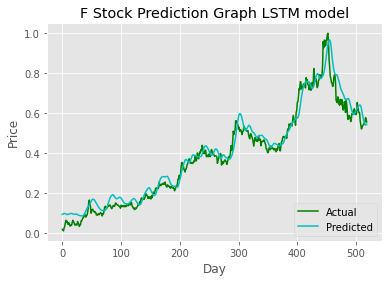

In [ ]:
mse, rmse, r2_value,true,predicted = evaluate_model(model,test,timesteps)
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))
plot_data(true,predicted)

#Pfizer

##Data Load, Preprocessing, and Modeling

###Information Load and Dataframe setup

In [ ]:
ticker = 'PFE'

In [ ]:
!rm -rf '/content/drive/MyDrive/Final Project Files/LSTM_Weights_'+ticker.hdf5

In [ ]:
start_date = '2014-12-08'
end_date = '2022-04-22'

yahoo_financials = YahooFinancials(ticker)
data = yahoo_financials.get_historical_price_data(start_date=start_date, 
                                                  end_date=end_date, 
                                                  time_interval='daily')
df = pd.DataFrame(data[ticker]['prices'])
df = df.drop('date', axis=1).set_index('formatted_date')
#df = df.reset_index()
#df = df.rename(columns={"formatted_date": "Date"})
df = df.dropna()

# Define periods
k_period = 14
d_period = 3
# Adds a "n_high" column with max value of previous 14 periods
df['n_high'] = df['high'].rolling(k_period).max()
# Adds an "n_low" column with min value of previous 14 periods
df['n_low'] = df['low'].rolling(k_period).min()
# Uses the min/max values to calculate the %k (as a percentage)
df['%K'] = (df['adjclose'] - df['n_low']) * 100 / (df['n_high'] - df['n_low'])
# Uses the %k to calculates a SMA over the past 3 values of %k
df['%D'] = df['%K'].rolling(d_period).mean()


# Add some indicators
df.ta.stoch(high='high', low='low', k=14, d=3, append=True)

df = df.dropna()
df = df.drop(['n_high', 'n_low', '%K', '%D'], axis=1)
df = df.rename(columns={"STOCHk_14_3_3": "Fast Osc. Signal", "STOCHd_14_3_3": "Slow Osc. Signal"})

df['Volume_lag'] = df['volume'].shift(1)
df['High_lag'] = df['high'].shift(1)
df['Low_lag'] = df['low'].shift(1)
df['Open_lag'] = df['open'].shift(1)
df['Adj_Close_lag'] = df['adjclose'].shift(1)
df['Fast Osc. Lag'] = df['Fast Osc. Signal'].shift(1)
df['Slow Osc. Lag'] = df['Slow Osc. Signal'].shift(1)
df = df.drop(['volume'], axis=1)
df = df.drop(['close'], axis=1)
df = df.drop(['low'], axis=1)
df = df.drop(['high'], axis=1)
df = df.drop(['open'], axis=1)
df = df.drop(['Fast Osc. Signal'], axis=1)
df = df.drop(['Slow Osc. Signal'], axis=1)
print(df)

                 adjclose  Volume_lag   High_lag    Low_lag   Open_lag  \
formatted_date                                                           
2015-01-02      22.779913         NaN        NaN        NaN        NaN   
2015-01-05      22.656303  16371571.0  30.151802  29.620493  29.667933   
2015-01-06      22.845356  24786391.0  29.800758  29.421251  29.743834   
2015-01-07      23.158003  29468681.0  30.227703  29.525618  29.667933   
2015-01-08      23.630613  20248816.0  30.237192  29.962049  30.094877   
...                   ...         ...        ...        ...        ...   
2022-04-14      53.119999  15777800.0  53.820000  52.700001  53.130001   
2022-04-18      51.840000  17197800.0  53.910000  53.040001  53.400002   
2022-04-19      50.180000  17065000.0  53.110001  51.630001  52.830002   
2022-04-20      49.750000  33441500.0  51.880001  49.369999  51.660000   
2022-04-21      49.110001  24751800.0  50.160000  49.209999  50.000000   

                Adj_Close_lag  Fast O

In [ ]:
# Get 30 year Bond Yield
yahoo_financials = YahooFinancials('^TYX')
data = yahoo_financials.get_historical_price_data(start_date=start_date, 
                                                  end_date=end_date, 
                                                  time_interval='daily')
yield_30yr = pd.DataFrame(data['^TYX']['prices'])
yield_30yr = yield_30yr.drop('date', axis=1).set_index('formatted_date')
#yield_30yr = yield_30yr.reset_index()
#yield_df = yield_30yr.rename(columns={"formatted_date": "Date"})
yield_df = yield_30yr.filter(['close'], axis=1)
yield_df = yield_df.dropna()
yield_df = yield_df.rename(columns={"close": "Bond_Yield"})
yield_df['Bond_Yield_Lag'] = yield_df['Bond_Yield'].shift(1)
yield_df = yield_df.drop(['Bond_Yield'], axis=1)
print(yield_df)

# Get Market Sentiment index
yahoo_financials = YahooFinancials('^VIX')
data = yahoo_financials.get_historical_price_data(start_date=start_date, 
                                                  end_date=end_date, 
                                                  time_interval='daily')
vix_df = pd.DataFrame(data['^VIX']['prices'])
vix_df = vix_df.drop('date', axis=1).set_index('formatted_date')
#vix_df = vix_df.reset_index()
#vix_df = vix_df.rename(columns={"formatted_date": "Date"})
vix_df = vix_df.filter(['close'], axis=1)
vix_df = vix_df.dropna()
vix_df = vix_df.rename(columns={"close": "VIX"})
vix_df['VIX_Lag'] = vix_df['VIX'].shift(1)
vix_df = vix_df.drop(['VIX'], axis = 1)
print(vix_df)


# Get Wilshire 5000 index
yahoo_financials = YahooFinancials('^W5000')
data = yahoo_financials.get_historical_price_data(start_date=start_date, 
                                                 end_date=end_date, 
                                                  time_interval='daily')
w5000 = pd.DataFrame(data['^W5000']['prices'])
w5000 = w5000.drop('date', axis=1).set_index('formatted_date')
#w5000 = w5000.reset_index()
#w5000 = w5000.rename(columns={"formatted_date": "Date"})
w5000 = w5000.filter(['close'], axis=1)
w5000 = w5000.dropna()
w5000 = w5000.rename(columns={"close": "Wilshire"})
w5000['Wilshire_Lag'] = w5000['Wilshire'].shift(1)
w5000 = w5000.drop(['Wilshire'], axis = 1)
print(w5000)

                Bond_Yield_Lag
formatted_date                
2014-12-08                 NaN
2014-12-09               2.901
2014-12-10               2.875
2014-12-11               2.835
2014-12-12               2.825
...                        ...
2022-04-14               2.794
2022-04-18               2.919
2022-04-19               2.953
2022-04-20               2.990
2022-04-21               2.879

[1854 rows x 1 columns]
                  VIX_Lag
formatted_date           
2014-12-08            NaN
2014-12-09      14.210000
2014-12-10      15.350000
2014-12-11      18.530001
2014-12-12      20.080000
...                   ...
2022-04-14      21.820000
2022-04-18      22.700001
2022-04-19      22.170000
2022-04-20      21.370001
2022-04-21      20.320000

[1856 rows x 1 columns]
                Wilshire_Lag
formatted_date              
2014-12-08               NaN
2014-12-09      21581.910156
2014-12-10      21536.179688
2014-12-11      21244.730469
2014-12-12      21338.890625
...   

In [ ]:
economic_df = yield_df.join(vix_df, on ='formatted_date')
economic_df = economic_df.join(w5000, on="formatted_date")
print(economic_df)

                Bond_Yield_Lag    VIX_Lag  Wilshire_Lag
formatted_date                                         
2014-12-08                 NaN        NaN           NaN
2014-12-09               2.901  14.210000  21581.910156
2014-12-10               2.875  15.350000  21536.179688
2014-12-11               2.835  18.530001  21244.730469
2014-12-12               2.825  20.080000  21338.890625
...                        ...        ...           ...
2022-04-14               2.794  21.820000  44732.468750
2022-04-18               2.919  22.700001  44180.851562
2022-04-19               2.953  22.170000  44086.601562
2022-04-20               2.990  21.370001  44967.039062
2022-04-21               2.879  20.320000  44774.980469

[1854 rows x 3 columns]


In [ ]:
df = df.join(economic_df,how='left', on = "formatted_date")

In [ ]:
sentiment_df = pd.read_csv('/content/drive/MyDrive/Final Project Files/'+ticker+'_Output.csv')
sentiment_df['formatted_date'] = sentiment_df['Date']
sentiment_df = sentiment_df.drop('Date', axis=1)
sentiment_df = sentiment_df.set_index('formatted_date')

In [ ]:
df = df.join(sentiment_df,how='left', on = "formatted_date")
df['Score_lag'] = df['Score_lag'].fillna(0)
df = df.iloc[1: , :]
print(df)

                 adjclose  Volume_lag   High_lag    Low_lag   Open_lag  \
formatted_date                                                           
2015-01-05      22.656303  16371571.0  30.151802  29.620493  29.667933   
2015-01-06      22.845356  24786391.0  29.800758  29.421251  29.743834   
2015-01-07      23.158003  29468681.0  30.227703  29.525618  29.667933   
2015-01-08      23.630613  20248816.0  30.237192  29.962049  30.094877   
2015-01-09      23.739677  49169522.0  30.967743  30.569260  30.683111   
...                   ...         ...        ...        ...        ...   
2022-04-14      53.119999  15777800.0  53.820000  52.700001  53.130001   
2022-04-18      51.840000  17197800.0  53.910000  53.040001  53.400002   
2022-04-19      50.180000  17065000.0  53.110001  51.630001  52.830002   
2022-04-20      49.750000  33441500.0  51.880001  49.369999  51.660000   
2022-04-21      49.110001  24751800.0  50.160000  49.209999  50.000000   

                Adj_Close_lag  Fast O

In [ ]:
df

,adjclose,Volume_lag,High_lag,Low_lag,Open_lag,Adj_Close_lag,Fast Osc. Lag,Slow Osc. Lag,Bond_Yield_Lag,VIX_Lag,Wilshire_Lag,Score_lag
formatted_date,,,,,,,,,,,,
2015-01-05,22.656303,16371571.0,30.151802,29.620493,29.667933,22.779913,33.130508,32.303362,2.697,17.790001,21665.320312,0.0000
2015-01-06,22.845356,24786391.0,29.800758,29.421251,29.743834,22.656303,34.348943,32.029464,2.605,19.920000,21269.060547,0.0000
2015-01-07,23.158003,29468681.0,30.227703,29.525618,29.667933,22.845356,43.838336,37.105929,2.523,21.120001,21060.250000,0.0000
2015-01-08,23.630613,20248816.0,30.237192,29.962049,30.094877,23.158003,54.343379,44.176886,2.515,19.309999,21301.669922,0.5859
2015-01-09,23.739677,49169522.0,30.967743,30.569260,30.683111,23.630613,73.464024,57.215246,2.593,17.010000,21672.390625,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-14,53.119999,15777800.0,53.820000,52.700001,53.130001,53.099998,50.588243,66.308851,2.794,21.820000,44732.468750,-0.3818
2022-04-18,51.840000,17197800.0,53.910000,53.040001,53.400002,53.119999,46.050421,54.214315,2.919,22.700001,44180.851562,-0.1027
2022-04-19,50.180000,17065000.0,53.110001,51.630001,52.830002,51.840000,38.935574,45.191413,2.953,22.170000,44086.601562,0.4939


In [ ]:
df = df.dropna()
df.corr()['adjclose']

adjclose          1.000000
Volume_lag        0.089493
High_lag          0.973292
Low_lag           0.971284
Open_lag          0.971367
Adj_Close_lag     0.997614
Fast Osc. Lag     0.086215
Slow Osc. Lag     0.091761
Bond_Yield_Lag   -0.349469
VIX_Lag           0.189561
Wilshire_Lag      0.884561
Score_lag         0.182812
Name: adjclose, dtype: float64

In [ ]:
df_pca = df

In [ ]:
df_pca

,adjclose,Volume_lag,High_lag,Low_lag,Open_lag,Adj_Close_lag,Fast Osc. Lag,Slow Osc. Lag,Bond_Yield_Lag,VIX_Lag,Wilshire_Lag,Score_lag
formatted_date,,,,,,,,,,,,
2015-01-05,22.656303,16371571.0,30.151802,29.620493,29.667933,22.779913,33.130508,32.303362,2.697,17.790001,21665.320312,0.0000
2015-01-06,22.845356,24786391.0,29.800758,29.421251,29.743834,22.656303,34.348943,32.029464,2.605,19.920000,21269.060547,0.0000
2015-01-07,23.158003,29468681.0,30.227703,29.525618,29.667933,22.845356,43.838336,37.105929,2.523,21.120001,21060.250000,0.0000
2015-01-08,23.630613,20248816.0,30.237192,29.962049,30.094877,23.158003,54.343379,44.176886,2.515,19.309999,21301.669922,0.5859
2015-01-09,23.739677,49169522.0,30.967743,30.569260,30.683111,23.630613,73.464024,57.215246,2.593,17.010000,21672.390625,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-14,53.119999,15777800.0,53.820000,52.700001,53.130001,53.099998,50.588243,66.308851,2.794,21.820000,44732.468750,-0.3818
2022-04-18,51.840000,17197800.0,53.910000,53.040001,53.400002,53.119999,46.050421,54.214315,2.919,22.700001,44180.851562,-0.1027
2022-04-19,50.180000,17065000.0,53.110001,51.630001,52.830002,51.840000,38.935574,45.191413,2.953,22.170000,44086.601562,0.4939


###Running PCA to reduce variables

In [ ]:
from sklearn.preprocessing import StandardScaler
features = ['Volume_lag', 'High_lag', 'Low_lag', 'Open_lag', 'Adj_Close_lag',
            'Fast Osc. Lag', 'Slow Osc. Lag', 'Bond_Yield_Lag', 'VIX_Lag',
            'Wilshire_Lag', 'Score_lag']
# Separating out the features
x = df_pca.loc[:, features].values
# Separating out the target
y = df_pca.loc[:,['adjclose']].values
# Standardizing the features
x = StandardScaler().fit_transform(x)
x

array([[-0.73983469, -1.04820062, -1.06970481, ..., -0.03987629,
        -1.02386581, -0.14285631],
       [-0.22768074, -1.1071212 , -1.1045713 , ...,  0.2318808 ,
        -1.07289718, -0.14285631],
       [ 0.05729901, -1.03546109, -1.08630761, ...,  0.38498355,
        -1.09873444, -0.14285631],
       ...,
       [-0.69763029,  2.80519495,  2.7818721 , ...,  0.51894827,
         1.75044113,  1.17171949],
       [ 0.29909799,  2.59874692,  2.38638067, ...,  0.41687994,
         1.85938244,  0.36338446],
       [-0.22978607,  2.31005506,  2.35838132, ...,  0.28291497,
         1.83561799, -1.65785236]])

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=4)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['PC 1', 'PC 2', 'PC 3', 'PC 4'])
principalDf

,PC 1,PC 2,PC 3,PC 4
0,-2.591680,0.749671,-0.573117,-0.133014
1,-2.565216,0.987337,-0.133519,-0.049247
2,-2.440270,0.827918,0.323638,-0.007007
3,-2.196124,0.378180,0.260283,1.310264
4,-2.045883,-0.286357,1.111427,0.469478
...,...,...,...,...
1825,5.678406,-0.824293,-1.603084,-1.752425
1826,5.720446,-0.427446,-1.870613,-1.038113
1827,5.540531,0.038352,-2.058989,0.459662
1828,5.044810,0.577890,-1.916465,0.052085


###Merging PCA to Adjust Close Price

In [ ]:
df_adjclose = df.reset_index()
df_adjclose = df_adjclose.rename(columns={"formatted_date": "Date"})
df_adjclose = df_adjclose[['adjclose']]
df_adjclose

,adjclose
0,22.656303
1,22.845356
2,23.158003
3,23.630613
4,23.739677
...,...
1825,53.119999
1826,51.840000
1827,50.180000
1828,49.750000


In [ ]:
finalDf = pd.merge(df_adjclose, principalDf, left_index=True, right_index=True)
finalDf

,adjclose,PC 1,PC 2,PC 3,PC 4
0,22.656303,-2.591680,0.749671,-0.573117,-0.133014
1,22.845356,-2.565216,0.987337,-0.133519,-0.049247
2,23.158003,-2.440270,0.827918,0.323638,-0.007007
3,23.630613,-2.196124,0.378180,0.260283,1.310264
4,23.739677,-2.045883,-0.286357,1.111427,0.469478
...,...,...,...,...,...
1825,53.119999,5.678406,-0.824293,-1.603084,-1.752425
1826,51.840000,5.720446,-0.427446,-1.870613,-1.038113
1827,50.180000,5.540531,0.038352,-2.058989,0.459662
1828,49.750000,5.044810,0.577890,-1.916465,0.052085


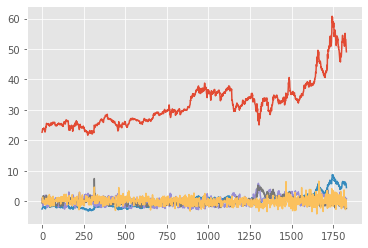

In [ ]:
plt.plot(finalDf)

###Split into Training and Test Set and scaling

In [ ]:
from sklearn.model_selection import train_test_split
sc = MinMaxScaler()

train, test = train_test_split(finalDf, test_size=0.3, shuffle = False)

In [ ]:
train = sc.fit_transform(train)

X_train = []
y_train = []
for i in range(DAYS, len(train)):
    X_train.append(train[i-DAYS:i]) # Chunks of training data with a length of 128 df-rows
    y_train.append(train[:, 0][i])
X_train, y_train = np.array(X_train), np.array(y_train)

print('Training set shape', X_train.shape, y_train.shape)

test = sc.fit_transform(test)

X_test, y_test = [], []
for i in range(DAYS, len(test)):
    X_test.append(test[i-DAYS:i])
    y_test.append(test[:, 0][i])    
X_test, y_test = np.array(X_test), np.array(y_test) 

print('Test set shape', X_test.shape, y_test.shape)

Training set shape (1251, 30, 5) (1251,)
Test set shape (519, 30, 5) (519,)


###Definitions to train, evaluate, and plot

In [ ]:
#Build and train the model
def fit_model(train,val,timesteps,hl,lr,batch,epochs):
    X_train = []
    Y_train = []
    X_val = []
    Y_val = []
  
    for i in range(timesteps,train.shape[0]):
        X_train.append(train[i-timesteps:i])
        Y_train.append(train[i][0])
    X_train,Y_train = np.array(X_train),np.array(Y_train)
  
    for i in range(timesteps,val.shape[0]):
        X_val.append(val[i-timesteps:i])
        Y_val.append(val[i][0])
    X_val,Y_val = np.array(X_val),np.array(Y_val)
    
    # Adding Layers to the model
    model = Sequential()
    model.add(LSTM(X_train.shape[2],input_shape = (X_train.shape[1],X_train.shape[2]),return_sequences = True,
                   activation = 'relu'))
    for i in range(len(hl)-1):        
        model.add(LSTM(hl[i],activation = 'relu',return_sequences = True))
    model.add(LSTM(hl[-1],activation = 'relu'))
    model.add(Dense(1))
    model.compile(optimizer = 'adam', loss = 'mean_squared_error')
  
    # Training the data
    history = model.fit(X_train,Y_train,epochs = epochs,batch_size = batch,validation_data = (X_val, Y_val),verbose = 0,
                        shuffle = False, callbacks=[checkpointer])
    model.reset_states()
    return model, history.history['loss'], history.history['val_loss']

In [ ]:
# Evaluating the model
def evaluate_model(model,test,timesteps):
    X_test = []
    Y_test = []

    for i in range(timesteps,test.shape[0]):
        X_test.append(test[i-timesteps:i])
        Y_test.append(test[i][0])
    X_test,Y_test = np.array(X_test),np.array(Y_test)
  
    Y_hat = model.predict(X_test)
    mse = mean_squared_error(Y_test,Y_hat)
    rmse = sqrt(mse)
    r = r2_score(Y_test,Y_hat)
    return mse, rmse, r, Y_test, Y_hat

In [ ]:
# Plotting the predictions
def plot_data(Y_test,Y_hat):
    plt.plot(Y_test,c = 'g')
    plt.plot(Y_hat,c = 'c')
    plt.xlabel('Day')
    plt.ylabel('Price')
    plt.title(ticker + ' Stock Prediction Graph LSTM model')
    plt.legend(['Actual','Predicted'],loc = 'lower right')
    plt.show()

In [ ]:
# Plotting the training errors
def plot_error(train_loss,val_loss):
    plt.plot(train_loss,c = 'r')
    plt.plot(val_loss,c = 'b')
    plt.ylabel('Loss')
    plt.legend(['train','val'],loc = 'upper right')
    plt.show()

###Set up callback

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint('/content/drive/MyDrive/Final Project Files/LSTM_Weights_'+ticker+'.hdf5', save_weights_only=True, save_best_only=True, verbose=1)

###Set hyper parameters and train model

In [ ]:
timesteps = DAYS
#hl = [40,35]
#lr = 1e-4
#batch_size = 32
#num_epochs = 30

model,train_error,test_error = fit_model(train,test,timesteps,hl,lr,batch_size,num_epochs)


Epoch 1: val_loss improved from inf to 0.04012, saving model to /content/drive/MyDrive/Final Project Files/LSTM_Weights_PFE.hdf5

Epoch 2: val_loss did not improve from 0.04012

Epoch 3: val_loss improved from 0.04012 to 0.03181, saving model to /content/drive/MyDrive/Final Project Files/LSTM_Weights_PFE.hdf5

Epoch 4: val_loss did not improve from 0.03181

Epoch 5: val_loss did not improve from 0.03181

Epoch 6: val_loss did not improve from 0.03181

Epoch 7: val_loss did not improve from 0.03181

Epoch 8: val_loss improved from 0.03181 to 0.02053, saving model to /content/drive/MyDrive/Final Project Files/LSTM_Weights_PFE.hdf5

Epoch 9: val_loss improved from 0.02053 to 0.01019, saving model to /content/drive/MyDrive/Final Project Files/LSTM_Weights_PFE.hdf5

Epoch 10: val_loss did not improve from 0.01019

Epoch 11: val_loss did not improve from 0.01019

Epoch 12: val_loss did not improve from 0.01019

Epoch 13: val_loss did not improve from 0.01019

Epoch 14: val_loss improved fro

##Results

###Plot of Loss through each Epoch

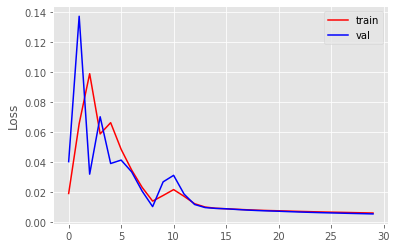

In [ ]:
plot_error(train_error,test_error)

###Prediction on Training set

MSE = 0.0059423091408888525
RMSE = 0.07708637454757392
R-Squared Score = 0.9063695367439715


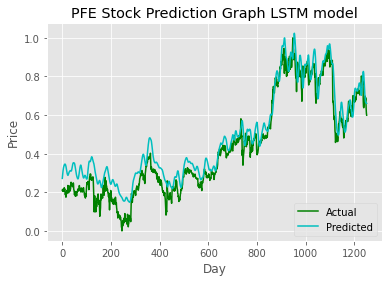

In [ ]:

mse, rmse, r2_value,true,predicted = evaluate_model(model,train,timesteps)
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))
plot_data(true,predicted)

###Prediction on Test Set

MSE = 0.005325981475576591
RMSE = 0.07297932224662401
R-Squared Score = 0.8920448511174024


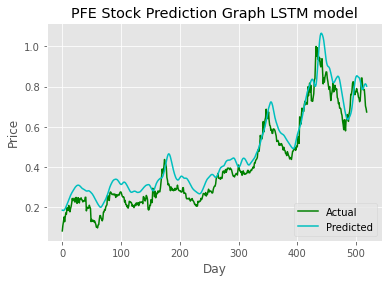

In [ ]:
mse, rmse, r2_value,true,predicted = evaluate_model(model,test,timesteps)
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))
plot_data(true,predicted)

#Eli Lilly

##Data Load, Preprocessing, and Modeling

###Information Load and Dataframe setup

In [ ]:
ticker = 'LLY'

In [ ]:
!rm -rf '/content/drive/MyDrive/Final Project Files/LSTM_Weights_'+ticker.hdf5

In [ ]:
start_date = '2014-12-08'
end_date = '2022-04-22'

yahoo_financials = YahooFinancials(ticker)
data = yahoo_financials.get_historical_price_data(start_date=start_date, 
                                                  end_date=end_date, 
                                                  time_interval='daily')
df = pd.DataFrame(data[ticker]['prices'])
df = df.drop('date', axis=1).set_index('formatted_date')
#df = df.reset_index()
#df = df.rename(columns={"formatted_date": "Date"})
df = df.dropna()

# Define periods
k_period = 14
d_period = 3
# Adds a "n_high" column with max value of previous 14 periods
df['n_high'] = df['high'].rolling(k_period).max()
# Adds an "n_low" column with min value of previous 14 periods
df['n_low'] = df['low'].rolling(k_period).min()
# Uses the min/max values to calculate the %k (as a percentage)
df['%K'] = (df['adjclose'] - df['n_low']) * 100 / (df['n_high'] - df['n_low'])
# Uses the %k to calculates a SMA over the past 3 values of %k
df['%D'] = df['%K'].rolling(d_period).mean()


# Add some indicators
df.ta.stoch(high='high', low='low', k=14, d=3, append=True)

df = df.dropna()
df = df.drop(['n_high', 'n_low', '%K', '%D'], axis=1)
df = df.rename(columns={"STOCHk_14_3_3": "Fast Osc. Signal", "STOCHd_14_3_3": "Slow Osc. Signal"})

df['Volume_lag'] = df['volume'].shift(1)
df['High_lag'] = df['high'].shift(1)
df['Low_lag'] = df['low'].shift(1)
df['Open_lag'] = df['open'].shift(1)
df['Adj_Close_lag'] = df['adjclose'].shift(1)
df['Fast Osc. Lag'] = df['Fast Osc. Signal'].shift(1)
df['Slow Osc. Lag'] = df['Slow Osc. Signal'].shift(1)
df = df.drop(['volume'], axis=1)
df = df.drop(['close'], axis=1)
df = df.drop(['low'], axis=1)
df = df.drop(['high'], axis=1)
df = df.drop(['open'], axis=1)
df = df.drop(['Fast Osc. Signal'], axis=1)
df = df.drop(['Slow Osc. Signal'], axis=1)
print(df)

                  adjclose  Volume_lag    High_lag     Low_lag    Open_lag  \
formatted_date                                                               
2015-01-02       59.414669         NaN         NaN         NaN         NaN   
2015-01-05       58.829517   3146200.0   70.820000   69.720001   69.769997   
2015-01-06       59.126331   4845500.0   70.089996   69.150002   69.730003   
2015-01-07       58.710773   5127400.0   70.910004   69.199997   69.919998   
2015-01-08       60.101608   9043000.0   70.529999   68.449997   70.029999   
...                    ...         ...         ...         ...         ...   
2022-04-14      301.859985   2528700.0  308.299988  300.410004  307.279999   
2022-04-18      298.820007   1891600.0  304.470001  300.190002  303.750000   
2022-04-19      297.010010   1581400.0  302.059998  296.799988  301.070007   
2022-04-20      292.920013   2021700.0  299.690002  293.799988  298.410004   
2022-04-21      289.609985   2608600.0  299.000000  292.299988  

In [ ]:
# Get 30 year Bond Yield
yahoo_financials = YahooFinancials('^TYX')
data = yahoo_financials.get_historical_price_data(start_date=start_date, 
                                                  end_date=end_date, 
                                                  time_interval='daily')
yield_30yr = pd.DataFrame(data['^TYX']['prices'])
yield_30yr = yield_30yr.drop('date', axis=1).set_index('formatted_date')
#yield_30yr = yield_30yr.reset_index()
#yield_df = yield_30yr.rename(columns={"formatted_date": "Date"})
yield_df = yield_30yr.filter(['close'], axis=1)
yield_df = yield_df.dropna()
yield_df = yield_df.rename(columns={"close": "Bond_Yield"})
yield_df['Bond_Yield_Lag'] = yield_df['Bond_Yield'].shift(1)
yield_df = yield_df.drop(['Bond_Yield'], axis=1)
print(yield_df)

# Get Market Sentiment index
yahoo_financials = YahooFinancials('^VIX')
data = yahoo_financials.get_historical_price_data(start_date=start_date, 
                                                  end_date=end_date, 
                                                  time_interval='daily')
vix_df = pd.DataFrame(data['^VIX']['prices'])
vix_df = vix_df.drop('date', axis=1).set_index('formatted_date')
#vix_df = vix_df.reset_index()
#vix_df = vix_df.rename(columns={"formatted_date": "Date"})
vix_df = vix_df.filter(['close'], axis=1)
vix_df = vix_df.dropna()
vix_df = vix_df.rename(columns={"close": "VIX"})
vix_df['VIX_Lag'] = vix_df['VIX'].shift(1)
vix_df = vix_df.drop(['VIX'], axis = 1)
print(vix_df)


# Get Wilshire 5000 index
yahoo_financials = YahooFinancials('^W5000')
data = yahoo_financials.get_historical_price_data(start_date=start_date, 
                                                 end_date=end_date, 
                                                  time_interval='daily')
w5000 = pd.DataFrame(data['^W5000']['prices'])
w5000 = w5000.drop('date', axis=1).set_index('formatted_date')
#w5000 = w5000.reset_index()
#w5000 = w5000.rename(columns={"formatted_date": "Date"})
w5000 = w5000.filter(['close'], axis=1)
w5000 = w5000.dropna()
w5000 = w5000.rename(columns={"close": "Wilshire"})
w5000['Wilshire_Lag'] = w5000['Wilshire'].shift(1)
w5000 = w5000.drop(['Wilshire'], axis = 1)
print(w5000)

                Bond_Yield_Lag
formatted_date                
2014-12-08                 NaN
2014-12-09               2.901
2014-12-10               2.875
2014-12-11               2.835
2014-12-12               2.825
...                        ...
2022-04-14               2.794
2022-04-18               2.919
2022-04-19               2.953
2022-04-20               2.990
2022-04-21               2.879

[1854 rows x 1 columns]
                  VIX_Lag
formatted_date           
2014-12-08            NaN
2014-12-09      14.210000
2014-12-10      15.350000
2014-12-11      18.530001
2014-12-12      20.080000
...                   ...
2022-04-14      21.820000
2022-04-18      22.700001
2022-04-19      22.170000
2022-04-20      21.370001
2022-04-21      20.320000

[1856 rows x 1 columns]
                Wilshire_Lag
formatted_date              
2014-12-08               NaN
2014-12-09      21581.910156
2014-12-10      21536.179688
2014-12-11      21244.730469
2014-12-12      21338.890625
...   

In [ ]:
economic_df = yield_df.join(vix_df, on ='formatted_date')
economic_df = economic_df.join(w5000, on="formatted_date")
print(economic_df)

                Bond_Yield_Lag    VIX_Lag  Wilshire_Lag
formatted_date                                         
2014-12-08                 NaN        NaN           NaN
2014-12-09               2.901  14.210000  21581.910156
2014-12-10               2.875  15.350000  21536.179688
2014-12-11               2.835  18.530001  21244.730469
2014-12-12               2.825  20.080000  21338.890625
...                        ...        ...           ...
2022-04-14               2.794  21.820000  44732.468750
2022-04-18               2.919  22.700001  44180.851562
2022-04-19               2.953  22.170000  44086.601562
2022-04-20               2.990  21.370001  44967.039062
2022-04-21               2.879  20.320000  44774.980469

[1854 rows x 3 columns]


In [ ]:
df = df.join(economic_df,how='left', on = "formatted_date")

In [ ]:
sentiment_df = pd.read_csv('/content/drive/MyDrive/Final Project Files/'+ticker+'_Output.csv')
sentiment_df['formatted_date'] = sentiment_df['Date']
sentiment_df = sentiment_df.drop('Date', axis=1)
sentiment_df = sentiment_df.set_index('formatted_date')

In [ ]:
df = df.join(sentiment_df,how='left', on = "formatted_date")
df['Score_lag'] = df['Score_lag'].fillna(0)
df = df.iloc[1: , :]
print(df)

                  adjclose  Volume_lag    High_lag     Low_lag    Open_lag  \
formatted_date                                                               
2015-01-05       58.829517   3146200.0   70.820000   69.720001   69.769997   
2015-01-06       59.126331   4845500.0   70.089996   69.150002   69.730003   
2015-01-07       58.710773   5127400.0   70.910004   69.199997   69.919998   
2015-01-08       60.101608   9043000.0   70.529999   68.449997   70.029999   
2015-01-09       59.304420   7472200.0   71.489998   69.660004   70.000000   
...                    ...         ...         ...         ...         ...   
2022-04-14      301.859985   2528700.0  308.299988  300.410004  307.279999   
2022-04-18      298.820007   1891600.0  304.470001  300.190002  303.750000   
2022-04-19      297.010010   1581400.0  302.059998  296.799988  301.070007   
2022-04-20      292.920013   2021700.0  299.690002  293.799988  298.410004   
2022-04-21      289.609985   2608600.0  299.000000  292.299988  

In [ ]:
df

,adjclose,Volume_lag,High_lag,Low_lag,Open_lag,Adj_Close_lag,Fast Osc. Lag,Slow Osc. Lag,Bond_Yield_Lag,VIX_Lag,Wilshire_Lag,Score_lag
formatted_date,,,,,,,,,,,,
2015-01-05,58.829517,3146200.0,70.820000,69.720001,69.769997,59.414669,13.870667,13.525594,2.697,17.790001,21665.320312,0.0000
2015-01-06,59.126331,4845500.0,70.089996,69.150002,69.730003,58.829517,14.354505,12.654540,2.605,19.920000,21269.060547,0.0000
2015-01-07,58.710773,5127400.0,70.910004,69.199997,69.919998,59.126331,21.090246,16.438473,2.523,21.120001,21060.250000,0.0000
2015-01-08,60.101608,9043000.0,70.529999,68.449997,70.029999,58.710773,17.167790,17.537514,2.515,19.309999,21301.669922,0.0000
2015-01-09,59.304420,7472200.0,71.489998,69.660004,70.000000,60.101608,32.396433,23.551490,2.593,17.010000,21672.390625,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-14,301.859985,2528700.0,308.299988,300.410004,307.279999,302.670013,75.352083,82.243225,2.794,21.820000,44732.468750,0.0000
2022-04-18,298.820007,1891600.0,304.470001,300.190002,303.750000,301.859985,67.344428,76.041745,2.919,22.700001,44180.851562,-0.2009
2022-04-19,297.010010,1581400.0,302.059998,296.799988,301.070007,298.820007,57.055562,66.584025,2.953,22.170000,44086.601562,0.0000


In [ ]:
df = df.dropna()
df.corr()['adjclose']

adjclose          1.000000
Volume_lag       -0.099918
High_lag          0.998646
Low_lag           0.998590
Open_lag          0.998299
Adj_Close_lag     0.999212
Fast Osc. Lag     0.070286
Slow Osc. Lag     0.074326
Bond_Yield_Lag   -0.565920
VIX_Lag           0.351788
Wilshire_Lag      0.946357
Score_lag         0.001077
Name: adjclose, dtype: float64

In [ ]:
df_pca = df

In [ ]:
df_pca

,adjclose,Volume_lag,High_lag,Low_lag,Open_lag,Adj_Close_lag,Fast Osc. Lag,Slow Osc. Lag,Bond_Yield_Lag,VIX_Lag,Wilshire_Lag,Score_lag
formatted_date,,,,,,,,,,,,
2015-01-05,58.829517,3146200.0,70.820000,69.720001,69.769997,59.414669,13.870667,13.525594,2.697,17.790001,21665.320312,0.0000
2015-01-06,59.126331,4845500.0,70.089996,69.150002,69.730003,58.829517,14.354505,12.654540,2.605,19.920000,21269.060547,0.0000
2015-01-07,58.710773,5127400.0,70.910004,69.199997,69.919998,59.126331,21.090246,16.438473,2.523,21.120001,21060.250000,0.0000
2015-01-08,60.101608,9043000.0,70.529999,68.449997,70.029999,58.710773,17.167790,17.537514,2.515,19.309999,21301.669922,0.0000
2015-01-09,59.304420,7472200.0,71.489998,69.660004,70.000000,60.101608,32.396433,23.551490,2.593,17.010000,21672.390625,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-14,301.859985,2528700.0,308.299988,300.410004,307.279999,302.670013,75.352083,82.243225,2.794,21.820000,44732.468750,0.0000
2022-04-18,298.820007,1891600.0,304.470001,300.190002,303.750000,301.859985,67.344428,76.041745,2.919,22.700001,44180.851562,-0.2009
2022-04-19,297.010010,1581400.0,302.059998,296.799988,301.070007,298.820007,57.055562,66.584025,2.953,22.170000,44086.601562,0.0000


###Running PCA to reduce variables

In [ ]:
from sklearn.preprocessing import StandardScaler
features = ['Volume_lag', 'High_lag', 'Low_lag', 'Open_lag', 'Adj_Close_lag',
            'Fast Osc. Lag', 'Slow Osc. Lag', 'Bond_Yield_Lag', 'VIX_Lag',
            'Wilshire_Lag', 'Score_lag']
# Separating out the features
x = df_pca.loc[:, features].values
# Separating out the target
y = df_pca.loc[:,['adjclose']].values
# Standardizing the features
x = StandardScaler().fit_transform(x)
x

array([[-0.28466971, -0.9076438 , -0.90546019, ..., -0.03987629,
        -1.02386581, -0.04675915],
       [ 0.06873611, -0.9199127 , -0.91528973, ...,  0.2318808 ,
        -1.07289718, -0.04675915],
       [ 0.12736325, -0.90613114, -0.91442757, ...,  0.38498355,
        -1.09873444, -0.04675915],
       ...,
       [-0.61010338,  2.97872089,  3.01049258, ...,  0.51894827,
         1.75044113, -0.04675915],
       [-0.51853357,  2.93888926,  2.95875813, ...,  0.41687994,
         1.85938244, -0.04675915],
       [-0.39647514,  2.92729265,  2.9328909 , ...,  0.28291497,
         1.83561799, -0.04675915]])

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=4)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['PC 1', 'PC 2', 'PC 3', 'PC 4'])
principalDf

,PC 1,PC 2,PC 3,PC 4
0,-2.145149,2.185742,-0.188783,-0.154804
1,-2.101291,2.264721,0.004962,0.217359
2,-2.022869,2.050441,-0.014517,0.485819
3,-2.110761,2.043003,0.558763,0.466158
4,-2.120474,1.435730,0.328323,0.223411
...,...,...,...,...
1825,5.963883,-1.442436,0.290885,-1.395552
1826,5.823919,-1.062614,-0.291108,-1.534887
1827,5.689566,-0.599789,0.263287,-1.697660
1828,5.603378,-0.265077,0.375152,-1.886824


###Merging PCA to Adjust Close Price

In [ ]:
df_adjclose = df.reset_index()
df_adjclose = df_adjclose.rename(columns={"formatted_date": "Date"})
df_adjclose = df_adjclose[['adjclose']]
df_adjclose

,adjclose
0,58.829517
1,59.126331
2,58.710773
3,60.101608
4,59.304420
...,...
1825,301.859985
1826,298.820007
1827,297.010010
1828,292.920013


In [ ]:
finalDf = pd.merge(df_adjclose, principalDf, left_index=True, right_index=True)
finalDf

,adjclose,PC 1,PC 2,PC 3,PC 4
0,58.829517,-2.145149,2.185742,-0.188783,-0.154804
1,59.126331,-2.101291,2.264721,0.004962,0.217359
2,58.710773,-2.022869,2.050441,-0.014517,0.485819
3,60.101608,-2.110761,2.043003,0.558763,0.466158
4,59.304420,-2.120474,1.435730,0.328323,0.223411
...,...,...,...,...,...
1825,301.859985,5.963883,-1.442436,0.290885,-1.395552
1826,298.820007,5.823919,-1.062614,-0.291108,-1.534887
1827,297.010010,5.689566,-0.599789,0.263287,-1.697660
1828,292.920013,5.603378,-0.265077,0.375152,-1.886824


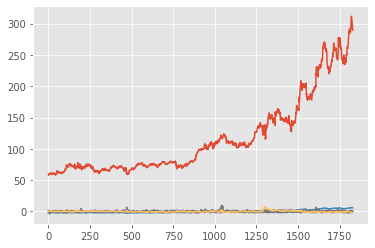

In [ ]:
plt.plot(finalDf)

###Split into Training and Test Set and scaling

In [ ]:
from sklearn.model_selection import train_test_split
sc = MinMaxScaler()

train, test = train_test_split(finalDf, test_size=0.3, shuffle = False)

In [ ]:
train = sc.fit_transform(train)

X_train = []
y_train = []
for i in range(DAYS, len(train)):
    X_train.append(train[i-DAYS:i]) # Chunks of training data with a length of 128 df-rows
    y_train.append(train[:, 0][i])
X_train, y_train = np.array(X_train), np.array(y_train)

print('Training set shape', X_train.shape, y_train.shape)

test = sc.fit_transform(test)

X_test, y_test = [], []
for i in range(DAYS, len(test)):
    X_test.append(test[i-DAYS:i])
    y_test.append(test[:, 0][i])    
X_test, y_test = np.array(X_test), np.array(y_test) 

print('Test set shape', X_test.shape, y_test.shape)

Training set shape (1251, 30, 5) (1251,)
Test set shape (519, 30, 5) (519,)


###Definitions to train, evaluate, and plot

In [ ]:
#Build and train the model
def fit_model(train,val,timesteps,hl,lr,batch,epochs):
    X_train = []
    Y_train = []
    X_val = []
    Y_val = []
  
    for i in range(timesteps,train.shape[0]):
        X_train.append(train[i-timesteps:i])
        Y_train.append(train[i][0])
    X_train,Y_train = np.array(X_train),np.array(Y_train)
  
    for i in range(timesteps,val.shape[0]):
        X_val.append(val[i-timesteps:i])
        Y_val.append(val[i][0])
    X_val,Y_val = np.array(X_val),np.array(Y_val)
    
    # Adding Layers to the model
    model = Sequential()
    model.add(LSTM(X_train.shape[2],input_shape = (X_train.shape[1],X_train.shape[2]),return_sequences = True,
                   activation = 'relu'))
    for i in range(len(hl)-1):        
        model.add(LSTM(hl[i],activation = 'relu',return_sequences = True))
    model.add(LSTM(hl[-1],activation = 'relu'))
    model.add(Dense(1))
    model.compile(optimizer = 'adam', loss = 'mean_squared_error')
  
    # Training the data
    history = model.fit(X_train,Y_train,epochs = epochs,batch_size = batch,validation_data = (X_val, Y_val),verbose = 0,
                        shuffle = False, callbacks=[checkpointer])
    model.reset_states()
    return model, history.history['loss'], history.history['val_loss']

In [ ]:
# Evaluating the model
def evaluate_model(model,test,timesteps):
    X_test = []
    Y_test = []

    for i in range(timesteps,test.shape[0]):
        X_test.append(test[i-timesteps:i])
        Y_test.append(test[i][0])
    X_test,Y_test = np.array(X_test),np.array(Y_test)
  
    Y_hat = model.predict(X_test)
    mse = mean_squared_error(Y_test,Y_hat)
    rmse = sqrt(mse)
    r = r2_score(Y_test,Y_hat)
    return mse, rmse, r, Y_test, Y_hat

In [ ]:
# Plotting the predictions
def plot_data(Y_test,Y_hat):
    plt.plot(Y_test,c = 'g')
    plt.plot(Y_hat,c = 'c')
    plt.xlabel('Day')
    plt.ylabel('Price')
    plt.title(ticker + ' Stock Prediction Graph LSTM model')
    plt.legend(['Actual','Predicted'],loc = 'lower right')
    plt.show()

In [ ]:
# Plotting the training errors
def plot_error(train_loss,val_loss):
    plt.plot(train_loss,c = 'r')
    plt.plot(val_loss,c = 'b')
    plt.ylabel('Loss')
    plt.legend(['train','val'],loc = 'upper right')
    plt.show()

###Set up callback

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint('/content/drive/MyDrive/Final Project Files/LSTM_Weights_'+ticker+'.hdf5', save_weights_only=True, save_best_only=True, verbose=1)

###Set hyper parameters and train model

In [ ]:
timesteps = DAYS
#hl = [40,35]
#lr = 1e-4
#batch_size = 32
#num_epochs = 30

model,train_error,test_error = fit_model(train,test,timesteps,hl,lr,batch_size,num_epochs)


Epoch 1: val_loss improved from inf to 0.04623, saving model to /content/drive/MyDrive/Final Project Files/LSTM_Weights_LLY.hdf5

Epoch 2: val_loss did not improve from 0.04623

Epoch 3: val_loss improved from 0.04623 to 0.04273, saving model to /content/drive/MyDrive/Final Project Files/LSTM_Weights_LLY.hdf5

Epoch 4: val_loss did not improve from 0.04273

Epoch 5: val_loss improved from 0.04273 to 0.02692, saving model to /content/drive/MyDrive/Final Project Files/LSTM_Weights_LLY.hdf5

Epoch 6: val_loss improved from 0.02692 to 0.02562, saving model to /content/drive/MyDrive/Final Project Files/LSTM_Weights_LLY.hdf5

Epoch 7: val_loss improved from 0.02562 to 0.01988, saving model to /content/drive/MyDrive/Final Project Files/LSTM_Weights_LLY.hdf5

Epoch 8: val_loss did not improve from 0.01988

Epoch 9: val_loss improved from 0.01988 to 0.01417, saving model to /content/drive/MyDrive/Final Project Files/LSTM_Weights_LLY.hdf5

Epoch 10: val_loss improved from 0.01417 to 0.00820, sa

##Results

###Plot of Loss through each Epoch

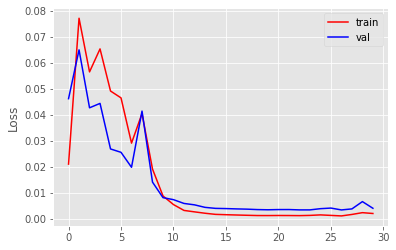

In [ ]:
plot_error(train_error,test_error)

###Prediction on Training set

MSE = 0.0034347394612507082
RMSE = 0.05860665031590449
R-Squared Score = 0.9370630033345181


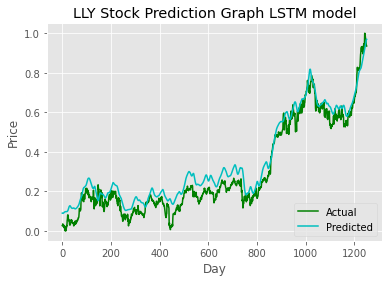

In [ ]:

mse, rmse, r2_value,true,predicted = evaluate_model(model,train,timesteps)
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))
plot_data(true,predicted)

###Prediction on Test Set

MSE = 0.004122186696712549
RMSE = 0.06420425762138013
R-Squared Score = 0.9332283469219366


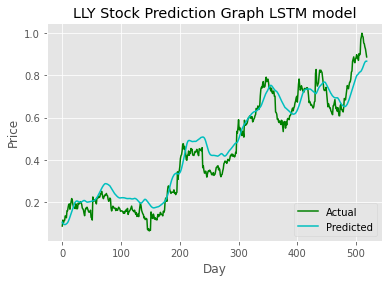

In [ ]:
mse, rmse, r2_value,true,predicted = evaluate_model(model,test,timesteps)
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))
plot_data(true,predicted)

#Danaher

##Data Load, Preprocessing, and Modeling

###Information Load and Dataframe setup

In [ ]:
ticker = 'DHR'

In [ ]:
!rm -rf '/content/drive/MyDrive/Final Project Files/LSTM_Weights_'+ticker.hdf5

In [ ]:
start_date = '2014-12-08'
end_date = '2022-04-22'

yahoo_financials = YahooFinancials(ticker)
data = yahoo_financials.get_historical_price_data(start_date=start_date, 
                                                  end_date=end_date, 
                                                  time_interval='daily')
df = pd.DataFrame(data[ticker]['prices'])
df = df.drop('date', axis=1).set_index('formatted_date')
#df = df.reset_index()
#df = df.rename(columns={"formatted_date": "Date"})
df = df.dropna()

# Define periods
k_period = 14
d_period = 3
# Adds a "n_high" column with max value of previous 14 periods
df['n_high'] = df['high'].rolling(k_period).max()
# Adds an "n_low" column with min value of previous 14 periods
df['n_low'] = df['low'].rolling(k_period).min()
# Uses the min/max values to calculate the %k (as a percentage)
df['%K'] = (df['adjclose'] - df['n_low']) * 100 / (df['n_high'] - df['n_low'])
# Uses the %k to calculates a SMA over the past 3 values of %k
df['%D'] = df['%K'].rolling(d_period).mean()


# Add some indicators
df.ta.stoch(high='high', low='low', k=14, d=3, append=True)

df = df.dropna()
df = df.drop(['n_high', 'n_low', '%K', '%D'], axis=1)
df = df.rename(columns={"STOCHk_14_3_3": "Fast Osc. Signal", "STOCHd_14_3_3": "Slow Osc. Signal"})

df['Volume_lag'] = df['volume'].shift(1)
df['High_lag'] = df['high'].shift(1)
df['Low_lag'] = df['low'].shift(1)
df['Open_lag'] = df['open'].shift(1)
df['Adj_Close_lag'] = df['adjclose'].shift(1)
df['Fast Osc. Lag'] = df['Fast Osc. Signal'].shift(1)
df['Slow Osc. Lag'] = df['Slow Osc. Signal'].shift(1)
df = df.drop(['volume'], axis=1)
df = df.drop(['close'], axis=1)
df = df.drop(['low'], axis=1)
df = df.drop(['high'], axis=1)
df = df.drop(['open'], axis=1)
df = df.drop(['Fast Osc. Signal'], axis=1)
df = df.drop(['Slow Osc. Signal'], axis=1)
print(df)

                  adjclose  Volume_lag    High_lag     Low_lag    Open_lag  \
formatted_date                                                               
2015-01-02       62.540123         NaN         NaN         NaN         NaN   
2015-01-05       61.919968   2722152.0   65.420776   64.526154   65.208488   
2015-01-06       61.496815   3985095.0   64.897652   64.025780   64.662621   
2015-01-07       61.868904   3807030.0   64.700531   63.366188   64.541321   
2015-01-08       62.824677   4361801.0   64.715691   64.116753   64.495827   
...                    ...         ...         ...         ...         ...   
2022-04-14      276.980011   2783100.0  284.920013  277.760010  281.500000   
2022-04-18      275.070007   3087000.0  285.230011  276.320007  285.140015   
2022-04-19      273.100006   1941100.0  276.790009  272.420013  274.989990   
2022-04-20      280.380005   3565800.0  277.920013  272.769989  276.380005   
2022-04-21      278.239990   3793300.0  284.000000  273.920013  

In [ ]:
# Get 30 year Bond Yield
yahoo_financials = YahooFinancials('^TYX')
data = yahoo_financials.get_historical_price_data(start_date=start_date, 
                                                  end_date=end_date, 
                                                  time_interval='daily')
yield_30yr = pd.DataFrame(data['^TYX']['prices'])
yield_30yr = yield_30yr.drop('date', axis=1).set_index('formatted_date')
#yield_30yr = yield_30yr.reset_index()
#yield_df = yield_30yr.rename(columns={"formatted_date": "Date"})
yield_df = yield_30yr.filter(['close'], axis=1)
yield_df = yield_df.dropna()
yield_df = yield_df.rename(columns={"close": "Bond_Yield"})
yield_df['Bond_Yield_Lag'] = yield_df['Bond_Yield'].shift(1)
yield_df = yield_df.drop(['Bond_Yield'], axis=1)
print(yield_df)

# Get Market Sentiment index
yahoo_financials = YahooFinancials('^VIX')
data = yahoo_financials.get_historical_price_data(start_date=start_date, 
                                                  end_date=end_date, 
                                                  time_interval='daily')
vix_df = pd.DataFrame(data['^VIX']['prices'])
vix_df = vix_df.drop('date', axis=1).set_index('formatted_date')
#vix_df = vix_df.reset_index()
#vix_df = vix_df.rename(columns={"formatted_date": "Date"})
vix_df = vix_df.filter(['close'], axis=1)
vix_df = vix_df.dropna()
vix_df = vix_df.rename(columns={"close": "VIX"})
vix_df['VIX_Lag'] = vix_df['VIX'].shift(1)
vix_df = vix_df.drop(['VIX'], axis = 1)
print(vix_df)


# Get Wilshire 5000 index
yahoo_financials = YahooFinancials('^W5000')
data = yahoo_financials.get_historical_price_data(start_date=start_date, 
                                                 end_date=end_date, 
                                                  time_interval='daily')
w5000 = pd.DataFrame(data['^W5000']['prices'])
w5000 = w5000.drop('date', axis=1).set_index('formatted_date')
#w5000 = w5000.reset_index()
#w5000 = w5000.rename(columns={"formatted_date": "Date"})
w5000 = w5000.filter(['close'], axis=1)
w5000 = w5000.dropna()
w5000 = w5000.rename(columns={"close": "Wilshire"})
w5000['Wilshire_Lag'] = w5000['Wilshire'].shift(1)
w5000 = w5000.drop(['Wilshire'], axis = 1)
print(w5000)

                Bond_Yield_Lag
formatted_date                
2014-12-08                 NaN
2014-12-09               2.901
2014-12-10               2.875
2014-12-11               2.835
2014-12-12               2.825
...                        ...
2022-04-14               2.794
2022-04-18               2.919
2022-04-19               2.953
2022-04-20               2.990
2022-04-21               2.879

[1854 rows x 1 columns]
                  VIX_Lag
formatted_date           
2014-12-08            NaN
2014-12-09      14.210000
2014-12-10      15.350000
2014-12-11      18.530001
2014-12-12      20.080000
...                   ...
2022-04-14      21.820000
2022-04-18      22.700001
2022-04-19      22.170000
2022-04-20      21.370001
2022-04-21      20.320000

[1856 rows x 1 columns]
                Wilshire_Lag
formatted_date              
2014-12-08               NaN
2014-12-09      21581.910156
2014-12-10      21536.179688
2014-12-11      21244.730469
2014-12-12      21338.890625
...   

In [ ]:
economic_df = yield_df.join(vix_df, on ='formatted_date')
economic_df = economic_df.join(w5000, on="formatted_date")
print(economic_df)

                Bond_Yield_Lag    VIX_Lag  Wilshire_Lag
formatted_date                                         
2014-12-08                 NaN        NaN           NaN
2014-12-09               2.901  14.210000  21581.910156
2014-12-10               2.875  15.350000  21536.179688
2014-12-11               2.835  18.530001  21244.730469
2014-12-12               2.825  20.080000  21338.890625
...                        ...        ...           ...
2022-04-14               2.794  21.820000  44732.468750
2022-04-18               2.919  22.700001  44180.851562
2022-04-19               2.953  22.170000  44086.601562
2022-04-20               2.990  21.370001  44967.039062
2022-04-21               2.879  20.320000  44774.980469

[1854 rows x 3 columns]


In [ ]:
df = df.join(economic_df,how='left', on = "formatted_date")

In [ ]:
sentiment_df = pd.read_csv('/content/drive/MyDrive/Final Project Files/'+ticker+'_Output.csv')
sentiment_df['formatted_date'] = sentiment_df['Date']
sentiment_df = sentiment_df.drop('Date', axis=1)
sentiment_df = sentiment_df.set_index('formatted_date')

In [ ]:
df = df.join(sentiment_df,how='left', on = "formatted_date")
df['Score_lag'] = df['Score_lag'].fillna(0)
df = df.iloc[1: , :]
print(df)

                  adjclose  Volume_lag    High_lag     Low_lag    Open_lag  \
formatted_date                                                               
2015-01-05       61.919968   2722152.0   65.420776   64.526154   65.208488   
2015-01-06       61.496815   3985095.0   64.897652   64.025780   64.662621   
2015-01-07       61.868904   3807030.0   64.700531   63.366188   64.541321   
2015-01-08       62.824677   4361801.0   64.715691   64.116753   64.495827   
2015-01-09       62.401501   3904240.0   65.413193   64.836998   64.897652   
...                    ...         ...         ...         ...         ...   
2022-04-14      276.980011   2783100.0  284.920013  277.760010  281.500000   
2022-04-18      275.070007   3087000.0  285.230011  276.320007  285.140015   
2022-04-19      273.100006   1941100.0  276.790009  272.420013  274.989990   
2022-04-20      280.380005   3565800.0  277.920013  272.769989  276.380005   
2022-04-21      278.239990   3793300.0  284.000000  273.920013  

In [ ]:
df

,adjclose,Volume_lag,High_lag,Low_lag,Open_lag,Adj_Close_lag,Fast Osc. Lag,Slow Osc. Lag,Bond_Yield_Lag,VIX_Lag,Wilshire_Lag,Score_lag
formatted_date,,,,,,,,,,,,
2015-01-05,61.919968,2722152.0,65.420776,64.526154,65.208488,62.540123,71.631228,78.211212,2.697,17.790001,21665.320312,0.0000
2015-01-06,61.496815,3985095.0,64.897652,64.025780,64.662621,61.919968,63.534294,71.217520,2.605,19.920000,21269.060547,0.0000
2015-01-07,61.868904,3807030.0,64.700531,63.366188,64.541321,61.496815,55.141827,63.435783,2.523,21.120001,21060.250000,0.0000
2015-01-08,62.824677,4361801.0,64.715691,64.116753,64.495827,61.868904,49.704498,56.126873,2.515,19.309999,21301.669922,0.0000
2015-01-09,62.401501,3904240.0,65.413193,64.836998,64.897652,62.824677,53.424467,52.756931,2.593,17.010000,21672.390625,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-14,276.980011,2783100.0,284.920013,277.760010,281.500000,283.720001,24.296704,46.640349,2.794,21.820000,44732.468750,0.0000
2022-04-18,275.070007,3087000.0,285.230011,276.320007,285.140015,276.980011,10.904746,26.298346,2.919,22.700001,44180.851562,0.0000
2022-04-19,273.100006,1941100.0,276.790009,272.420013,274.989990,275.070007,11.532055,15.577835,2.953,22.170000,44086.601562,0.0000


In [ ]:
df = df.dropna()
df.corr()['adjclose']

adjclose          1.000000
Volume_lag       -0.082808
High_lag          0.999351
Low_lag           0.999314
Open_lag          0.999121
Adj_Close_lag     0.999511
Fast Osc. Lag     0.081508
Slow Osc. Lag     0.085335
Bond_Yield_Lag   -0.638306
VIX_Lag           0.327844
Wilshire_Lag      0.973067
Score_lag         0.011559
Name: adjclose, dtype: float64

In [ ]:
df_pca = df

In [ ]:
df_pca

,adjclose,Volume_lag,High_lag,Low_lag,Open_lag,Adj_Close_lag,Fast Osc. Lag,Slow Osc. Lag,Bond_Yield_Lag,VIX_Lag,Wilshire_Lag,Score_lag
formatted_date,,,,,,,,,,,,
2015-01-05,61.919968,2722152.0,65.420776,64.526154,65.208488,62.540123,71.631228,78.211212,2.697,17.790001,21665.320312,0.0000
2015-01-06,61.496815,3985095.0,64.897652,64.025780,64.662621,61.919968,63.534294,71.217520,2.605,19.920000,21269.060547,0.0000
2015-01-07,61.868904,3807030.0,64.700531,63.366188,64.541321,61.496815,55.141827,63.435783,2.523,21.120001,21060.250000,0.0000
2015-01-08,62.824677,4361801.0,64.715691,64.116753,64.495827,61.868904,49.704498,56.126873,2.515,19.309999,21301.669922,0.0000
2015-01-09,62.401501,3904240.0,65.413193,64.836998,64.897652,62.824677,53.424467,52.756931,2.593,17.010000,21672.390625,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-14,276.980011,2783100.0,284.920013,277.760010,281.500000,283.720001,24.296704,46.640349,2.794,21.820000,44732.468750,0.0000
2022-04-18,275.070007,3087000.0,285.230011,276.320007,285.140015,276.980011,10.904746,26.298346,2.919,22.700001,44180.851562,0.0000
2022-04-19,273.100006,1941100.0,276.790009,272.420013,274.989990,275.070007,11.532055,15.577835,2.953,22.170000,44086.601562,0.0000


###Running PCA to reduce variables

In [ ]:
from sklearn.preprocessing import StandardScaler
features = ['Volume_lag', 'High_lag', 'Low_lag', 'Open_lag', 'Adj_Close_lag',
            'Fast Osc. Lag', 'Slow Osc. Lag', 'Bond_Yield_Lag', 'VIX_Lag',
            'Wilshire_Lag', 'Score_lag']
# Separating out the features
x = df_pca.loc[:, features].values
# Separating out the target
y = df_pca.loc[:,['adjclose']].values
# Standardizing the features
x = StandardScaler().fit_transform(x)
x

array([[-0.13572771, -0.95192862, -0.95332036, ..., -0.03987629,
        -1.02386581, -0.05069012],
       [ 0.17519361, -0.95864629, -0.95990755, ...,  0.2318808 ,
        -1.07289718, -0.05069012],
       [ 0.13135616, -0.9611776 , -0.96859077, ...,  0.38498355,
        -1.09873444, -0.05069012],
       ...,
       [-0.32801329,  1.76235577,  1.78350583, ...,  0.51894827,
         1.75044113, -0.05069012],
       [ 0.07196824,  1.77686665,  1.78811309, ...,  0.41687994,
         1.85938244, -0.05069012],
       [ 0.12797599,  1.85494241,  1.80325263, ...,  0.28291497,
         1.83561799, -1.31982369]])

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=4)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['PC 1', 'PC 2', 'PC 3', 'PC 4'])
principalDf

,PC 1,PC 2,PC 3,PC 4
0,-2.067699,-0.856560,0.438368,-0.293031
1,-2.038954,-0.409733,0.806445,-0.211369
2,-2.010976,0.042730,0.888120,-0.248496
3,-2.055832,0.313491,0.759905,-0.136504
4,-2.112008,0.237249,0.435135,-0.114128
...,...,...,...,...
1825,3.735309,1.348029,-1.224681,0.333292
1826,3.573308,2.226645,-1.331827,0.422093
1827,3.397642,2.472418,-1.567813,0.332355
1828,3.369344,2.789824,-1.526824,0.547207


###Merging PCA to Adjust Close Price

In [ ]:
df_adjclose = df.reset_index()
df_adjclose = df_adjclose.rename(columns={"formatted_date": "Date"})
df_adjclose = df_adjclose[['adjclose']]
df_adjclose

,adjclose
0,61.919968
1,61.496815
2,61.868904
3,62.824677
4,62.401501
...,...
1825,276.980011
1826,275.070007
1827,273.100006
1828,280.380005


In [ ]:
finalDf = pd.merge(df_adjclose, principalDf, left_index=True, right_index=True)
finalDf

,adjclose,PC 1,PC 2,PC 3,PC 4
0,61.919968,-2.067699,-0.856560,0.438368,-0.293031
1,61.496815,-2.038954,-0.409733,0.806445,-0.211369
2,61.868904,-2.010976,0.042730,0.888120,-0.248496
3,62.824677,-2.055832,0.313491,0.759905,-0.136504
4,62.401501,-2.112008,0.237249,0.435135,-0.114128
...,...,...,...,...,...
1825,276.980011,3.735309,1.348029,-1.224681,0.333292
1826,275.070007,3.573308,2.226645,-1.331827,0.422093
1827,273.100006,3.397642,2.472418,-1.567813,0.332355
1828,280.380005,3.369344,2.789824,-1.526824,0.547207


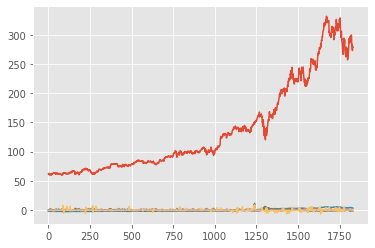

In [ ]:
plt.plot(finalDf)

###Split into Training and Test Set and scaling

In [ ]:
from sklearn.model_selection import train_test_split
sc = MinMaxScaler()

train, test = train_test_split(finalDf, test_size=0.3, shuffle = False)

In [ ]:
train = sc.fit_transform(train)

X_train = []
y_train = []
for i in range(DAYS, len(train)):
    X_train.append(train[i-DAYS:i]) # Chunks of training data with a length of 128 df-rows
    y_train.append(train[:, 0][i])
X_train, y_train = np.array(X_train), np.array(y_train)

print('Training set shape', X_train.shape, y_train.shape)

test = sc.fit_transform(test)

X_test, y_test = [], []
for i in range(DAYS, len(test)):
    X_test.append(test[i-DAYS:i])
    y_test.append(test[:, 0][i])    
X_test, y_test = np.array(X_test), np.array(y_test) 

print('Test set shape', X_test.shape, y_test.shape)

Training set shape (1251, 30, 5) (1251,)
Test set shape (519, 30, 5) (519,)


###Definitions to train, evaluate, and plot

In [ ]:
#Build and train the model
def fit_model(train,val,timesteps,hl,lr,batch,epochs):
    X_train = []
    Y_train = []
    X_val = []
    Y_val = []
  
    for i in range(timesteps,train.shape[0]):
        X_train.append(train[i-timesteps:i])
        Y_train.append(train[i][0])
    X_train,Y_train = np.array(X_train),np.array(Y_train)
  
    for i in range(timesteps,val.shape[0]):
        X_val.append(val[i-timesteps:i])
        Y_val.append(val[i][0])
    X_val,Y_val = np.array(X_val),np.array(Y_val)
    
    # Adding Layers to the model
    model = Sequential()
    model.add(LSTM(X_train.shape[2],input_shape = (X_train.shape[1],X_train.shape[2]),return_sequences = True,
                   activation = 'relu'))
    for i in range(len(hl)-1):        
        model.add(LSTM(hl[i],activation = 'relu',return_sequences = True))
    model.add(LSTM(hl[-1],activation = 'relu'))
    model.add(Dense(1))
    model.compile(optimizer = 'adam', loss = 'mean_squared_error')
  
    # Training the data
    history = model.fit(X_train,Y_train,epochs = epochs,batch_size = batch,validation_data = (X_val, Y_val),verbose = 0,
                        shuffle = False, callbacks=[checkpointer])
    model.reset_states()
    return model, history.history['loss'], history.history['val_loss']

In [ ]:
# Evaluating the model
def evaluate_model(model,test,timesteps):
    X_test = []
    Y_test = []

    for i in range(timesteps,test.shape[0]):
        X_test.append(test[i-timesteps:i])
        Y_test.append(test[i][0])
    X_test,Y_test = np.array(X_test),np.array(Y_test)
  
    Y_hat = model.predict(X_test)
    mse = mean_squared_error(Y_test,Y_hat)
    rmse = sqrt(mse)
    r = r2_score(Y_test,Y_hat)
    return mse, rmse, r, Y_test, Y_hat

In [ ]:
# Plotting the predictions
def plot_data(Y_test,Y_hat):
    plt.plot(Y_test,c = 'g')
    plt.plot(Y_hat,c = 'c')
    plt.xlabel('Day')
    plt.ylabel('Price')
    plt.title(ticker + ' Stock Prediction Graph LSTM model')
    plt.legend(['Actual','Predicted'],loc = 'lower right')
    plt.show()

In [ ]:
# Plotting the training errors
def plot_error(train_loss,val_loss):
    plt.plot(train_loss,c = 'r')
    plt.plot(val_loss,c = 'b')
    plt.ylabel('Loss')
    plt.legend(['train','val'],loc = 'upper right')
    plt.show()

###Set up callback

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint('/content/drive/MyDrive/Final Project Files/LSTM_Weights_'+ticker+'.hdf5', save_weights_only=True, save_best_only=True, verbose=1)

###Set hyper parameters and train model

In [ ]:
timesteps = DAYS
#hl = [40,35]
#lr = 1e-4
#batch_size = 32
#num_epochs = 30

model,train_error,test_error = fit_model(train,test,timesteps,hl,lr,batch_size,num_epochs)


Epoch 1: val_loss improved from inf to 0.63615, saving model to /content/drive/MyDrive/Final Project Files/LSTM_Weights_DHR.hdf5

Epoch 2: val_loss improved from 0.63615 to 0.19139, saving model to /content/drive/MyDrive/Final Project Files/LSTM_Weights_DHR.hdf5

Epoch 3: val_loss improved from 0.19139 to 0.11249, saving model to /content/drive/MyDrive/Final Project Files/LSTM_Weights_DHR.hdf5

Epoch 4: val_loss improved from 0.11249 to 0.08146, saving model to /content/drive/MyDrive/Final Project Files/LSTM_Weights_DHR.hdf5

Epoch 5: val_loss improved from 0.08146 to 0.07202, saving model to /content/drive/MyDrive/Final Project Files/LSTM_Weights_DHR.hdf5

Epoch 6: val_loss improved from 0.07202 to 0.02629, saving model to /content/drive/MyDrive/Final Project Files/LSTM_Weights_DHR.hdf5

Epoch 7: val_loss did not improve from 0.02629

Epoch 8: val_loss did not improve from 0.02629

Epoch 9: val_loss improved from 0.02629 to 0.01601, saving model to /content/drive/MyDrive/Final Projec

##Results

###Plot of Loss through each Epoch

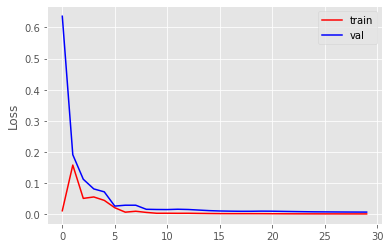

In [ ]:
plot_error(train_error,test_error)

###Prediction on Training set

MSE = 0.0009794360165303142
RMSE = 0.0312959424930823
R-Squared Score = 0.9840277676402288


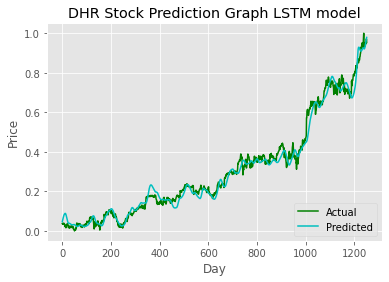

In [ ]:

mse, rmse, r2_value,true,predicted = evaluate_model(model,train,timesteps)
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))
plot_data(true,predicted)

###Prediction on Test Set

MSE = 0.006992263222478919
RMSE = 0.08361975378150141
R-Squared Score = 0.8764780664491734


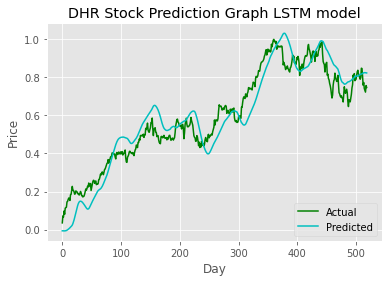

In [ ]:
mse, rmse, r2_value,true,predicted = evaluate_model(model,test,timesteps)
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))
plot_data(true,predicted)

#Chevron

##Data Load, Preprocessing, and Modeling

###Information Load and Dataframe setup

In [ ]:
ticker = 'CVX'

In [ ]:
!rm -rf '/content/drive/MyDrive/Final Project Files/LSTM_Weights_'+ticker.hdf5

In [ ]:
start_date = '2014-12-08'
end_date = '2022-04-22'

yahoo_financials = YahooFinancials(ticker)
data = yahoo_financials.get_historical_price_data(start_date=start_date, 
                                                  end_date=end_date, 
                                                  time_interval='daily')
df = pd.DataFrame(data[ticker]['prices'])
df = df.drop('date', axis=1).set_index('formatted_date')
#df = df.reset_index()
#df = df.rename(columns={"formatted_date": "Date"})
df = df.dropna()

# Define periods
k_period = 14
d_period = 3
# Adds a "n_high" column with max value of previous 14 periods
df['n_high'] = df['high'].rolling(k_period).max()
# Adds an "n_low" column with min value of previous 14 periods
df['n_low'] = df['low'].rolling(k_period).min()
# Uses the min/max values to calculate the %k (as a percentage)
df['%K'] = (df['adjclose'] - df['n_low']) * 100 / (df['n_high'] - df['n_low'])
# Uses the %k to calculates a SMA over the past 3 values of %k
df['%D'] = df['%K'].rolling(d_period).mean()


# Add some indicators
df.ta.stoch(high='high', low='low', k=14, d=3, append=True)

df = df.dropna()
df = df.drop(['n_high', 'n_low', '%K', '%D'], axis=1)
df = df.rename(columns={"STOCHk_14_3_3": "Fast Osc. Signal", "STOCHd_14_3_3": "Slow Osc. Signal"})

df['Volume_lag'] = df['volume'].shift(1)
df['High_lag'] = df['high'].shift(1)
df['Low_lag'] = df['low'].shift(1)
df['Open_lag'] = df['open'].shift(1)
df['Adj_Close_lag'] = df['adjclose'].shift(1)
df['Fast Osc. Lag'] = df['Fast Osc. Signal'].shift(1)
df['Slow Osc. Lag'] = df['Slow Osc. Signal'].shift(1)
df = df.drop(['volume'], axis=1)
df = df.drop(['close'], axis=1)
df = df.drop(['low'], axis=1)
df = df.drop(['high'], axis=1)
df = df.drop(['open'], axis=1)
df = df.drop(['Fast Osc. Signal'], axis=1)
df = df.drop(['Slow Osc. Signal'], axis=1)
print(df)

                  adjclose  Volume_lag    High_lag     Low_lag    Open_lag  \
formatted_date                                                               
2015-01-02       81.651512         NaN         NaN         NaN         NaN   
2015-01-05       78.387772   5898800.0  113.000000  110.849998  111.629997   
2015-01-06       78.351509  11758100.0  111.199997  107.440002  110.959999   
2015-01-07       78.286240  11591600.0  109.019997  106.480003  107.870003   
2015-01-08       80.077660  10353800.0  109.730003  107.510002  109.250000   
...                    ...         ...         ...         ...         ...   
2022-04-14      171.589996   7330700.0  172.080002  168.289993  170.929993   
2022-04-18      173.889999   9416800.0  172.940002  170.559998  170.690002   
2022-04-19      171.830002   7639000.0  174.539993  171.869995  173.000000   
2022-04-20      172.529999   6970200.0  173.690002  171.029999  173.080002   
2022-04-21      164.580002   7495000.0  173.580002  171.460007  

In [ ]:
# Get 30 year Bond Yield
yahoo_financials = YahooFinancials('^TYX')
data = yahoo_financials.get_historical_price_data(start_date=start_date, 
                                                  end_date=end_date, 
                                                  time_interval='daily')
yield_30yr = pd.DataFrame(data['^TYX']['prices'])
yield_30yr = yield_30yr.drop('date', axis=1).set_index('formatted_date')
#yield_30yr = yield_30yr.reset_index()
#yield_df = yield_30yr.rename(columns={"formatted_date": "Date"})
yield_df = yield_30yr.filter(['close'], axis=1)
yield_df = yield_df.dropna()
yield_df = yield_df.rename(columns={"close": "Bond_Yield"})
yield_df['Bond_Yield_Lag'] = yield_df['Bond_Yield'].shift(1)
yield_df = yield_df.drop(['Bond_Yield'], axis=1)
print(yield_df)

# Get Market Sentiment index
yahoo_financials = YahooFinancials('^VIX')
data = yahoo_financials.get_historical_price_data(start_date=start_date, 
                                                  end_date=end_date, 
                                                  time_interval='daily')
vix_df = pd.DataFrame(data['^VIX']['prices'])
vix_df = vix_df.drop('date', axis=1).set_index('formatted_date')
#vix_df = vix_df.reset_index()
#vix_df = vix_df.rename(columns={"formatted_date": "Date"})
vix_df = vix_df.filter(['close'], axis=1)
vix_df = vix_df.dropna()
vix_df = vix_df.rename(columns={"close": "VIX"})
vix_df['VIX_Lag'] = vix_df['VIX'].shift(1)
vix_df = vix_df.drop(['VIX'], axis = 1)
print(vix_df)


# Get Wilshire 5000 index
yahoo_financials = YahooFinancials('^W5000')
data = yahoo_financials.get_historical_price_data(start_date=start_date, 
                                                 end_date=end_date, 
                                                  time_interval='daily')
w5000 = pd.DataFrame(data['^W5000']['prices'])
w5000 = w5000.drop('date', axis=1).set_index('formatted_date')
#w5000 = w5000.reset_index()
#w5000 = w5000.rename(columns={"formatted_date": "Date"})
w5000 = w5000.filter(['close'], axis=1)
w5000 = w5000.dropna()
w5000 = w5000.rename(columns={"close": "Wilshire"})
w5000['Wilshire_Lag'] = w5000['Wilshire'].shift(1)
w5000 = w5000.drop(['Wilshire'], axis = 1)
print(w5000)

                Bond_Yield_Lag
formatted_date                
2014-12-08                 NaN
2014-12-09               2.901
2014-12-10               2.875
2014-12-11               2.835
2014-12-12               2.825
...                        ...
2022-04-14               2.794
2022-04-18               2.919
2022-04-19               2.953
2022-04-20               2.990
2022-04-21               2.879

[1854 rows x 1 columns]
                  VIX_Lag
formatted_date           
2014-12-08            NaN
2014-12-09      14.210000
2014-12-10      15.350000
2014-12-11      18.530001
2014-12-12      20.080000
...                   ...
2022-04-14      21.820000
2022-04-18      22.700001
2022-04-19      22.170000
2022-04-20      21.370001
2022-04-21      20.320000

[1856 rows x 1 columns]
                Wilshire_Lag
formatted_date              
2014-12-08               NaN
2014-12-09      21581.910156
2014-12-10      21536.179688
2014-12-11      21244.730469
2014-12-12      21338.890625
...   

In [ ]:
economic_df = yield_df.join(vix_df, on ='formatted_date')
economic_df = economic_df.join(w5000, on="formatted_date")
print(economic_df)

                Bond_Yield_Lag    VIX_Lag  Wilshire_Lag
formatted_date                                         
2014-12-08                 NaN        NaN           NaN
2014-12-09               2.901  14.210000  21581.910156
2014-12-10               2.875  15.350000  21536.179688
2014-12-11               2.835  18.530001  21244.730469
2014-12-12               2.825  20.080000  21338.890625
...                        ...        ...           ...
2022-04-14               2.794  21.820000  44732.468750
2022-04-18               2.919  22.700001  44180.851562
2022-04-19               2.953  22.170000  44086.601562
2022-04-20               2.990  21.370001  44967.039062
2022-04-21               2.879  20.320000  44774.980469

[1854 rows x 3 columns]


In [ ]:
df = df.join(economic_df,how='left', on = "formatted_date")

In [ ]:
sentiment_df = pd.read_csv('/content/drive/MyDrive/Final Project Files/'+ticker+'_Output.csv')
sentiment_df['formatted_date'] = sentiment_df['Date']
sentiment_df = sentiment_df.drop('Date', axis=1)
sentiment_df = sentiment_df.set_index('formatted_date')

In [ ]:
df = df.join(sentiment_df,how='left', on = "formatted_date")
df['Score_lag'] = df['Score_lag'].fillna(0)
df = df.iloc[1: , :]
print(df)

                  adjclose  Volume_lag    High_lag     Low_lag    Open_lag  \
formatted_date                                                               
2015-01-05       78.387772   5898800.0  113.000000  110.849998  111.629997   
2015-01-06       78.351509  11758100.0  111.199997  107.440002  110.959999   
2015-01-07       78.286240  11591600.0  109.019997  106.480003  107.870003   
2015-01-08       80.077660  10353800.0  109.730003  107.510002  109.250000   
2015-01-09       78.482048   8650800.0  110.440002  108.599998  109.190002   
...                    ...         ...         ...         ...         ...   
2022-04-14      171.589996   7330700.0  172.080002  168.289993  170.929993   
2022-04-18      173.889999   9416800.0  172.940002  170.559998  170.690002   
2022-04-19      171.830002   7639000.0  174.539993  171.869995  173.000000   
2022-04-20      172.529999   6970200.0  173.690002  171.029999  173.080002   
2022-04-21      164.580002   7495000.0  173.580002  171.460007  

In [ ]:
df

,adjclose,Volume_lag,High_lag,Low_lag,Open_lag,Adj_Close_lag,Fast Osc. Lag,Slow Osc. Lag,Bond_Yield_Lag,VIX_Lag,Wilshire_Lag,Score_lag
formatted_date,,,,,,,,,,,,
2015-01-05,78.387772,5898800.0,113.000000,110.849998,111.629997,81.651512,87.226131,89.207480,2.697,17.790001,21665.320312,0.6124
2015-01-06,78.351509,11758100.0,111.199997,107.440002,110.959999,78.387772,75.501188,83.892796,2.605,19.920000,21269.060547,0.2431
2015-01-07,78.286240,11591600.0,109.019997,106.480003,107.870003,78.351509,65.827522,76.184947,2.523,21.120001,21060.250000,0.0000
2015-01-08,80.077660,10353800.0,109.730003,107.510002,109.250000,78.286240,52.742764,64.690491,2.515,19.309999,21301.669922,0.2732
2015-01-09,78.482048,8650800.0,110.440002,108.599998,109.190002,80.077660,52.561504,57.043930,2.593,17.010000,21672.390625,-0.4588
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-14,171.589996,7330700.0,172.080002,168.289993,170.929993,171.669998,69.770730,69.377105,2.794,21.820000,44732.468750,0.0000
2022-04-18,173.889999,9416800.0,172.940002,170.559998,170.690002,171.589996,83.574752,74.067002,2.919,22.700001,44180.851562,0.0000
2022-04-19,171.830002,7639000.0,174.539993,171.869995,173.000000,173.889999,92.075344,81.806942,2.953,22.170000,44086.601562,0.2023


In [ ]:
df = df.dropna()
df.corr()['adjclose']

adjclose          1.000000
Volume_lag        0.015568
High_lag          0.893367
Low_lag           0.882962
Open_lag          0.885830
Adj_Close_lag     0.996109
Fast Osc. Lag     0.264293
Slow Osc. Lag     0.270368
Bond_Yield_Lag    0.048899
VIX_Lag          -0.136320
Wilshire_Lag      0.618617
Score_lag        -0.058438
Name: adjclose, dtype: float64

In [ ]:
df_pca = df

In [ ]:
df_pca

,adjclose,Volume_lag,High_lag,Low_lag,Open_lag,Adj_Close_lag,Fast Osc. Lag,Slow Osc. Lag,Bond_Yield_Lag,VIX_Lag,Wilshire_Lag,Score_lag
formatted_date,,,,,,,,,,,,
2015-01-05,78.387772,5898800.0,113.000000,110.849998,111.629997,81.651512,87.226131,89.207480,2.697,17.790001,21665.320312,0.6124
2015-01-06,78.351509,11758100.0,111.199997,107.440002,110.959999,78.387772,75.501188,83.892796,2.605,19.920000,21269.060547,0.2431
2015-01-07,78.286240,11591600.0,109.019997,106.480003,107.870003,78.351509,65.827522,76.184947,2.523,21.120001,21060.250000,0.0000
2015-01-08,80.077660,10353800.0,109.730003,107.510002,109.250000,78.286240,52.742764,64.690491,2.515,19.309999,21301.669922,0.2732
2015-01-09,78.482048,8650800.0,110.440002,108.599998,109.190002,80.077660,52.561504,57.043930,2.593,17.010000,21672.390625,-0.4588
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-14,171.589996,7330700.0,172.080002,168.289993,170.929993,171.669998,69.770730,69.377105,2.794,21.820000,44732.468750,0.0000
2022-04-18,173.889999,9416800.0,172.940002,170.559998,170.690002,171.589996,83.574752,74.067002,2.919,22.700001,44180.851562,0.0000
2022-04-19,171.830002,7639000.0,174.539993,171.869995,173.000000,173.889999,92.075344,81.806942,2.953,22.170000,44086.601562,0.2023


###Running PCA to reduce variables

In [ ]:
from sklearn.preprocessing import StandardScaler
features = ['Volume_lag', 'High_lag', 'Low_lag', 'Open_lag', 'Adj_Close_lag',
            'Fast Osc. Lag', 'Slow Osc. Lag', 'Bond_Yield_Lag', 'VIX_Lag',
            'Wilshire_Lag', 'Score_lag']
# Separating out the features
x = df_pca.loc[:, features].values
# Separating out the target
y = df_pca.loc[:,['adjclose']].values
# Standardizing the features
x = StandardScaler().fit_transform(x)
x

array([[-0.58363679,  0.27717527,  0.27123366, ..., -0.03987629,
        -1.02386581,  1.43781312],
       [ 0.69587785,  0.16734698,  0.06461635, ...,  0.2318808 ,
        -1.07289718,  0.4827782 ],
       [ 0.6595187 ,  0.03433292,  0.00644841, ...,  0.38498355,
        -1.09873444, -0.14589494],
       ...,
       [-0.20362359,  4.03207587,  3.96853645, ...,  0.51894827,
         1.75044113,  0.37726663],
       [-0.34967165,  3.98021316,  3.91763968, ...,  0.41687994,
         1.85938244, -1.42315393],
       [-0.23506934,  3.9735014 ,  3.94369457, ...,  0.28291497,
         1.83561799, -0.14589494]])

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=4)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['PC 1', 'PC 2', 'PC 3', 'PC 4'])
principalDf

,PC 1,PC 2,PC 3,PC 4
0,-0.636130,-0.599411,2.085144,1.137877
1,-0.023741,0.005568,1.501468,0.304443
2,0.332494,0.020833,1.058034,-0.276995
3,0.337029,-0.433878,0.606818,0.462270
4,0.144375,-0.657133,0.228694,-1.418773
...,...,...,...,...
1825,-7.555378,1.974490,-2.175588,0.294970
1826,-7.715293,2.221994,-1.806117,0.266739
1827,-8.098736,2.117057,-1.385058,0.731085
1828,-8.099527,2.159145,-1.532416,-1.066603


###Merging PCA to Adjust Close Price

In [ ]:
df_adjclose = df.reset_index()
df_adjclose = df_adjclose.rename(columns={"formatted_date": "Date"})
df_adjclose = df_adjclose[['adjclose']]
df_adjclose

,adjclose
0,78.387772
1,78.351509
2,78.286240
3,80.077660
4,78.482048
...,...
1825,171.589996
1826,173.889999
1827,171.830002
1828,172.529999


In [ ]:
finalDf = pd.merge(df_adjclose, principalDf, left_index=True, right_index=True)
finalDf

,adjclose,PC 1,PC 2,PC 3,PC 4
0,78.387772,-0.636130,-0.599411,2.085144,1.137877
1,78.351509,-0.023741,0.005568,1.501468,0.304443
2,78.286240,0.332494,0.020833,1.058034,-0.276995
3,80.077660,0.337029,-0.433878,0.606818,0.462270
4,78.482048,0.144375,-0.657133,0.228694,-1.418773
...,...,...,...,...,...
1825,171.589996,-7.555378,1.974490,-2.175588,0.294970
1826,173.889999,-7.715293,2.221994,-1.806117,0.266739
1827,171.830002,-8.098736,2.117057,-1.385058,0.731085
1828,172.529999,-8.099527,2.159145,-1.532416,-1.066603


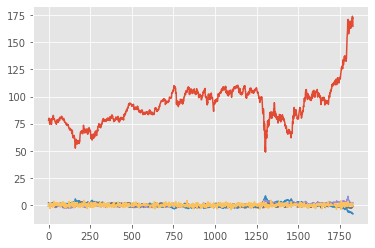

In [ ]:
plt.plot(finalDf)

###Split into Training and Test Set and scaling

In [ ]:
from sklearn.model_selection import train_test_split
sc = MinMaxScaler()

train, test = train_test_split(finalDf, test_size=0.3, shuffle = False)

In [ ]:
train = sc.fit_transform(train)

X_train = []
y_train = []
for i in range(DAYS, len(train)):
    X_train.append(train[i-DAYS:i]) # Chunks of training data with a length of 128 df-rows
    y_train.append(train[:, 0][i])
X_train, y_train = np.array(X_train), np.array(y_train)

print('Training set shape', X_train.shape, y_train.shape)

test = sc.fit_transform(test)

X_test, y_test = [], []
for i in range(DAYS, len(test)):
    X_test.append(test[i-DAYS:i])
    y_test.append(test[:, 0][i])    
X_test, y_test = np.array(X_test), np.array(y_test) 

print('Test set shape', X_test.shape, y_test.shape)

Training set shape (1251, 30, 5) (1251,)
Test set shape (519, 30, 5) (519,)


###Definitions to train, evaluate, and plot

In [ ]:
#Build and train the model
def fit_model(train,val,timesteps,hl,lr,batch,epochs):
    X_train = []
    Y_train = []
    X_val = []
    Y_val = []
  
    for i in range(timesteps,train.shape[0]):
        X_train.append(train[i-timesteps:i])
        Y_train.append(train[i][0])
    X_train,Y_train = np.array(X_train),np.array(Y_train)
  
    for i in range(timesteps,val.shape[0]):
        X_val.append(val[i-timesteps:i])
        Y_val.append(val[i][0])
    X_val,Y_val = np.array(X_val),np.array(Y_val)
    
    # Adding Layers to the model
    model = Sequential()
    model.add(LSTM(X_train.shape[2],input_shape = (X_train.shape[1],X_train.shape[2]),return_sequences = True,
                   activation = 'relu'))
    for i in range(len(hl)-1):        
        model.add(LSTM(hl[i],activation = 'relu',return_sequences = True))
    model.add(LSTM(hl[-1],activation = 'relu'))
    model.add(Dense(1))
    model.compile(optimizer = 'adam', loss = 'mean_squared_error')
  
    # Training the data
    history = model.fit(X_train,Y_train,epochs = epochs,batch_size = batch,validation_data = (X_val, Y_val),verbose = 0,
                        shuffle = False, callbacks=[checkpointer])
    model.reset_states()
    return model, history.history['loss'], history.history['val_loss']

In [ ]:
# Evaluating the model
def evaluate_model(model,test,timesteps):
    X_test = []
    Y_test = []

    for i in range(timesteps,test.shape[0]):
        X_test.append(test[i-timesteps:i])
        Y_test.append(test[i][0])
    X_test,Y_test = np.array(X_test),np.array(Y_test)
  
    Y_hat = model.predict(X_test)
    mse = mean_squared_error(Y_test,Y_hat)
    rmse = sqrt(mse)
    r = r2_score(Y_test,Y_hat)
    return mse, rmse, r, Y_test, Y_hat

In [ ]:
# Plotting the predictions
def plot_data(Y_test,Y_hat):
    plt.plot(Y_test,c = 'g')
    plt.plot(Y_hat,c = 'c')
    plt.xlabel('Day')
    plt.ylabel('Price')
    plt.title(ticker + ' Stock Prediction Graph LSTM model')
    plt.legend(['Actual','Predicted'],loc = 'lower right')
    plt.show()

In [ ]:
# Plotting the training errors
def plot_error(train_loss,val_loss):
    plt.plot(train_loss,c = 'r')
    plt.plot(val_loss,c = 'b')
    plt.ylabel('Loss')
    plt.legend(['train','val'],loc = 'upper right')
    plt.show()

###Set up callback

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint('/content/drive/MyDrive/Final Project Files/LSTM_Weights_'+ticker+'.hdf5', save_weights_only=True, save_best_only=True, verbose=1)

###Set hyper parameters and train model

In [ ]:
timesteps = DAYS
#hl = [40,35]
#lr = 1e-4
#batch_size = 32
#num_epochs = 30

model,train_error,test_error = fit_model(train,test,timesteps,hl,lr,batch_size,num_epochs)


Epoch 1: val_loss improved from inf to 0.04026, saving model to /content/drive/MyDrive/Final Project Files/LSTM_Weights_CVX.hdf5

Epoch 2: val_loss did not improve from 0.04026

Epoch 3: val_loss did not improve from 0.04026

Epoch 4: val_loss improved from 0.04026 to 0.03764, saving model to /content/drive/MyDrive/Final Project Files/LSTM_Weights_CVX.hdf5

Epoch 5: val_loss improved from 0.03764 to 0.02872, saving model to /content/drive/MyDrive/Final Project Files/LSTM_Weights_CVX.hdf5

Epoch 6: val_loss improved from 0.02872 to 0.01767, saving model to /content/drive/MyDrive/Final Project Files/LSTM_Weights_CVX.hdf5

Epoch 7: val_loss improved from 0.01767 to 0.00896, saving model to /content/drive/MyDrive/Final Project Files/LSTM_Weights_CVX.hdf5

Epoch 8: val_loss did not improve from 0.00896

Epoch 9: val_loss improved from 0.00896 to 0.00438, saving model to /content/drive/MyDrive/Final Project Files/LSTM_Weights_CVX.hdf5

Epoch 10: val_loss did not improve from 0.00438

Epoch 

##Results

###Plot of Loss through each Epoch

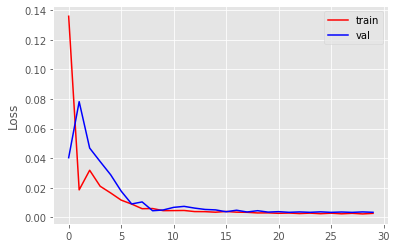

In [ ]:
plot_error(train_error,test_error)

###Prediction on Training set

MSE = 0.003037846661858205
RMSE = 0.05511666410313858
R-Squared Score = 0.9492265415769594


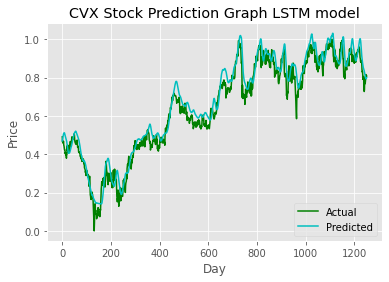

In [ ]:

mse, rmse, r2_value,true,predicted = evaluate_model(model,train,timesteps)
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))
plot_data(true,predicted)

###Prediction on Test Set

MSE = 0.003320126584306889
RMSE = 0.05762053960444044
R-Squared Score = 0.9145314031403584


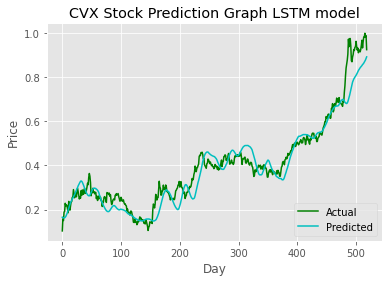

In [ ]:
mse, rmse, r2_value,true,predicted = evaluate_model(model,test,timesteps)
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))
plot_data(true,predicted)

#Devon Energy

##Data Load, Preprocessing, and Modeling

###Information Load and Dataframe setup

In [ ]:
ticker = 'DVN'

In [ ]:
!rm -rf '/content/drive/MyDrive/Final Project Files/LSTM_Weights_'+ticker.hdf5

In [ ]:
start_date = '2014-12-08'
end_date = '2022-04-22'

yahoo_financials = YahooFinancials(ticker)
data = yahoo_financials.get_historical_price_data(start_date=start_date, 
                                                  end_date=end_date, 
                                                  time_interval='daily')
df = pd.DataFrame(data[ticker]['prices'])
df = df.drop('date', axis=1).set_index('formatted_date')
#df = df.reset_index()
#df = df.rename(columns={"formatted_date": "Date"})
df = df.dropna()

# Define periods
k_period = 14
d_period = 3
# Adds a "n_high" column with max value of previous 14 periods
df['n_high'] = df['high'].rolling(k_period).max()
# Adds an "n_low" column with min value of previous 14 periods
df['n_low'] = df['low'].rolling(k_period).min()
# Uses the min/max values to calculate the %k (as a percentage)
df['%K'] = (df['adjclose'] - df['n_low']) * 100 / (df['n_high'] - df['n_low'])
# Uses the %k to calculates a SMA over the past 3 values of %k
df['%D'] = df['%K'].rolling(d_period).mean()


# Add some indicators
df.ta.stoch(high='high', low='low', k=14, d=3, append=True)

df = df.dropna()
df = df.drop(['n_high', 'n_low', '%K', '%D'], axis=1)
df = df.rename(columns={"STOCHk_14_3_3": "Fast Osc. Signal", "STOCHd_14_3_3": "Slow Osc. Signal"})

df['Volume_lag'] = df['volume'].shift(1)
df['High_lag'] = df['high'].shift(1)
df['Low_lag'] = df['low'].shift(1)
df['Open_lag'] = df['open'].shift(1)
df['Adj_Close_lag'] = df['adjclose'].shift(1)
df['Fast Osc. Lag'] = df['Fast Osc. Signal'].shift(1)
df['Slow Osc. Lag'] = df['Slow Osc. Signal'].shift(1)
df = df.drop(['volume'], axis=1)
df = df.drop(['close'], axis=1)
df = df.drop(['low'], axis=1)
df = df.drop(['high'], axis=1)
df = df.drop(['open'], axis=1)
df = df.drop(['Fast Osc. Signal'], axis=1)
df = df.drop(['Slow Osc. Signal'], axis=1)
print(df)

                 adjclose  Volume_lag   High_lag    Low_lag   Open_lag  \
formatted_date                                                           
2015-01-02      49.811836         NaN        NaN        NaN        NaN   
2015-01-05      47.965115   3017000.0  61.630001  59.599998  60.630001   
2015-01-06      46.984577   3864500.0  59.689999  57.799999  59.689999   
2015-01-07      47.205189   4685000.0  59.189999  56.770000  58.599998   
2015-01-08      48.880299   4208700.0  58.939999  57.380001  58.090000   
...                   ...         ...        ...        ...        ...   
2022-04-14      62.560001   9955700.0  64.290001  62.279999  63.500000   
2022-04-18      63.540001   8609900.0  64.050003  62.529999  63.259998   
2022-04-19      63.000000   9422300.0  64.239998  62.650002  63.240002   
2022-04-20      64.610001   8156000.0  64.430000  62.599998  63.240002   
2022-04-21      61.150002   7121200.0  64.980003  63.529999  63.730000   

                Adj_Close_lag  Fast O

In [ ]:
# Get 30 year Bond Yield
yahoo_financials = YahooFinancials('^TYX')
data = yahoo_financials.get_historical_price_data(start_date=start_date, 
                                                  end_date=end_date, 
                                                  time_interval='daily')
yield_30yr = pd.DataFrame(data['^TYX']['prices'])
yield_30yr = yield_30yr.drop('date', axis=1).set_index('formatted_date')
#yield_30yr = yield_30yr.reset_index()
#yield_df = yield_30yr.rename(columns={"formatted_date": "Date"})
yield_df = yield_30yr.filter(['close'], axis=1)
yield_df = yield_df.dropna()
yield_df = yield_df.rename(columns={"close": "Bond_Yield"})
yield_df['Bond_Yield_Lag'] = yield_df['Bond_Yield'].shift(1)
yield_df = yield_df.drop(['Bond_Yield'], axis=1)
print(yield_df)

# Get Market Sentiment index
yahoo_financials = YahooFinancials('^VIX')
data = yahoo_financials.get_historical_price_data(start_date=start_date, 
                                                  end_date=end_date, 
                                                  time_interval='daily')
vix_df = pd.DataFrame(data['^VIX']['prices'])
vix_df = vix_df.drop('date', axis=1).set_index('formatted_date')
#vix_df = vix_df.reset_index()
#vix_df = vix_df.rename(columns={"formatted_date": "Date"})
vix_df = vix_df.filter(['close'], axis=1)
vix_df = vix_df.dropna()
vix_df = vix_df.rename(columns={"close": "VIX"})
vix_df['VIX_Lag'] = vix_df['VIX'].shift(1)
vix_df = vix_df.drop(['VIX'], axis = 1)
print(vix_df)


# Get Wilshire 5000 index
yahoo_financials = YahooFinancials('^W5000')
data = yahoo_financials.get_historical_price_data(start_date=start_date, 
                                                 end_date=end_date, 
                                                  time_interval='daily')
w5000 = pd.DataFrame(data['^W5000']['prices'])
w5000 = w5000.drop('date', axis=1).set_index('formatted_date')
#w5000 = w5000.reset_index()
#w5000 = w5000.rename(columns={"formatted_date": "Date"})
w5000 = w5000.filter(['close'], axis=1)
w5000 = w5000.dropna()
w5000 = w5000.rename(columns={"close": "Wilshire"})
w5000['Wilshire_Lag'] = w5000['Wilshire'].shift(1)
w5000 = w5000.drop(['Wilshire'], axis = 1)
print(w5000)

                Bond_Yield_Lag
formatted_date                
2014-12-08                 NaN
2014-12-09               2.901
2014-12-10               2.875
2014-12-11               2.835
2014-12-12               2.825
...                        ...
2022-04-14               2.794
2022-04-18               2.919
2022-04-19               2.953
2022-04-20               2.990
2022-04-21               2.879

[1854 rows x 1 columns]
                  VIX_Lag
formatted_date           
2014-12-08            NaN
2014-12-09      14.210000
2014-12-10      15.350000
2014-12-11      18.530001
2014-12-12      20.080000
...                   ...
2022-04-14      21.820000
2022-04-18      22.700001
2022-04-19      22.170000
2022-04-20      21.370001
2022-04-21      20.320000

[1856 rows x 1 columns]
                Wilshire_Lag
formatted_date              
2014-12-08               NaN
2014-12-09      21581.910156
2014-12-10      21536.179688
2014-12-11      21244.730469
2014-12-12      21338.890625
...   

In [ ]:
economic_df = yield_df.join(vix_df, on ='formatted_date')
economic_df = economic_df.join(w5000, on="formatted_date")
print(economic_df)

                Bond_Yield_Lag    VIX_Lag  Wilshire_Lag
formatted_date                                         
2014-12-08                 NaN        NaN           NaN
2014-12-09               2.901  14.210000  21581.910156
2014-12-10               2.875  15.350000  21536.179688
2014-12-11               2.835  18.530001  21244.730469
2014-12-12               2.825  20.080000  21338.890625
...                        ...        ...           ...
2022-04-14               2.794  21.820000  44732.468750
2022-04-18               2.919  22.700001  44180.851562
2022-04-19               2.953  22.170000  44086.601562
2022-04-20               2.990  21.370001  44967.039062
2022-04-21               2.879  20.320000  44774.980469

[1854 rows x 3 columns]


In [ ]:
df = df.join(economic_df,how='left', on = "formatted_date")

In [ ]:
sentiment_df = pd.read_csv('/content/drive/MyDrive/Final Project Files/'+ticker+'_Output.csv')
sentiment_df['formatted_date'] = sentiment_df['Date']
sentiment_df = sentiment_df.drop('Date', axis=1)
sentiment_df = sentiment_df.set_index('formatted_date')

In [ ]:
df = df.join(sentiment_df,how='left', on = "formatted_date")
df['Score_lag'] = df['Score_lag'].fillna(0)
df = df.iloc[1: , :]
print(df)

                 adjclose  Volume_lag   High_lag    Low_lag   Open_lag  \
formatted_date                                                           
2015-01-05      47.965115   3017000.0  61.630001  59.599998  60.630001   
2015-01-06      46.984577   3864500.0  59.689999  57.799999  59.689999   
2015-01-07      47.205189   4685000.0  59.189999  56.770000  58.599998   
2015-01-08      48.880299   4208700.0  58.939999  57.380001  58.090000   
2015-01-09      49.362411   4551800.0  60.450001  58.009998  58.750000   
...                   ...         ...        ...        ...        ...   
2022-04-14      62.560001   9955700.0  64.290001  62.279999  63.500000   
2022-04-18      63.540001   8609900.0  64.050003  62.529999  63.259998   
2022-04-19      63.000000   9422300.0  64.239998  62.650002  63.240002   
2022-04-20      64.610001   8156000.0  64.430000  62.599998  63.240002   
2022-04-21      61.150002   7121200.0  64.980003  63.529999  63.730000   

                Adj_Close_lag  Fast O

In [ ]:
df

,adjclose,Volume_lag,High_lag,Low_lag,Open_lag,Adj_Close_lag,Fast Osc. Lag,Slow Osc. Lag,Bond_Yield_Lag,VIX_Lag,Wilshire_Lag,Score_lag
formatted_date,,,,,,,,,,,,
2015-01-05,47.965115,3017000.0,61.630001,59.599998,60.630001,49.811836,91.227374,91.824638,2.697,17.790001,21665.320312,0.0000
2015-01-06,46.984577,3864500.0,59.689999,57.799999,59.689999,47.965115,82.976646,88.883867,2.605,19.920000,21269.060547,0.0000
2015-01-07,47.205189,4685000.0,59.189999,56.770000,58.599998,46.984577,70.946820,81.716946,2.523,21.120001,21060.250000,-0.3818
2015-01-08,48.880299,4208700.0,58.939999,57.380001,58.090000,47.205189,55.646478,69.856648,2.515,19.309999,21301.669922,0.0000
2015-01-09,49.362411,4551800.0,60.450001,58.009998,58.750000,48.880299,52.434815,59.676038,2.593,17.010000,21672.390625,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-14,62.560001,9955700.0,64.290001,62.279999,63.500000,63.750000,72.545434,67.298396,2.794,21.820000,44732.468750,0.0000
2022-04-18,63.540001,8609900.0,64.050003,62.529999,63.259998,62.560001,82.568215,75.068048,2.919,22.700001,44180.851562,0.8442
2022-04-19,63.000000,9422300.0,64.239998,62.650002,63.240002,63.540001,85.368217,80.160622,2.953,22.170000,44086.601562,0.0000


In [ ]:
df = df.dropna()
df.corr()['adjclose']

adjclose          1.000000
Volume_lag       -0.255908
High_lag          0.982594
Low_lag           0.980476
Open_lag          0.980369
Adj_Close_lag     0.997430
Fast Osc. Lag     0.129998
Slow Osc. Lag     0.135799
Bond_Yield_Lag    0.503083
VIX_Lag          -0.407253
Wilshire_Lag     -0.087263
Score_lag         0.019979
Name: adjclose, dtype: float64

In [ ]:
df_pca = df

In [ ]:
df_pca

,adjclose,Volume_lag,High_lag,Low_lag,Open_lag,Adj_Close_lag,Fast Osc. Lag,Slow Osc. Lag,Bond_Yield_Lag,VIX_Lag,Wilshire_Lag,Score_lag
formatted_date,,,,,,,,,,,,
2015-01-05,47.965115,3017000.0,61.630001,59.599998,60.630001,49.811836,91.227374,91.824638,2.697,17.790001,21665.320312,0.0000
2015-01-06,46.984577,3864500.0,59.689999,57.799999,59.689999,47.965115,82.976646,88.883867,2.605,19.920000,21269.060547,0.0000
2015-01-07,47.205189,4685000.0,59.189999,56.770000,58.599998,46.984577,70.946820,81.716946,2.523,21.120001,21060.250000,-0.3818
2015-01-08,48.880299,4208700.0,58.939999,57.380001,58.090000,47.205189,55.646478,69.856648,2.515,19.309999,21301.669922,0.0000
2015-01-09,49.362411,4551800.0,60.450001,58.009998,58.750000,48.880299,52.434815,59.676038,2.593,17.010000,21672.390625,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-14,62.560001,9955700.0,64.290001,62.279999,63.500000,63.750000,72.545434,67.298396,2.794,21.820000,44732.468750,0.0000
2022-04-18,63.540001,8609900.0,64.050003,62.529999,63.259998,62.560001,82.568215,75.068048,2.919,22.700001,44180.851562,0.8442
2022-04-19,63.000000,9422300.0,64.239998,62.650002,63.240002,63.540001,85.368217,80.160622,2.953,22.170000,44086.601562,0.0000


###Running PCA to reduce variables

In [ ]:
from sklearn.preprocessing import StandardScaler
features = ['Volume_lag', 'High_lag', 'Low_lag', 'Open_lag', 'Adj_Close_lag',
            'Fast Osc. Lag', 'Slow Osc. Lag', 'Bond_Yield_Lag', 'VIX_Lag',
            'Wilshire_Lag', 'Score_lag']
# Separating out the features
x = df_pca.loc[:, features].values
# Separating out the target
y = df_pca.loc[:,['adjclose']].values
# Standardizing the features
x = StandardScaler().fit_transform(x)
x

array([[-0.94783973,  1.91885214,  1.89981676, ..., -0.03987629,
        -1.02386581, -0.07721186],
       [-0.78748599,  1.78075459,  1.76910626, ...,  0.2318808 ,
        -1.07289718, -0.07721186],
       [-0.63224088,  1.74516249,  1.69431086, ...,  0.38498355,
        -1.09873444, -1.78307132],
       ...,
       [ 0.26409393,  2.10464269,  2.12129877, ...,  0.51894827,
         1.75044113, -0.07721186],
       [ 0.02449991,  2.11816787,  2.1176677 , ...,  0.41687994,
         1.85938244, -0.07721186],
       [-0.17129248,  2.1573194 ,  2.18520151, ...,  0.28291497,
         1.83561799, -0.07721186]])

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=4)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['PC 1', 'PC 2', 'PC 3', 'PC 4'])
principalDf

,PC 1,PC 2,PC 3,PC 4
0,-3.799866,1.642523,-0.079259,0.230627
1,-3.419358,1.418250,0.129843,0.205926
2,-3.150202,0.907764,0.327497,1.832817
3,-3.198199,0.445767,0.545937,0.165950
4,-3.432256,0.173509,0.631756,0.135990
...,...,...,...,...
1825,-3.684886,2.002121,2.738061,0.523210
1826,-3.784492,2.546695,2.579760,-3.111717
1827,-3.828845,2.452435,2.355882,0.526206
1828,-3.894431,2.399609,2.233015,0.568570


###Merging PCA to Adjust Close Price

In [ ]:
df_adjclose = df.reset_index()
df_adjclose = df_adjclose.rename(columns={"formatted_date": "Date"})
df_adjclose = df_adjclose[['adjclose']]
df_adjclose

,adjclose
0,47.965115
1,46.984577
2,47.205189
3,48.880299
4,49.362411
...,...
1825,62.560001
1826,63.540001
1827,63.000000
1828,64.610001


In [ ]:
finalDf = pd.merge(df_adjclose, principalDf, left_index=True, right_index=True)
finalDf

,adjclose,PC 1,PC 2,PC 3,PC 4
0,47.965115,-3.799866,1.642523,-0.079259,0.230627
1,46.984577,-3.419358,1.418250,0.129843,0.205926
2,47.205189,-3.150202,0.907764,0.327497,1.832817
3,48.880299,-3.198199,0.445767,0.545937,0.165950
4,49.362411,-3.432256,0.173509,0.631756,0.135990
...,...,...,...,...,...
1825,62.560001,-3.684886,2.002121,2.738061,0.523210
1826,63.540001,-3.784492,2.546695,2.579760,-3.111717
1827,63.000000,-3.828845,2.452435,2.355882,0.526206
1828,64.610001,-3.894431,2.399609,2.233015,0.568570


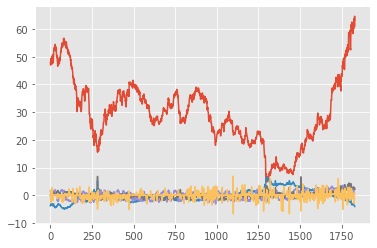

In [ ]:
plt.plot(finalDf)

###Split into Training and Test Set and scaling

In [ ]:
from sklearn.model_selection import train_test_split
sc = MinMaxScaler()

train, test = train_test_split(finalDf, test_size=0.3, shuffle = False)

In [ ]:
train = sc.fit_transform(train)

X_train = []
y_train = []
for i in range(DAYS, len(train)):
    X_train.append(train[i-DAYS:i]) # Chunks of training data with a length of 128 df-rows
    y_train.append(train[:, 0][i])
X_train, y_train = np.array(X_train), np.array(y_train)

print('Training set shape', X_train.shape, y_train.shape)

test = sc.fit_transform(test)

X_test, y_test = [], []
for i in range(DAYS, len(test)):
    X_test.append(test[i-DAYS:i])
    y_test.append(test[:, 0][i])    
X_test, y_test = np.array(X_test), np.array(y_test) 

print('Test set shape', X_test.shape, y_test.shape)

Training set shape (1251, 30, 5) (1251,)
Test set shape (519, 30, 5) (519,)


###Definitions to train, evaluate, and plot

In [ ]:
#Build and train the model
def fit_model(train,val,timesteps,hl,lr,batch,epochs):
    X_train = []
    Y_train = []
    X_val = []
    Y_val = []
  
    for i in range(timesteps,train.shape[0]):
        X_train.append(train[i-timesteps:i])
        Y_train.append(train[i][0])
    X_train,Y_train = np.array(X_train),np.array(Y_train)
  
    for i in range(timesteps,val.shape[0]):
        X_val.append(val[i-timesteps:i])
        Y_val.append(val[i][0])
    X_val,Y_val = np.array(X_val),np.array(Y_val)
    
    # Adding Layers to the model
    model = Sequential()
    model.add(LSTM(X_train.shape[2],input_shape = (X_train.shape[1],X_train.shape[2]),return_sequences = True,
                   activation = 'relu'))
    for i in range(len(hl)-1):        
        model.add(LSTM(hl[i],activation = 'relu',return_sequences = True))
    model.add(LSTM(hl[-1],activation = 'relu'))
    model.add(Dense(1))
    model.compile(optimizer = 'adam', loss = 'mean_squared_error')
  
    # Training the data
    history = model.fit(X_train,Y_train,epochs = epochs,batch_size = batch,validation_data = (X_val, Y_val),verbose = 0,
                        shuffle = False, callbacks=[checkpointer])
    model.reset_states()
    return model, history.history['loss'], history.history['val_loss']

In [ ]:
# Evaluating the model
def evaluate_model(model,test,timesteps):
    X_test = []
    Y_test = []

    for i in range(timesteps,test.shape[0]):
        X_test.append(test[i-timesteps:i])
        Y_test.append(test[i][0])
    X_test,Y_test = np.array(X_test),np.array(Y_test)
  
    Y_hat = model.predict(X_test)
    mse = mean_squared_error(Y_test,Y_hat)
    rmse = sqrt(mse)
    r = r2_score(Y_test,Y_hat)
    return mse, rmse, r, Y_test, Y_hat

In [ ]:
# Plotting the predictions
def plot_data(Y_test,Y_hat):
    plt.plot(Y_test,c = 'g')
    plt.plot(Y_hat,c = 'c')
    plt.xlabel('Day')
    plt.ylabel('Price')
    plt.title(ticker + ' Stock Prediction Graph LSTM model')
    plt.legend(['Actual','Predicted'],loc = 'lower right')
    plt.show()

In [ ]:
# Plotting the training errors
def plot_error(train_loss,val_loss):
    plt.plot(train_loss,c = 'r')
    plt.plot(val_loss,c = 'b')
    plt.ylabel('Loss')
    plt.legend(['train','val'],loc = 'upper right')
    plt.show()

###Set up callback

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint('/content/drive/MyDrive/Final Project Files/LSTM_Weights_'+ticker+'.hdf5', save_weights_only=True, save_best_only=True, verbose=1)

###Set hyper parameters and train model

In [ ]:
timesteps = DAYS
#hl = [40,35]
#lr = 1e-4
#batch_size = 32
#num_epochs = 30

model,train_error,test_error = fit_model(train,test,timesteps,hl,lr,batch_size,num_epochs)


Epoch 1: val_loss improved from inf to 0.07012, saving model to /content/drive/MyDrive/Final Project Files/LSTM_Weights_DVN.hdf5

Epoch 2: val_loss improved from 0.07012 to 0.03911, saving model to /content/drive/MyDrive/Final Project Files/LSTM_Weights_DVN.hdf5

Epoch 3: val_loss improved from 0.03911 to 0.01038, saving model to /content/drive/MyDrive/Final Project Files/LSTM_Weights_DVN.hdf5

Epoch 4: val_loss did not improve from 0.01038

Epoch 5: val_loss improved from 0.01038 to 0.00813, saving model to /content/drive/MyDrive/Final Project Files/LSTM_Weights_DVN.hdf5

Epoch 6: val_loss did not improve from 0.00813

Epoch 7: val_loss improved from 0.00813 to 0.00698, saving model to /content/drive/MyDrive/Final Project Files/LSTM_Weights_DVN.hdf5

Epoch 8: val_loss did not improve from 0.00698

Epoch 9: val_loss improved from 0.00698 to 0.00595, saving model to /content/drive/MyDrive/Final Project Files/LSTM_Weights_DVN.hdf5

Epoch 10: val_loss did not improve from 0.00595

Epoch 

##Results

###Plot of Loss through each Epoch

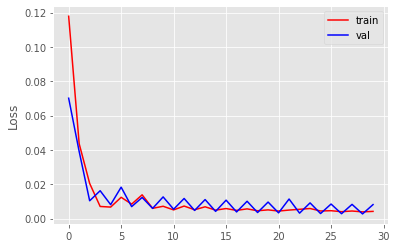

In [ ]:
plot_error(train_error,test_error)

###Prediction on Training set

MSE = 0.005085381526605167
RMSE = 0.0713118610513368
R-Squared Score = 0.8861489397726847


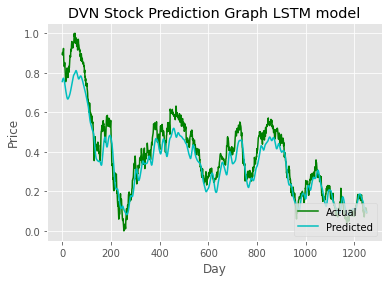

In [ ]:

mse, rmse, r2_value,true,predicted = evaluate_model(model,train,timesteps)
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))
plot_data(true,predicted)

###Prediction on Test Set

MSE = 0.008157946910972262
RMSE = 0.09032135357141334
R-Squared Score = 0.8844531800530491


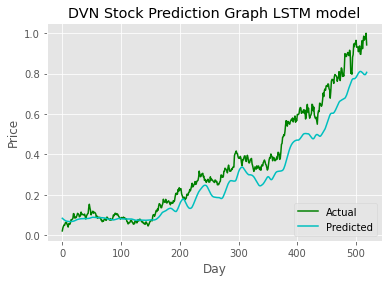

In [ ]:
mse, rmse, r2_value,true,predicted = evaluate_model(model,test,timesteps)
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))
plot_data(true,predicted)